# PBMC CHRONICITY AND INJURED PT
## SID GURAJALA 
### JULY 27 2023

# LIBRARIES

In [1]:
library(parallel)
library(patchwork)
library(purrr)
library(dplyr) 
library(tidyr)
library(cowplot)
library(singlecellmethods)
library(ggplot2)
library(ggbeeswarm)
library(stringr)
library(viridis)

source("/data/srlab/anathan/scripts/scseq_utils.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘singlecellmethods’


The following object is masked from ‘package:base’:

    rowMeans


Loading required package: viridisLite



In [101]:
plot_shuffled_features <- function(input_df, input_norm, feature, pct, pt_size,
                                  max.cutoff = NA, min.cutoff = NA) {
    if (is.na(max.cutoff)) {
        max.cutoff <- quantile(input_norm[feature, input_df$cell], pct)
    }
    if (is.na(min.cutoff)) {
        min.cutoff <- quantile(input_norm[feature, input_df$cell], 1 - pct)
    }

plot_df <- input_df 
    
plot_df$norm_expression <- input_norm[feature, input_df$cell]
    
plot_df <- plot_df %>% 
                mutate(norm_expression = ifelse(norm_expression < min.cutoff, min.cutoff, norm_expression)) %>%
                mutate(norm_expression = ifelse(norm_expression > max.cutoff, max.cutoff, norm_expression)) 

p <- ggplot() +
        geom_point(
            data = plot_df[sample(nrow(plot_df)), ] %>% 
                      select(hUMAP1, hUMAP2, norm_expression), 
            aes(x = hUMAP1, y = hUMAP2, color = norm_expression),
            size = pt_size, stroke = 0.0001, shape = 20) +
      scale_color_viridis(name = "Expression") +
      labs(x="", y="", title = feature)+
      theme_classic(base_size = 20)+
      #facet_wrap(~dataset)+
      theme(
        legend.text = element_text(size = 10), 
        legend.title = element_text(size = 12),
          panel.border = element_rect(colour = "black", fill=NA, size=1),
        plot.title = element_text(color="black", size=25, hjust = 0.5),
        strip.text.x = element_text(size = 18),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line = element_blank()) 
return(p)
}


In [2]:
labelfontsize = 20
tickfontsize = 16

figdir = '../../figures/components/'

In [3]:
# source("/data/srlab/ssg34/SLE_kidney_v2/scripts/libs/kidney_utils_updated.r")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: Rcpp



In [1]:
# source("/data/srlab/ssg34/SLE_kidney_v2/scripts/libs/pbmc_utils.r")

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis



Attaching package: ‘singlecellmethods’


The following object is masked from ‘package:SeuratObject’:

    rowMeans


The following object is masked from ‘package:base’:

    rowMeans




In [2]:
clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') 

clinical_LN <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                rename(Final_Site = Site) %>% 
                filter(Type == "LN", Final_Chronicity != "NA") 

In [3]:
kidney_immune_meta <-  readRDS("/data/srlab/ssg34/share/for_QIAN/qcd_all_immune_metadata_03022023.rds") %>%
                            filter(dataset == "scRNAseq") %>%
                            mutate(individual = str_split(sample, "_")) %>% 
                            rowwise() %>% 
                            mutate(individual = unlist(individual)[3]) %>% data.frame()

In [4]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_pbmc_metadata.rds')
SLE_harmony <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_pbmc_hPCs.rds')
SLE_umap <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_pbmc_umap.rds')

In [4]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_pbmc_metadata.rds')

In [5]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                        filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() 

In [4]:
SLE_donors <- read.csv('/data/srlab/ssg34/SLE_pbmc/lupus_pbmcs/sequencing_meta/samples.csv', check.names = FALSE)

# SAMPLE CLASSIFICATION

## MYELOID LYMPHOID IN KIDNEY

In [70]:
kidney_cell.type <- kidney_immune_meta %>% filter(dataset == "scRNAseq") %>% 
                        select(individual, broad_cell_type)  %>% 
                         mutate(broad_cell_type = ifelse(broad_cell_type == "Myeloid Cell",
                                                        "Myeloid", 
                                                        "Lymphoid")) %>%
                        table() %>% data.frame() %>% 
                        group_by(individual) %>% 
                        mutate(Prop = Freq / sum(Freq))

In [71]:
kidney_cell.type <- kidney_cell.type %>%
                        filter(broad_cell_type == "Lymphoid") %>% 
                        left_join(clinical_LN %>% select(Responder.Status, Final_Chronicity,
                                                         Final_Activity, individual))

Joining, by = "individual"


In [72]:
kidney_cell.type <- kidney_cell.type %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                          Responder_Status = c(0, 1, 2)))

Joining, by = "Responder.Status"


In [73]:
chronicity_response <- clinical_LN %>% 
                            select(Responder.Status, Final_Chronicity) %>% 
                            left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                        Responder_Status = c(0, 1, 2))) 

Joining, by = "Responder.Status"


In [23]:
activity_isn <- clinical_LN %>% select(Final_Activity, Final_ISN)

In [24]:
activity_isn <- activity_isn %>% filter(Final_ISN %in% c("[III]", "[III][V]", "[IV]", "[IV][V]", "[V]"))

[1] FALSE


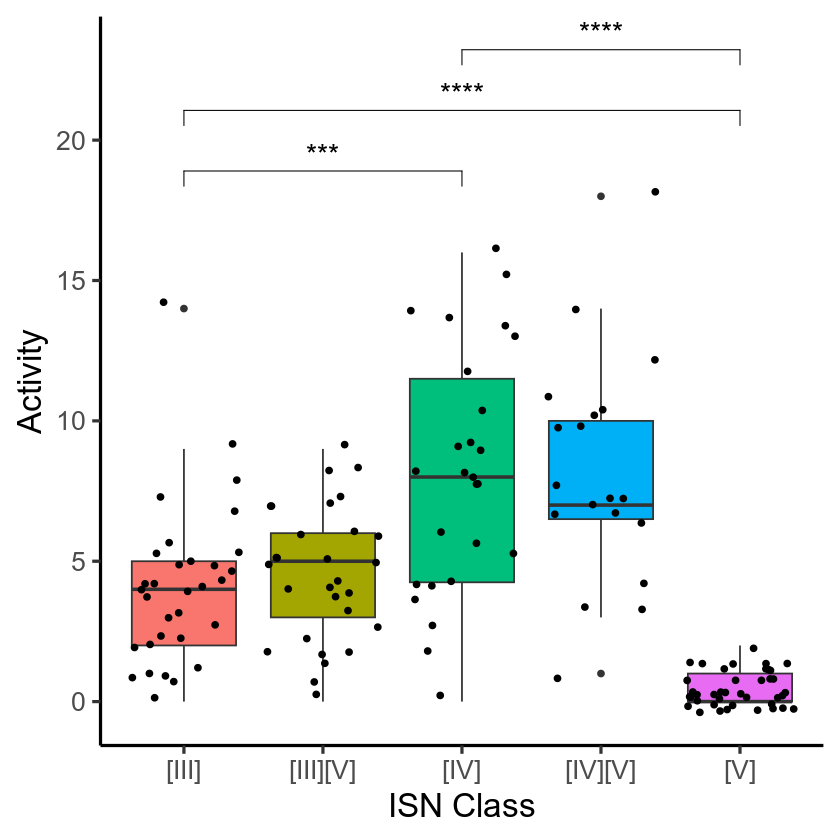

In [27]:
my_comparisons <- list(
                        c("[III]", "[IV]"),
                        c("[III]", "[V]"),
                        c("[IV]", "[V]"))

ggplot(activity_isn %>% na.omit(), aes(x = as.factor(Final_ISN), y = Final_Activity)) + 
    geom_boxplot(aes(fill = Final_ISN)) + 
    geom_jitter() + 
    labs(x = "ISN Class", y = "Activity") + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "FALSE",
          plot.title = element_text(hjust = 0.5)) + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)  


In [11]:
cor.test(chronicity_response$Final_Chronicity, chronicity_response$Responder_Status)


	Pearson's product-moment correlation

data:  chronicity_response$Final_Chronicity and chronicity_response$Responder_Status
t = -2.7084, df = 117, p-value = 0.007776
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.40517231 -0.06577046
sample estimates:
       cor 
-0.2428906 


[1] FALSE


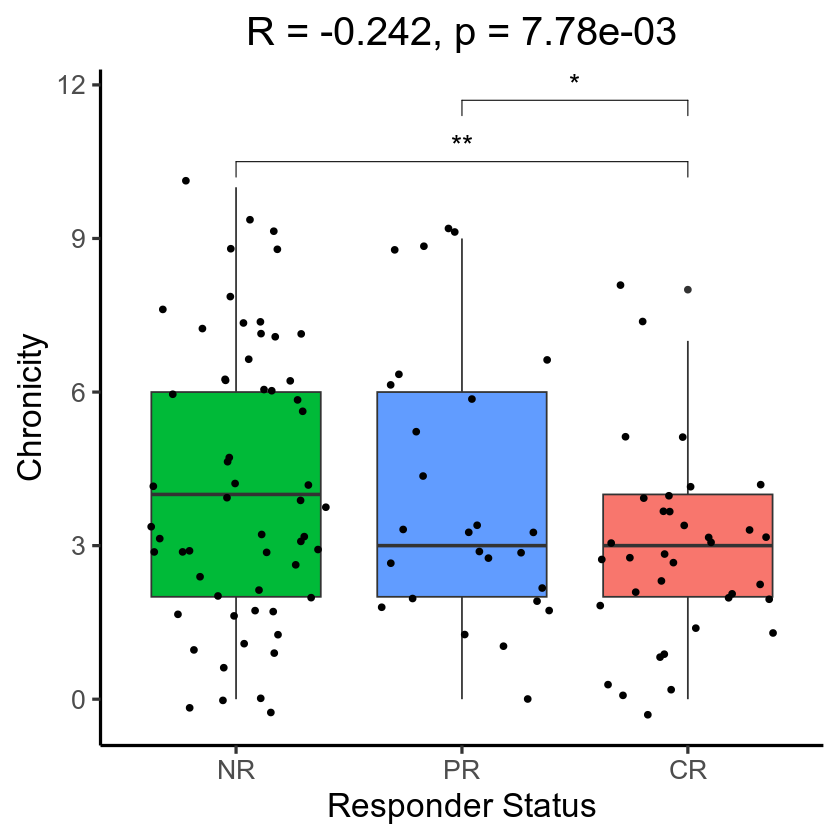

In [32]:
my_comparisons <- list(
                        c("NR", "CR"),
                        c("PR", "CR"))

ggplot(chronicity_response %>% na.omit(), aes(x = as.factor(Responder.Status), y = Final_Chronicity)) + 
    geom_boxplot(aes(fill = Responder.Status)) + 
    geom_jitter() + 
    labs(x = "Responder Status", y = "Chronicity",
         title = "R = -0.242, p = 7.78e-03") + 
    scale_x_discrete(limits = c("NR", "PR", "CR")) + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "FALSE",
          plot.title = element_text(hjust = 0.5)) + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)  


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 44 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 44 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 44 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 44 rows containing missing values (`geom_point()`).”


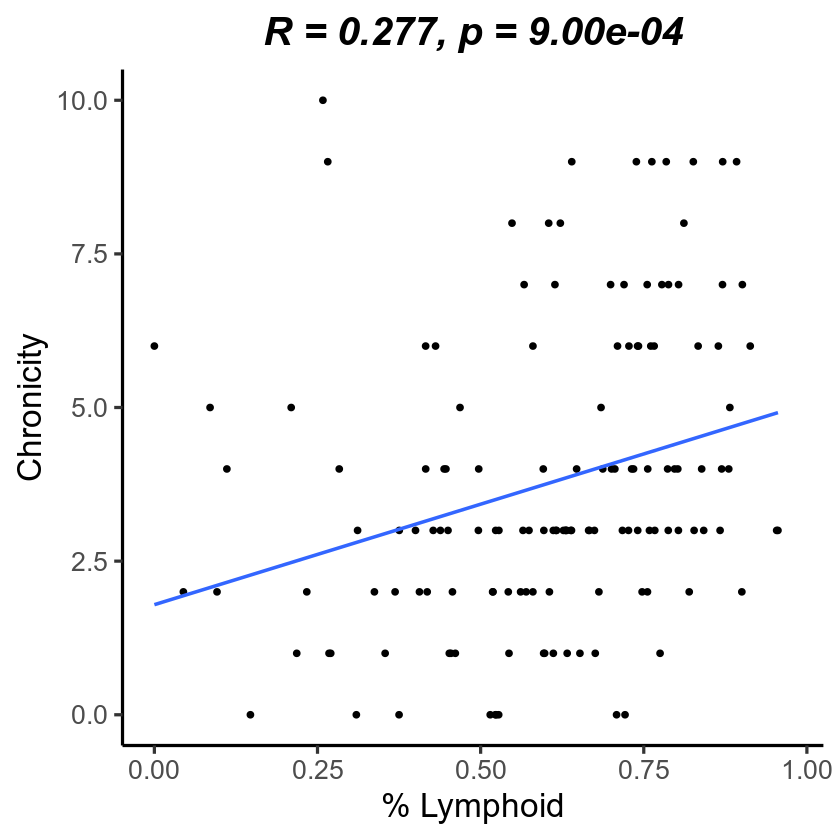

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 71 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 71 rows containing missing values (`geom_point()`).”


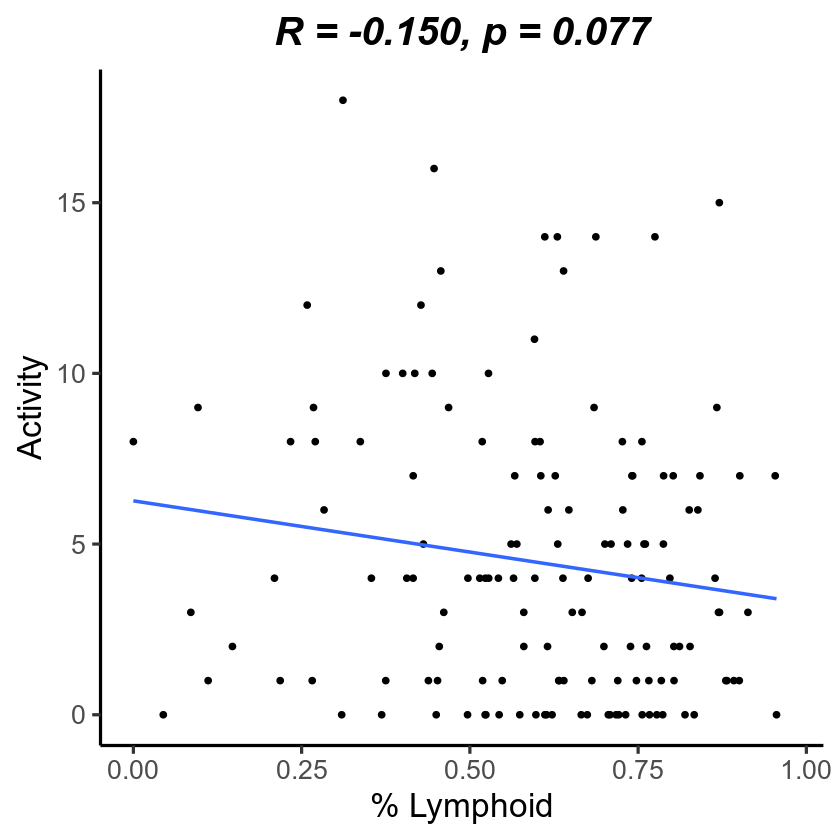

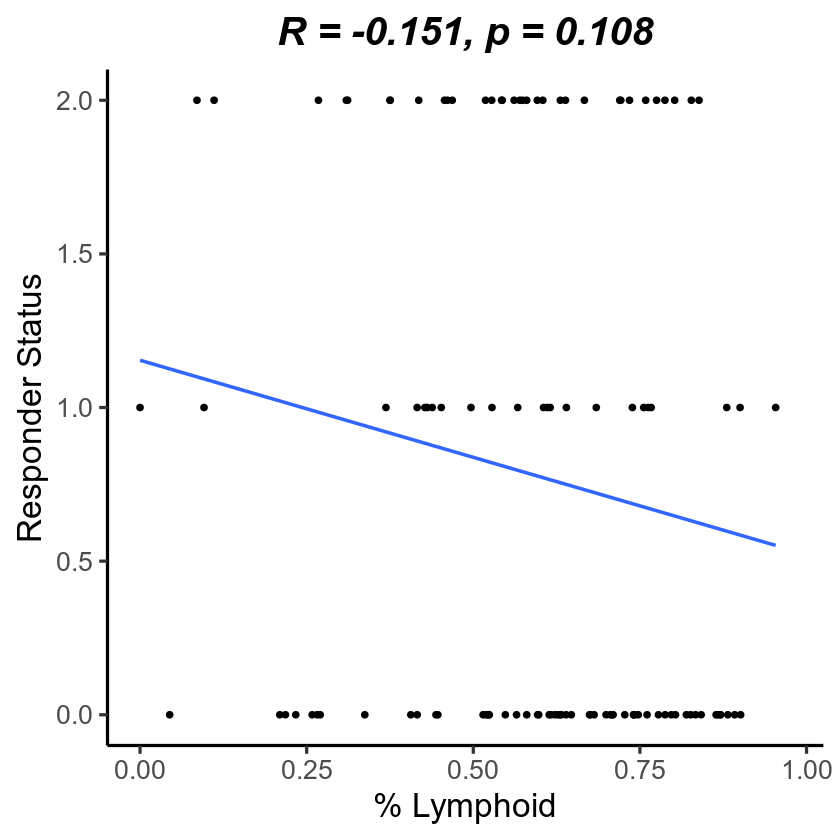

In [41]:
ggplot(kidney_cell.type, aes(x = Prop, y = Final_Chronicity)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "% Lymphoid", y = "Chronicity",
        title = "R = 0.277, p = 9.00e-04") + 
    geom_smooth(method = "lm", se = FALSE)  + 
    theme(plot.title = element_text(face = "bold.italic", hjust = 0.5))


ggplot(kidney_cell.type, aes(x = Prop, y = Final_Activity)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "% Lymphoid", y = "Activity",
        title = "R = -0.150, p = 0.077") + 
    geom_smooth(method = "lm", se = FALSE)  + 
    theme(plot.title = element_text(face = "bold.italic", hjust = 0.5))


ggplot(kidney_cell.type, aes(x = Prop, y = Responder_Status)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "% Lymphoid", y = "Responder Status",
        title = "R = -0.151, p = 0.108") + 
    geom_smooth(method = "lm", se = FALSE)  + 
    theme(plot.title = element_text(face = "bold.italic", hjust = 0.5))

In [37]:
cor.test(kidney_cell.type$Prop, kidney_cell.type$Final_Chronicity)
cor.test(kidney_cell.type$Prop, kidney_cell.type$Final_Activity)
cor.test(kidney_cell.type$Prop, kidney_cell.type$Responder_Status)


	Pearson's product-moment correlation

data:  kidney_cell.type$Prop and kidney_cell.type$Final_Chronicity
t = 3.3967, df = 139, p-value = 0.0008898
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1168775 0.4228032
sample estimates:
      cor 
0.2768407 



	Pearson's product-moment correlation

data:  kidney_cell.type$Prop and kidney_cell.type$Final_Activity
t = -1.7775, df = 139, p-value = 0.07767
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.30683338  0.01663898
sample estimates:
       cor 
-0.1490832 



	Pearson's product-moment correlation

data:  kidney_cell.type$Prop and kidney_cell.type$Responder_Status
t = -1.6199, df = 112, p-value = 0.1081
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.32614576  0.03354138
sample estimates:
       cor 
-0.1513068 


In [46]:
kidney_cell.type <- kidney_immune_meta %>% filter(dataset == "scRNAseq") %>% 
                        select(individual, broad_cell_type)  %>% 
                         mutate(broad_cell_type = ifelse(broad_cell_type == "Myeloid Cell",
                                                        "Myeloid", 
                                                        "Lymphoid")) %>%
                        table() %>% data.frame() %>% 
                        group_by(individual) %>% 
                        filter(sum(Freq) > 40) %>% 
                        mutate(Prop = Freq / sum(Freq))

In [47]:
blood_cell.type <- SLE_pbmc_meta %>% 
                        select(individual, mono.ids) %>%  
                        table() %>% data.frame() %>% 
                        group_by(individual) %>% 
                        filter(sum(Freq) > 100) %>% 
                        mutate(Prop = Freq / sum(Freq))

In [48]:
joint_cell.type <- blood_cell.type %>% 
                        rename(Blood_Prop = Prop,
                               broad_cell_type = mono.ids) %>% 
                        select(-Freq) %>% 
                    left_join(kidney_cell.type %>% 
                            select(individual, broad_cell_type, Prop) %>% 
                            rename(Kidney_Prop = Prop)) %>% na.omit()                                                                                                                                                

Joining, by = c("individual", "broad_cell_type")


In [49]:
joint_plot_df <- joint_cell.type %>% filter(broad_cell_type == "Lymphoid")

In [50]:
cor.test(joint_plot_df$Blood_Prop, joint_plot_df$Kidney_Prop)


	Pearson's product-moment correlation

data:  joint_plot_df$Blood_Prop and joint_plot_df$Kidney_Prop
t = 1.7109, df = 108, p-value = 0.08997
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02557262  0.33936574
sample estimates:
      cor 
0.1624467 


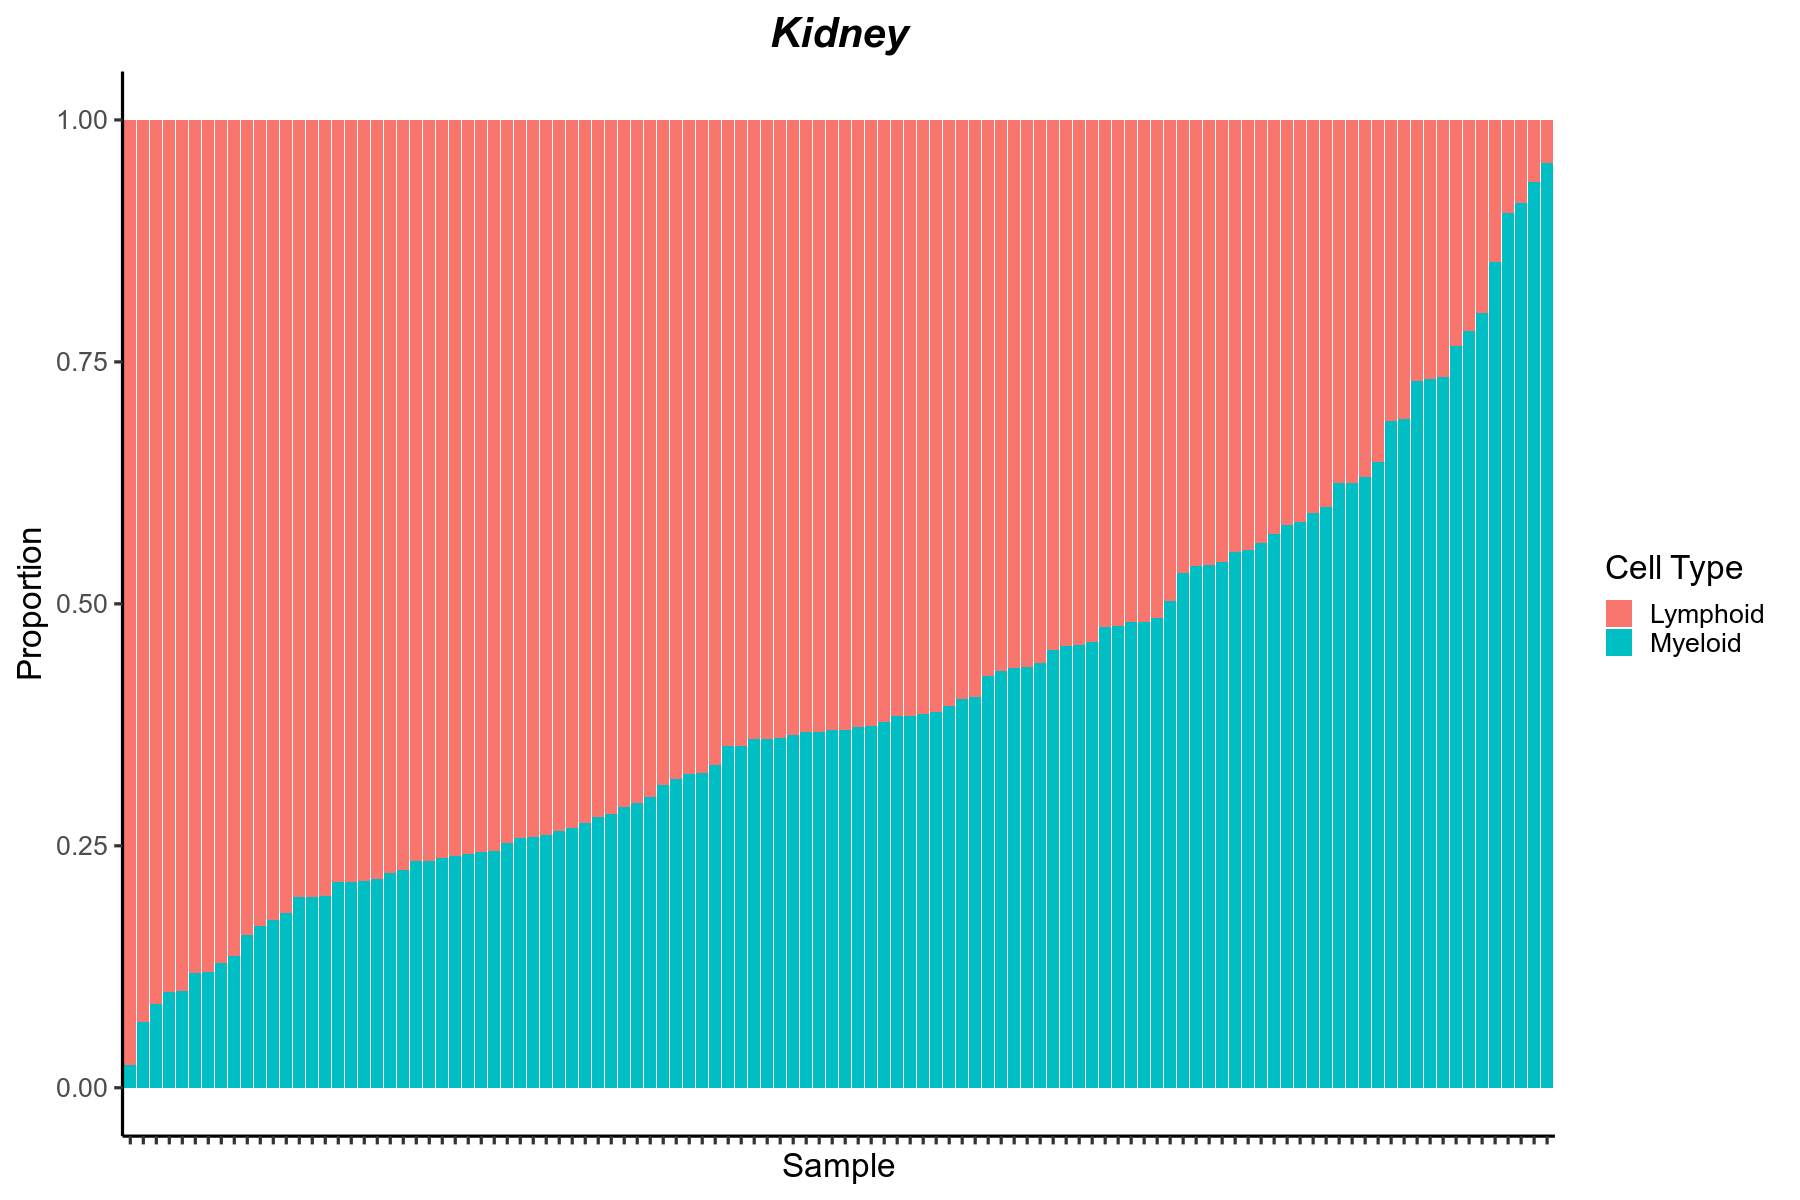

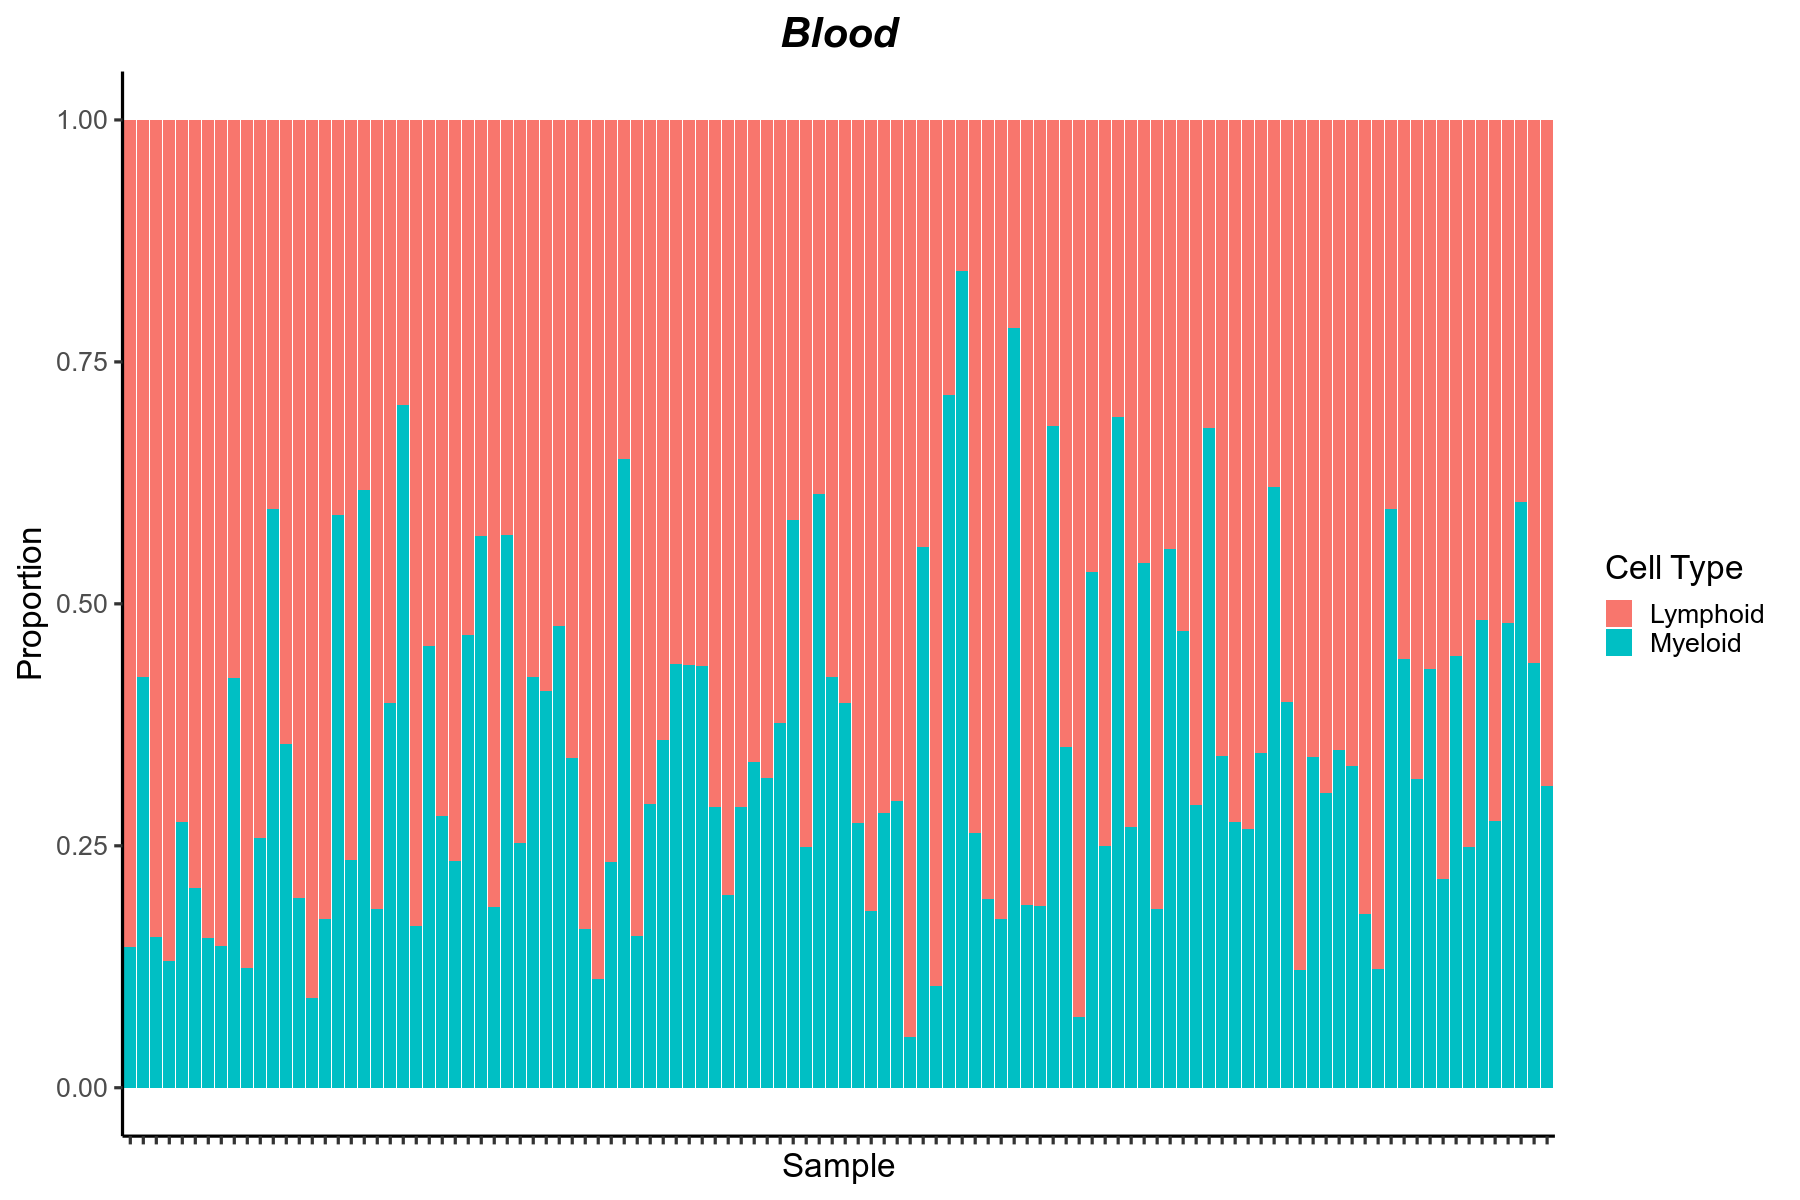

In [51]:
fig.size(10, 15)
ggplot(joint_cell.type, aes(x = individual, y = Kidney_Prop, fill = broad_cell_type)) + 
    geom_bar(stat = "identity", position = "stack") + 
    scale_x_discrete(limits = joint_cell.type %>% 
                                 filter(broad_cell_type == "Lymphoid") %>% 
                                 arrange(desc(Kidney_Prop)) %>% pull(individual)) +
    theme_classic(base_size = 20) + 
    labs(x = "Sample", y = "Proportion", title = "Kidney") +
    theme(axis.text.x = element_blank(),
          plot.title = element_text(size = 25, face = "bold.italic", hjust = 0.5)) + 
    scale_fill_discrete(name = "Cell Type")

fig.size(10, 15)
ggplot(joint_cell.type, aes(x = individual, y = Blood_Prop, fill = broad_cell_type)) + 
    geom_bar(stat = "identity", position = "stack") + 
    scale_x_discrete(limits = joint_cell.type %>% 
                                 filter(broad_cell_type == "Lymphoid") %>% 
                                 arrange(desc(Kidney_Prop)) %>% pull(individual)) + 
    theme_classic(base_size = 20) + 
    labs(x = "Sample", y = "Proportion", title = "Blood") +
    theme(axis.text.x = element_blank(),
          plot.title = element_text(size = 25, face = "bold.italic", hjust = 0.5)) +
    scale_fill_discrete(name = "Cell Type")

## CD8+ GZMB+

In [233]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata.rds')

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control"))

In [234]:
ln_kidney_cell_state_freq <- kidney_immune_meta %>% 
                            filter(Type == "LN",
                                   broad_cell_type %in% c("T Cell", "NK Cell")) %>% 
                            select(new_cluster_number, sample) %>% table()  %>% 
                            data.frame() %>% pivot_wider(names_from = "new_cluster_number",
                                                         values_from = "Freq")

ln_kidney_cell_state_freq$total <- rowSums(ln_kidney_cell_state_freq[, -1])
ln_kidney_cell_state_freq$ctl_freq <- rowSums(ln_kidney_cell_state_freq[, c('1', '2')]) / ln_kidney_cell_state_freq$total
ln_kidney_cell_state_freq <- ln_kidney_cell_state_freq %>% 
                                        left_join(kidney_immune_meta %>% select(sample, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(sample, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>% 
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 3))

Joining, by = "sample"
Joining, by = "individual"


In [235]:
control_kidney_cell_state_freq <- kidney_immune_meta %>% 
                                    filter(Type == "Control",
                                          broad_cell_type %in% c("T Cell", "NK Cell")) %>% 
                                    select(new_cluster_number, sample) %>% table()  %>% 
                                    data.frame() %>% 
                                    pivot_wider(names_from = "new_cluster_number",
                                                         values_from = "Freq")

control_kidney_cell_state_freq$total <- rowSums(control_kidney_cell_state_freq[, -1])
control_kidney_cell_state_freq$ctl_freq <- rowSums(control_kidney_cell_state_freq[, c('1', '2')]) / control_kidney_cell_state_freq$total
control_kidney_cell_state_freq <- control_kidney_cell_state_freq %>% 
                                        left_join(kidney_immune_meta %>% select(sample, individual) %>% unique()) %>% 
                                        mutate(Chronicity_Quantile = "Control",
                                               Final_Chronicity = "Control") %>% 
                                        select(sample, individual, Chronicity_Quantile, Final_Chronicity, ctl_freq)


Joining, by = "sample"


In [236]:
sle_blood_cell_state_freq <- SLE_pbmc_meta %>% 
                                    filter(Type == "SLE") %>% 
                                    select(RNA_snn_res.0.5, Unified_Visit) %>% table()  %>% 
                                    data.frame() %>% pivot_wider(names_from = "RNA_snn_res.0.5",
                                                         values_from = "Freq")

sle_blood_cell_state_freq$total <- rowSums(sle_blood_cell_state_freq[, -1])
sle_blood_cell_state_freq$ctl_freq <- rowSums(sle_blood_cell_state_freq[, c('11', '14')]) / sle_blood_cell_state_freq$total
sle_blood_cell_state_freq <- sle_blood_cell_state_freq %>% filter(total > 150) %>% 
                                        left_join(SLE_pbmc_meta %>% select(Unified_Visit, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(Unified_Visit, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>%
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 3)) 

Joining, by = "Unified_Visit"
Joining, by = "individual"


In [198]:
control_blood_cell_state_freq <- SLE_pbmc_meta %>% 
                                    filter(Type == "Control") %>% 
                                    select(RNA_snn_res.0.5, Unified_Visit) %>% table()  %>% 
                                    data.frame() %>% pivot_wider(names_from = "RNA_snn_res.0.5",
                                                         values_from = "Freq")

control_blood_cell_state_freq$total <- rowSums(control_blood_cell_state_freq[, -1])
control_blood_cell_state_freq$ctl_freq <- rowSums(control_blood_cell_state_freq[, c('11', '14')]) / control_blood_cell_state_freq$total
control_blood_cell_state_freq <- control_blood_cell_state_freq %>% filter(total > 150) %>% 
                                        left_join(SLE_pbmc_meta %>% select(Unified_Visit, individual) %>% unique()) %>% 
                                        mutate(Chronicity_Quantile = "Control",
                                               Final_Chronicity = "Control") %>% 
                                        select(Unified_Visit, individual, Chronicity_Quantile, Final_Chronicity, ctl_freq)

Joining, by = "Unified_Visit"


[1] FALSE



	Pearson's product-moment correlation

data:  ln_kidney_cell_state_freq$Final_Chronicity and ln_kidney_cell_state_freq$ctl_freq
t = -3.5935, df = 135, p-value = 0.0004561
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4413161 -0.1344154
sample estimates:
     cor 
-0.29547 


`geom_smooth()` using formula = 'y ~ x'


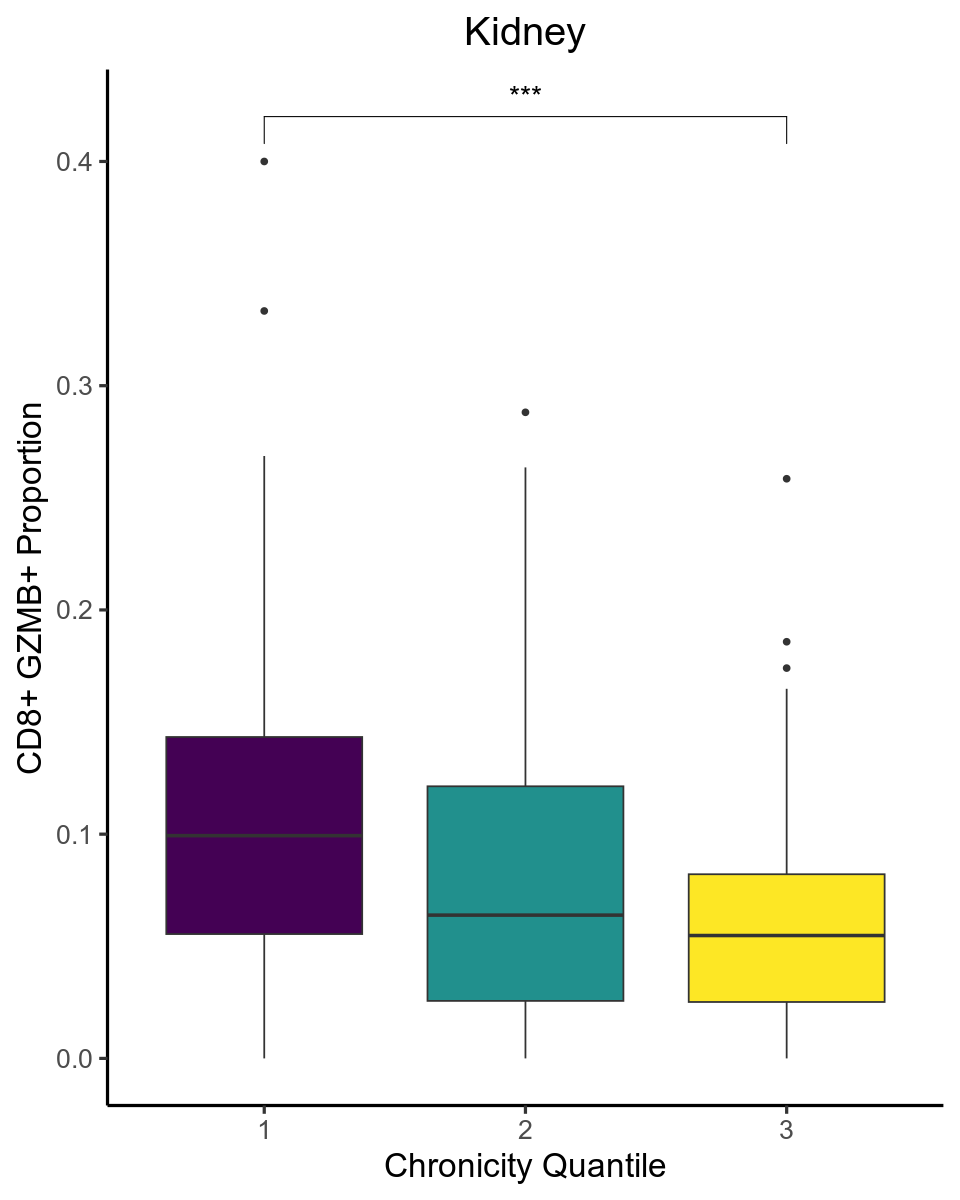

[1] FALSE


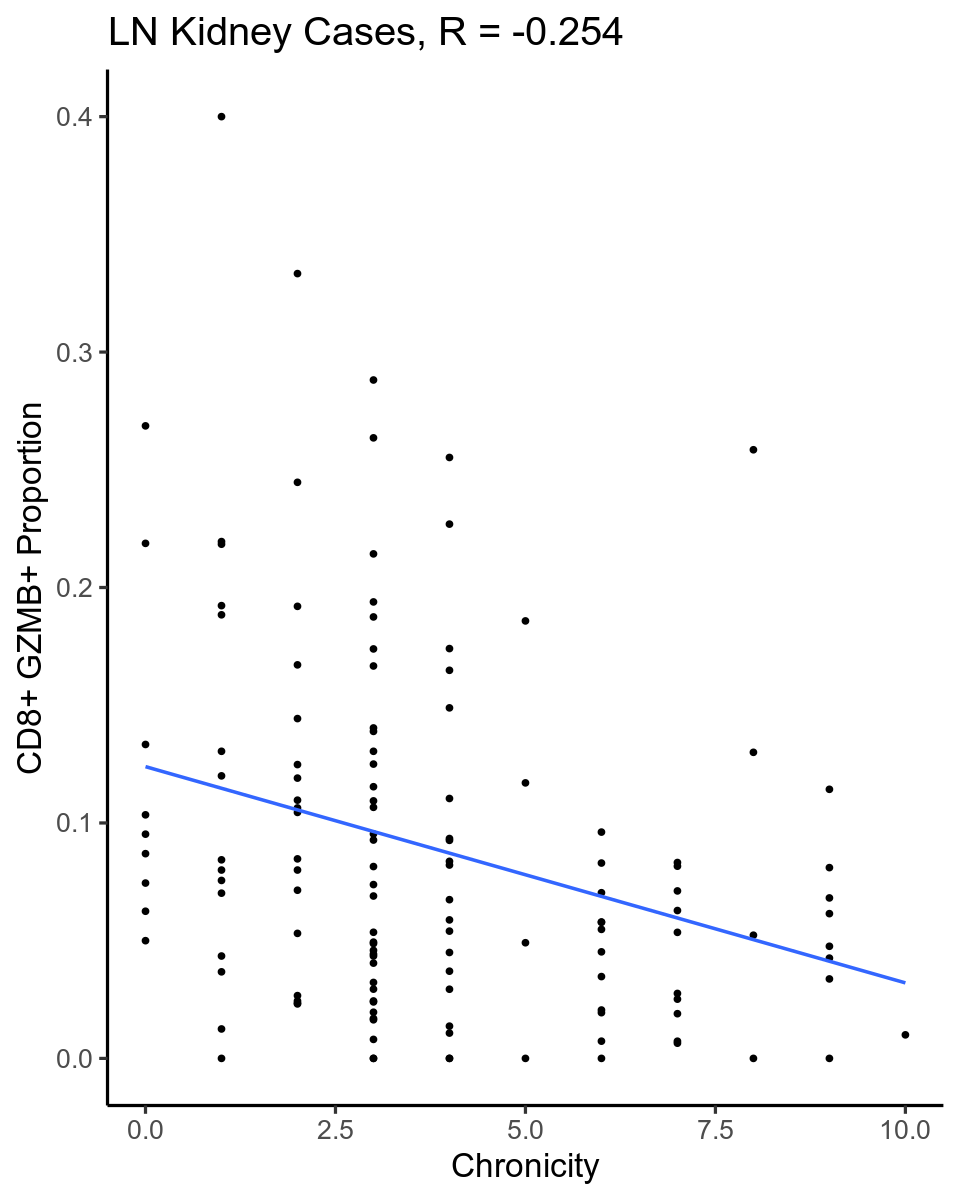


	Pearson's product-moment correlation

data:  sle_blood_cell_state_freq$Final_Chronicity and sle_blood_cell_state_freq$ctl_freq
t = -1.7288, df = 100, p-value = 0.08692
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.35313294  0.02494387
sample estimates:
       cor 
-0.1703574 


`geom_smooth()` using formula = 'y ~ x'


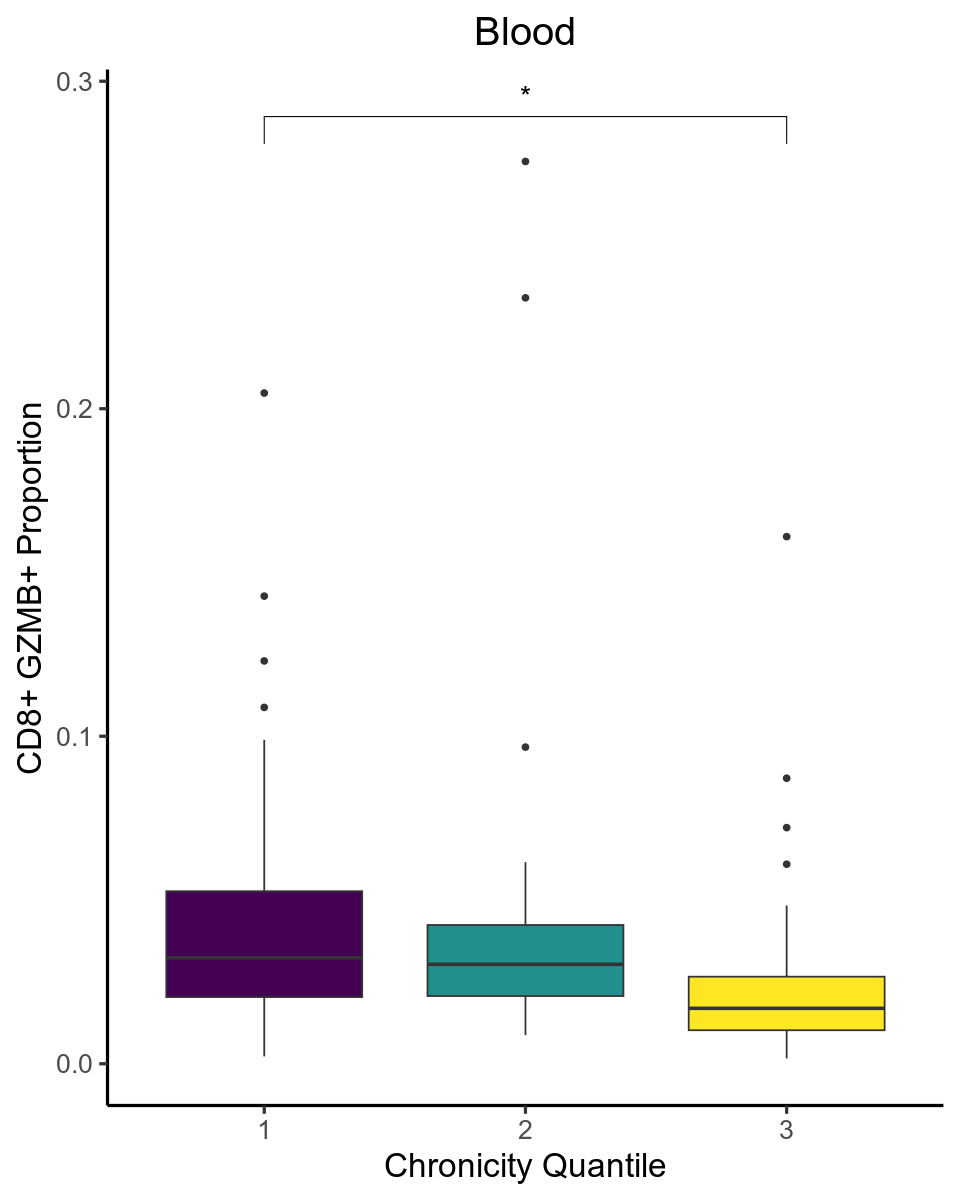

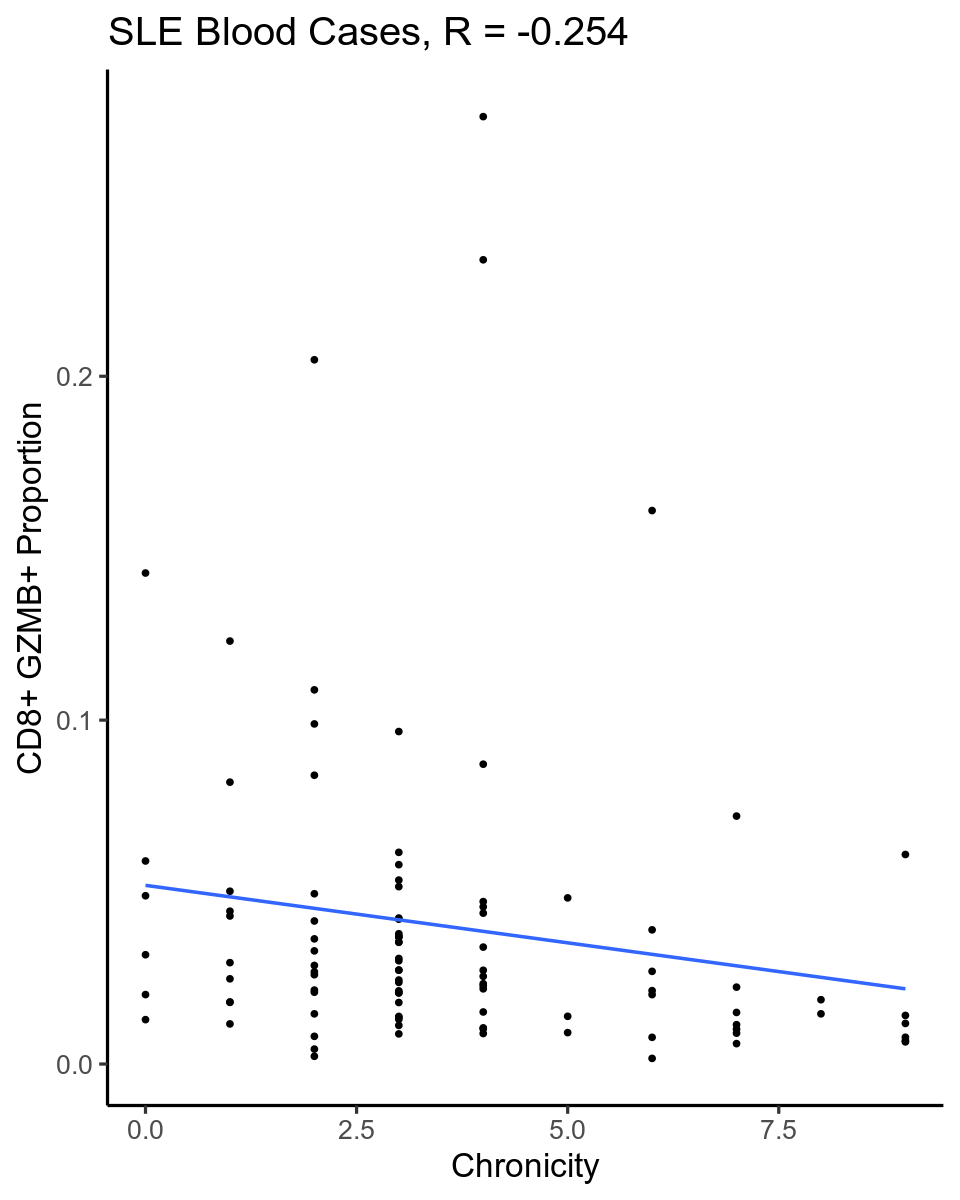

In [239]:
my_comparisons <- list(
                        c("1", "3"))

ggplot(ln_kidney_cell_state_freq,
        aes(x = factor(Chronicity_Quantile,
                          levels = c("1", "2", "3")), y = ctl_freq, fill = Chronicity_Quantile)) + 
    geom_boxplot() + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5)) + 
    labs(x = "Chronicity Quantile", 
         y = "CD8+ GZMB+ Proportion",
         title = "Kidney") +
    scale_fill_viridis() + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) 

cor.test(ln_kidney_cell_state_freq$Final_Chronicity, ln_kidney_cell_state_freq$ctl_freq)

ggplot(ln_kidney_cell_state_freq, aes(x = Final_Chronicity, y = ctl_freq)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "Chronicity", y = "CD8+ GZMB+ Proportion",
         title = "LN Kidney Cases, R = -0.254") + 
    geom_smooth(method = "lm", se = FALSE)
 

my_comparisons <- list(
                        c("1", "3"))

ggplot(sle_blood_cell_state_freq,
        aes(x = as.character(Chronicity_Quantile), y = ctl_freq, fill = Chronicity_Quantile)) + 
    geom_boxplot() + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5)) + 
    labs(x = "Chronicity Quantile", 
         y = "CD8+ GZMB+ Proportion",
         title = "Blood") + 
    scale_fill_viridis() + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) 

cor.test(sle_blood_cell_state_freq$Final_Chronicity, sle_blood_cell_state_freq$ctl_freq)

ggplot(sle_blood_cell_state_freq, aes(x = Final_Chronicity, y = ctl_freq)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "Chronicity", y = "CD8+ GZMB+ Proportion",
         title = "SLE Blood Cases, R = -0.254") + 
    geom_smooth(method = "lm", se = FALSE)

## CD16++ Monocytes

In [195]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata.rds')

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control"))

In [199]:
ln_kidney_cell_state_freq <- kidney_immune_meta %>% 
                            filter(Type == "LN",
                                   broad_cell_type %in% c("Myeloid Cell")) %>% 
                            select(new_cluster_number, sample) %>% table()  %>% 
                            data.frame() %>% pivot_wider(names_from = "new_cluster_number",
                                                         values_from = "Freq")

ln_kidney_cell_state_freq$total <- rowSums(ln_kidney_cell_state_freq[, -1])
ln_kidney_cell_state_freq$ctl_freq <- rowSums(ln_kidney_cell_state_freq[, c('0')]) / ln_kidney_cell_state_freq$total
ln_kidney_cell_state_freq <- ln_kidney_cell_state_freq %>% 
                                        left_join(kidney_immune_meta %>% select(sample, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(sample, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>% 
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 4)) 

Joining, by = "sample"
Joining, by = "individual"


In [200]:
sle_blood_cell_state_freq <- SLE_pbmc_meta %>% 
                                    filter(Type == "SLE") %>% 
                                    select(RNA_snn_res.0.75, Unified_Visit) %>% table()  %>% 
                                    data.frame() %>% pivot_wider(names_from = "RNA_snn_res.0.75",
                                                         values_from = "Freq")

sle_blood_cell_state_freq$total <- rowSums(sle_blood_cell_state_freq[, -1])
sle_blood_cell_state_freq$ctl_freq <- rowSums(sle_blood_cell_state_freq[, c('3')]) / sle_blood_cell_state_freq$total
sle_blood_cell_state_freq <- sle_blood_cell_state_freq %>%
                                        left_join(SLE_pbmc_meta %>% select(Unified_Visit, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(Unified_Visit, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>% 
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 4)) 

Joining, by = "Unified_Visit"
Joining, by = "individual"


[1] FALSE



	Pearson's product-moment correlation

data:  ln_kidney_cell_state_freq$Final_Chronicity and ln_kidney_cell_state_freq$ctl_freq
t = -2.8501, df = 139, p-value = 0.005037
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.38531655 -0.07247454
sample estimates:
       cor 
-0.2349715 


`geom_smooth()` using formula = 'y ~ x'


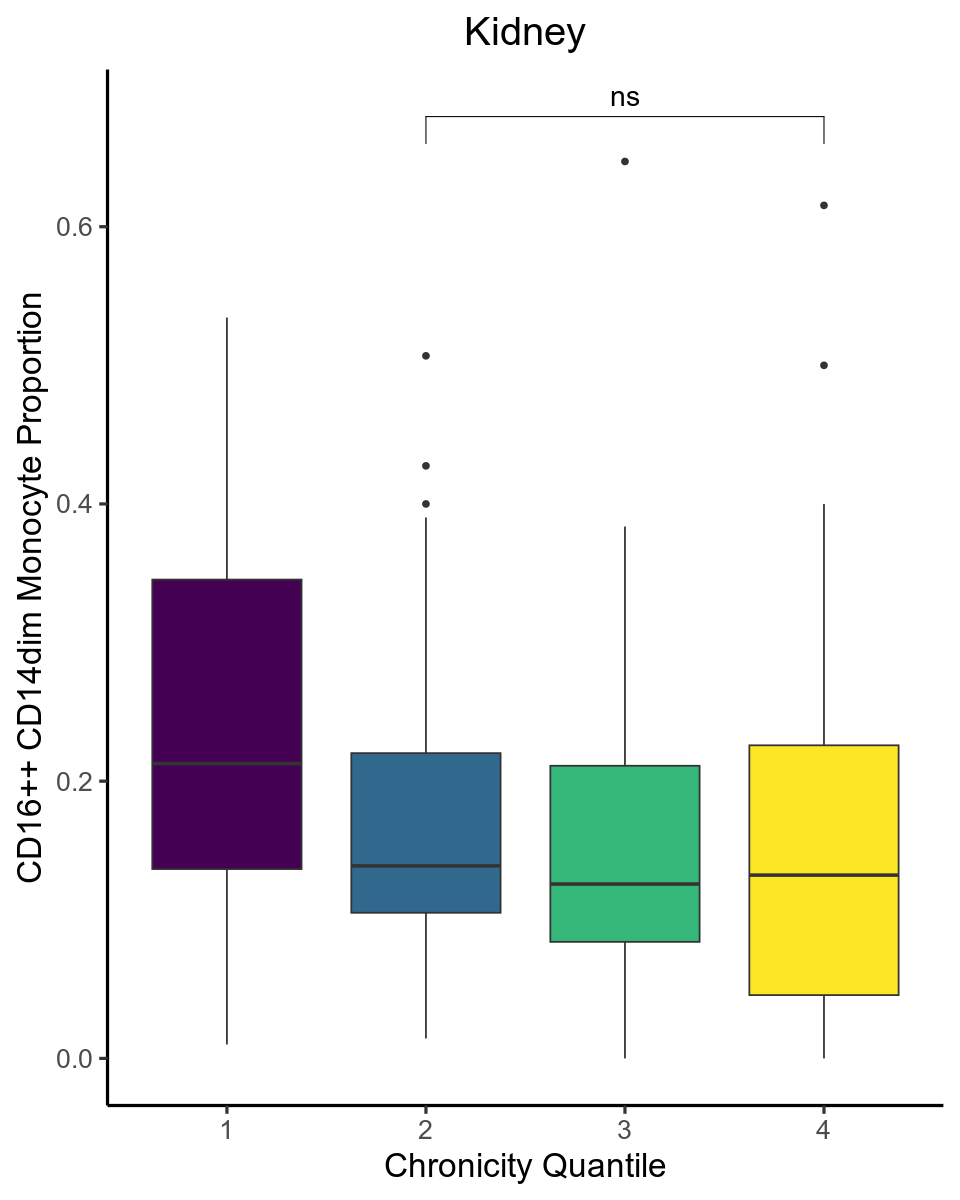

[1] FALSE


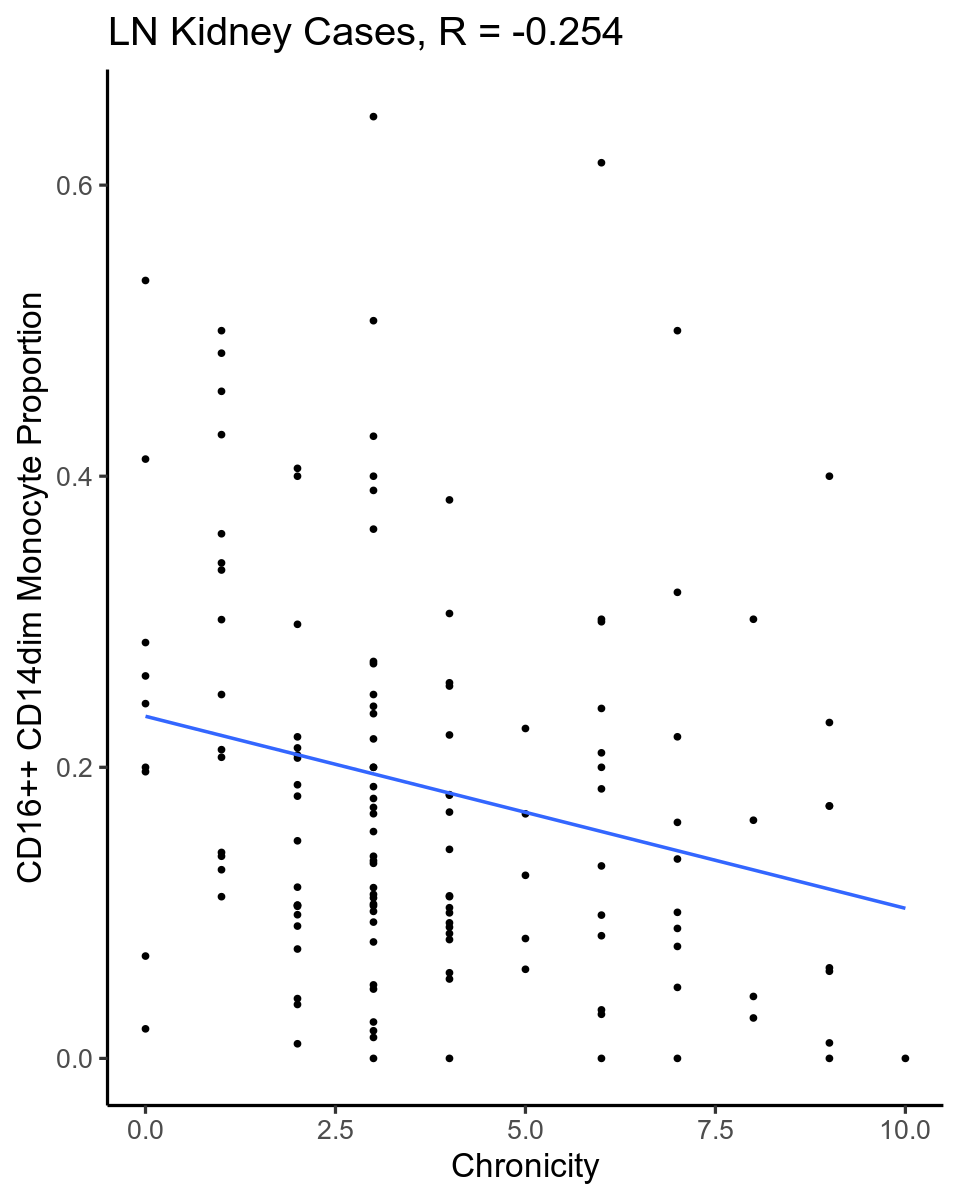


	Pearson's product-moment correlation

data:  sle_blood_cell_state_freq$Final_Chronicity and sle_blood_cell_state_freq$ctl_freq
t = 2.4384, df = 106, p-value = 0.01642
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.0433736 0.4019283
sample estimates:
      cor 
0.2304586 


`geom_smooth()` using formula = 'y ~ x'


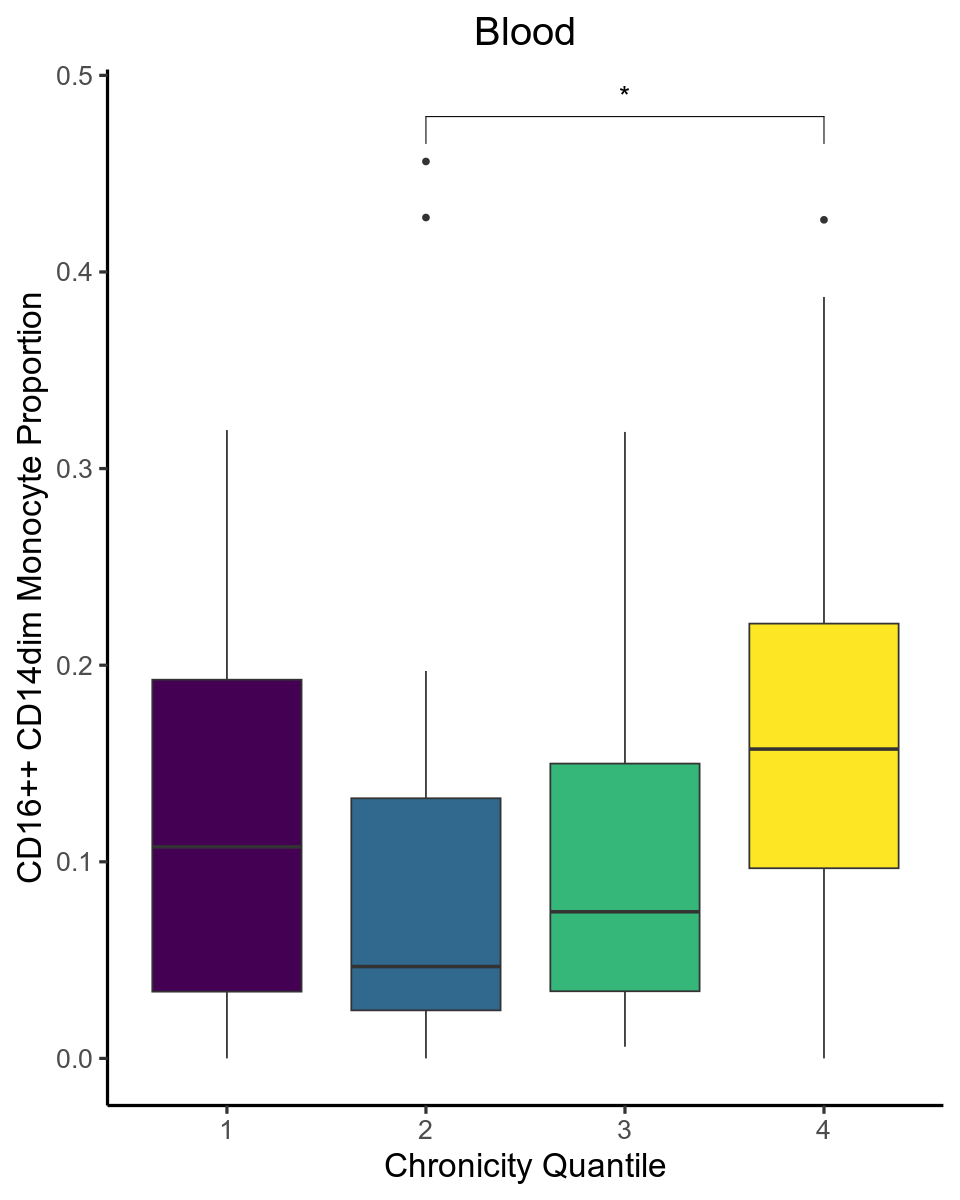

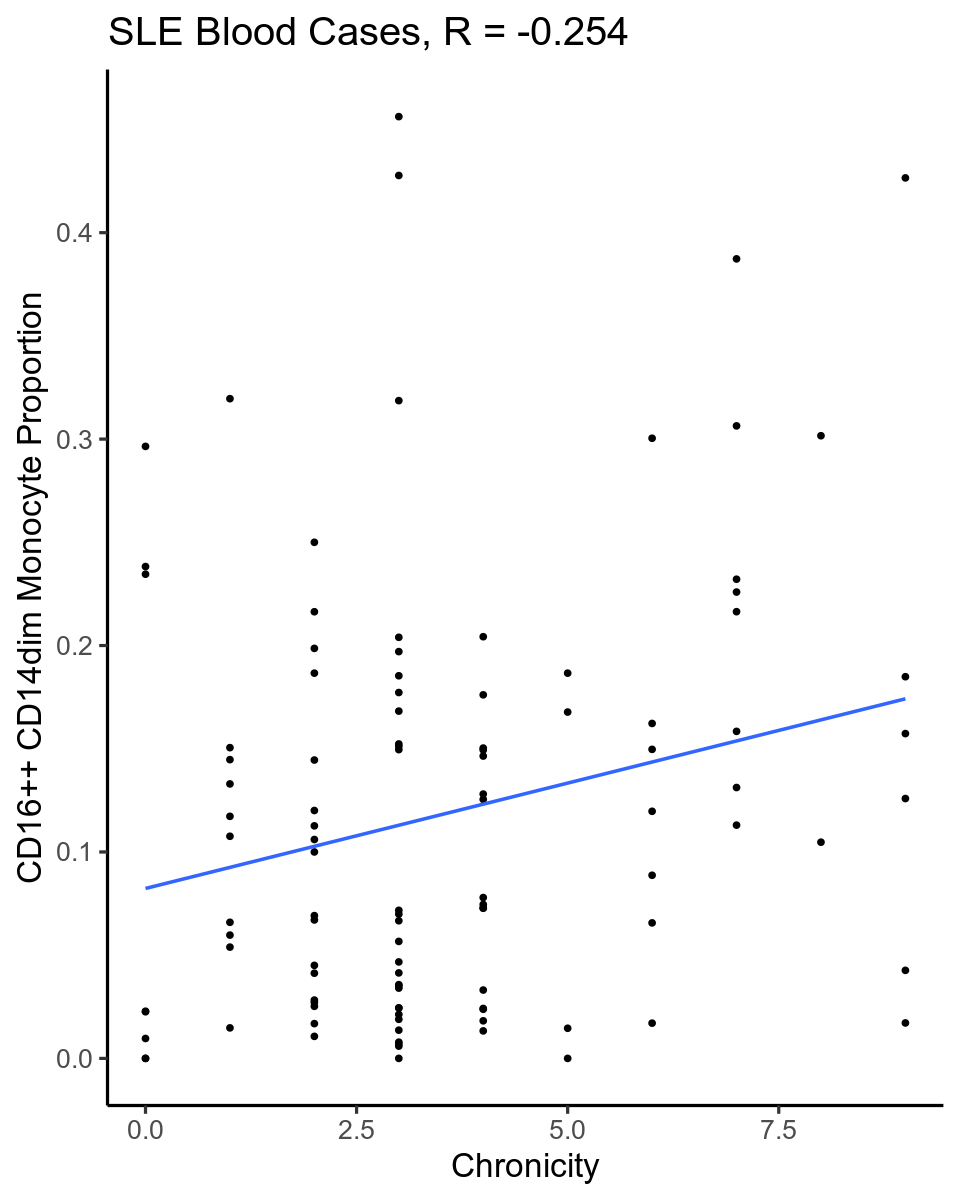

In [202]:
my_comparisons <- list(
                        c("2", "4"))

ggplot(ln_kidney_cell_state_freq,
        aes(x = factor(Chronicity_Quantile,
                          levels = c("1", "2", "3", "4")), y = ctl_freq, fill = Chronicity_Quantile)) + 
    geom_boxplot() + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5)) + 
    labs(x = "Chronicity Quantile", 
         y = "CD16++ CD14dim Monocyte Proportion",
         title = "Kidney") +
    scale_fill_viridis() + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) 

cor.test(ln_kidney_cell_state_freq$Final_Chronicity, ln_kidney_cell_state_freq$ctl_freq)

ggplot(ln_kidney_cell_state_freq, aes(x = Final_Chronicity, y = ctl_freq)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "Chronicity", y = "CD16++ CD14dim Monocyte Proportion",
         title = "LN Kidney Cases, R = -0.254") + 
    geom_smooth(method = "lm", se = FALSE)
 

my_comparisons <- list(
                        c("2", "4"))

ggplot(sle_blood_cell_state_freq,
        aes(x = as.character(Chronicity_Quantile), y = ctl_freq, fill = Chronicity_Quantile)) + 
    geom_boxplot() + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5)) + 
    labs(x = "Chronicity Quantile", 
         y = "CD16++ CD14dim Monocyte Proportion",
         title = "Blood") + 
    scale_fill_viridis() + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) 

cor.test(sle_blood_cell_state_freq$Final_Chronicity, sle_blood_cell_state_freq$ctl_freq)

ggplot(sle_blood_cell_state_freq, aes(x = Final_Chronicity, y = ctl_freq)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "Chronicity", y = "CD16++ CD14dim Monocyte Proportion",
         title = "SLE Blood Cases, R = -0.254") + 
    geom_smooth(method = "lm", se = FALSE)

In [210]:
ln_kidney_cell_state_freq <- kidney_immune_meta %>% 
                            filter(Type == "LN",
                                   broad_cell_type %in% c("Myeloid Cell")) %>% 
                            select(new_cluster_number, sample) %>% table()  %>% 
                            data.frame() %>% pivot_wider(names_from = "new_cluster_number",
                                                         values_from = "Freq")

ln_kidney_cell_state_freq$total <- rowSums(ln_kidney_cell_state_freq[, -1])
ln_kidney_cell_state_freq$ctl_freq <- rowSums(ln_kidney_cell_state_freq[, c('20')]) / ln_kidney_cell_state_freq$total
ln_kidney_cell_state_freq <- ln_kidney_cell_state_freq %>% 
                                        left_join(kidney_immune_meta %>% select(sample, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(sample, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>% 
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 4)) 

Joining, by = "sample"
Joining, by = "individual"


In [ ]:
sle_blood_cell_state_freq <- SLE_pbmc_meta %>% 
                                    filter(Type == "SLE") %>% 
                                    select(RNA_snn_res.0.5, Unified_Visit) %>% table()  %>% 
                                    data.frame() %>% pivot_wider(names_from = "RNA_snn_res.0.5",
                                                         values_from = "Freq")

sle_blood_cell_state_freq$total <- rowSums(sle_blood_cell_state_freq[, -1])
sle_blood_cell_state_freq$ctl_freq <- rowSums(sle_blood_cell_state_freq[, c('7')]) / sle_blood_cell_state_freq$total
sle_blood_cell_state_freq <- sle_blood_cell_state_freq %>%
                                        left_join(SLE_pbmc_meta %>% select(Unified_Visit, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(Unified_Visit, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>% 
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 4)) 

## ISG HIGH 

In [ ]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata.rds')

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control"))


sle_blood_cell_state_freq <- SLE_pbmc_meta %>% 
                                    filter(Type == "SLE") %>% 
                                    select(RNA_snn_res.0.75, Unified_Visit) %>% table()  %>% 
                                    data.frame() %>% pivot_wider(names_from = "RNA_snn_res.0.75",
                                                         values_from = "Freq")

sle_blood_cell_state_freq$total <- rowSums(sle_blood_cell_state_freq[, -c(1, 5 ,6)])
sle_blood_cell_state_freq$ctl_freq <- rowSums(sle_blood_cell_state_freq[, c('7')]) / sle_blood_cell_state_freq$total
sle_blood_cell_state_freq <- sle_blood_cell_state_freq %>%
                                        left_join(SLE_pbmc_meta %>% select(Unified_Visit, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(Unified_Visit, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>% 
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 4)) 

Joining, by = "Unified_Visit"
Joining, by = "individual"


[1] FALSE



	Pearson's product-moment correlation

data:  sle_blood_cell_state_freq$Final_Chronicity and sle_blood_cell_state_freq$ctl_freq
t = -1.3282, df = 106, p-value = 0.187
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.30943561  0.06254292
sample estimates:
       cor 
-0.1279432 


`geom_smooth()` using formula = 'y ~ x'


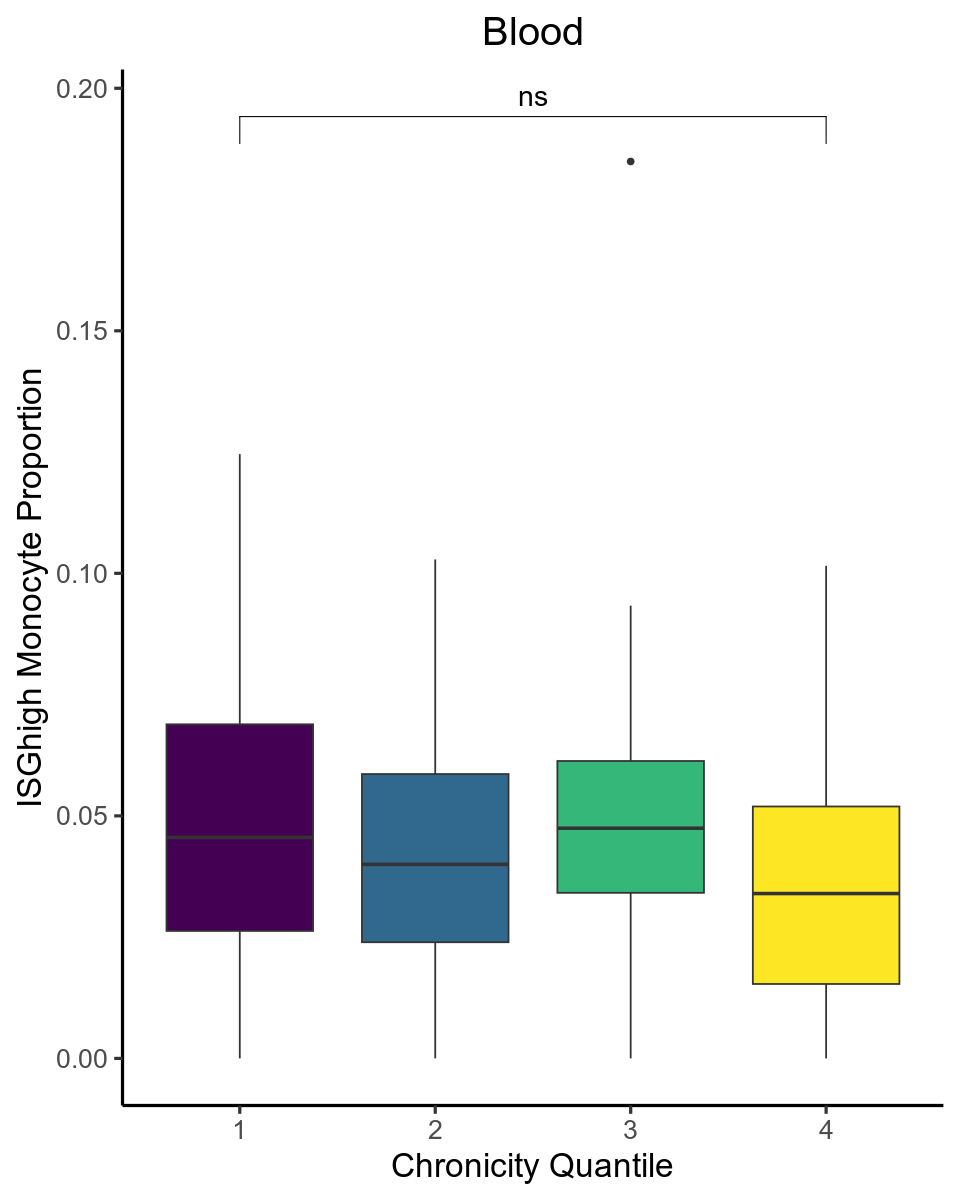

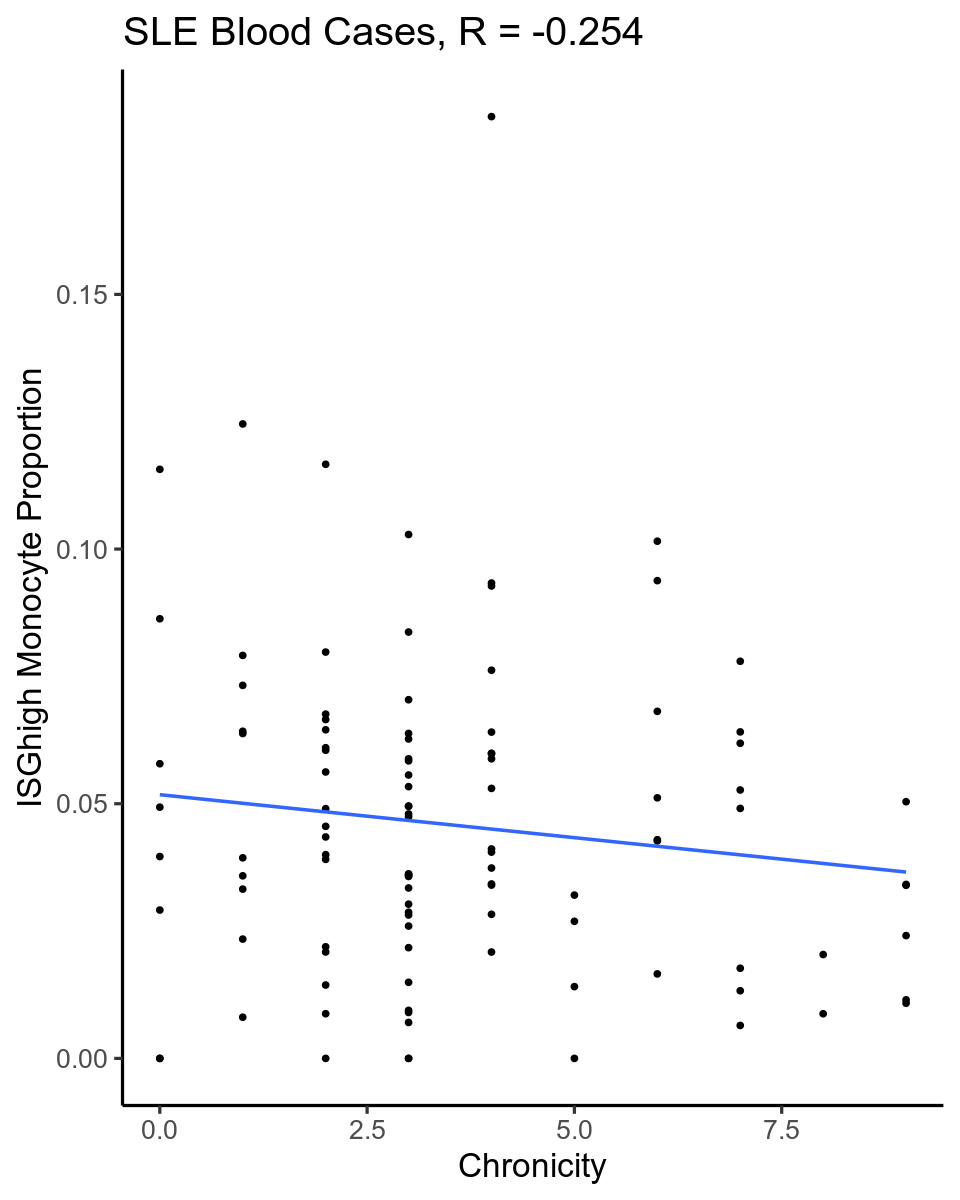

In [217]:
my_comparisons <- list(
                        c("1", "4"))

ggplot(sle_blood_cell_state_freq,
        aes(x = as.character(Chronicity_Quantile), y = ctl_freq, fill = Chronicity_Quantile)) + 
    geom_boxplot() + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5)) + 
    labs(x = "Chronicity Quantile", 
         y = "ISGhigh Monocyte Proportion",
         title = "Blood") + 
    scale_fill_viridis() + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) 

cor.test(sle_blood_cell_state_freq$Final_Chronicity, sle_blood_cell_state_freq$ctl_freq)

ggplot(sle_blood_cell_state_freq, aes(x = Final_Chronicity, y = ctl_freq)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "Chronicity", y = "ISGhigh Monocyte Proportion",
         title = "SLE Blood Cases, R = -0.254") + 
    geom_smooth(method = "lm", se = FALSE)

In [221]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_metadata.rds')

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control"))


sle_blood_cell_state_freq <- SLE_pbmc_meta %>% 
                                    filter(Type == "SLE") %>% 
                                    select(RNA_snn_res.0.25, Unified_Visit) %>% table()  %>% 
                                    data.frame() %>% pivot_wider(names_from = "RNA_snn_res.0.25",
                                                         values_from = "Freq")

sle_blood_cell_state_freq$total <- rowSums(sle_blood_cell_state_freq[, -c(1)])
sle_blood_cell_state_freq$ctl_freq <- rowSums(sle_blood_cell_state_freq[, c('4')]) / sle_blood_cell_state_freq$total
sle_blood_cell_state_freq <- sle_blood_cell_state_freq %>%
                                        left_join(SLE_pbmc_meta %>% select(Unified_Visit, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(Unified_Visit, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>% 
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 4)) 

Joining, by = "Unified_Visit"
Joining, by = "individual"


[1] FALSE



	Pearson's product-moment correlation

data:  sle_blood_cell_state_freq$Final_Chronicity and sle_blood_cell_state_freq$ctl_freq
t = -2.987, df = 104, p-value = 0.003514
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.44783605 -0.09545665
sample estimates:
       cor 
-0.2810937 


`geom_smooth()` using formula = 'y ~ x'


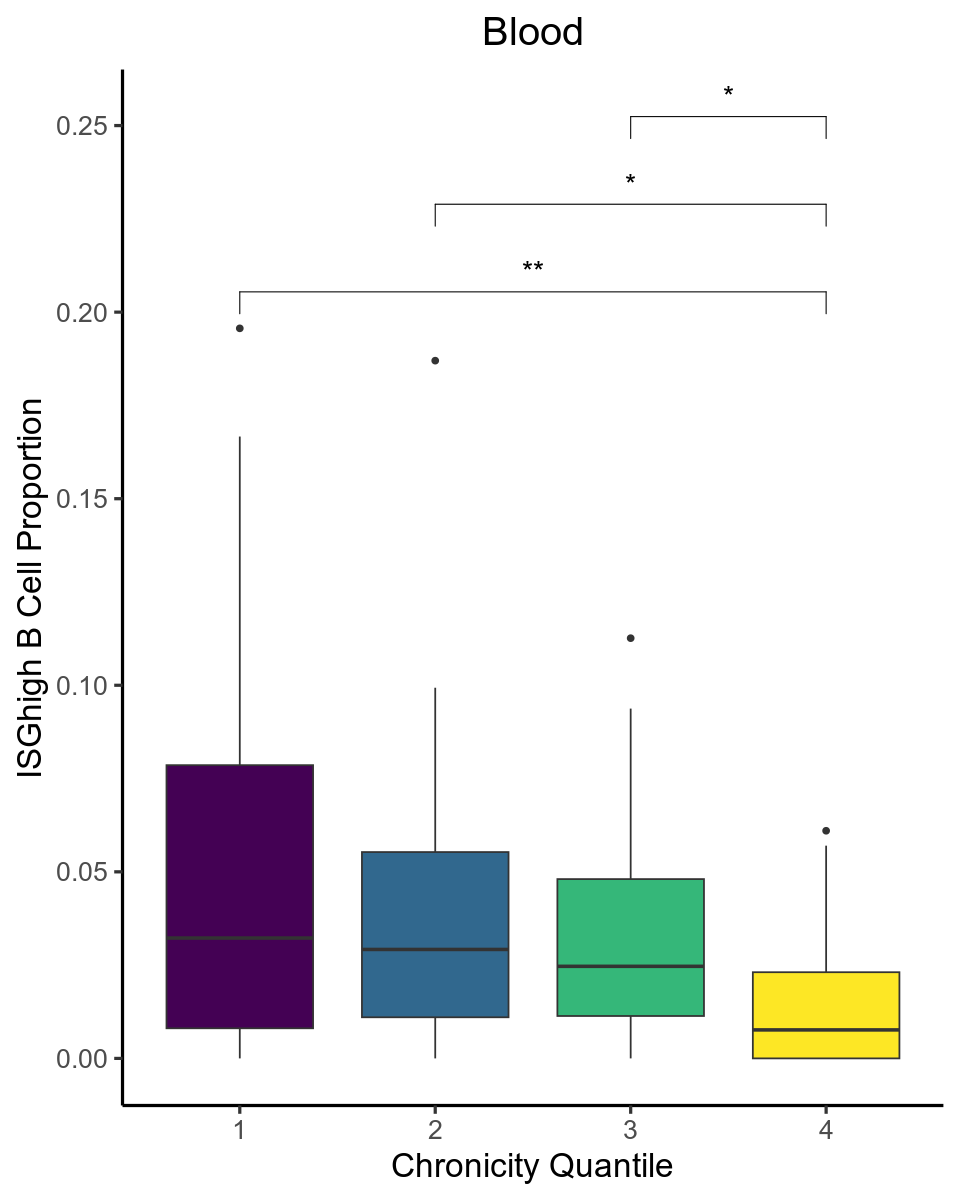

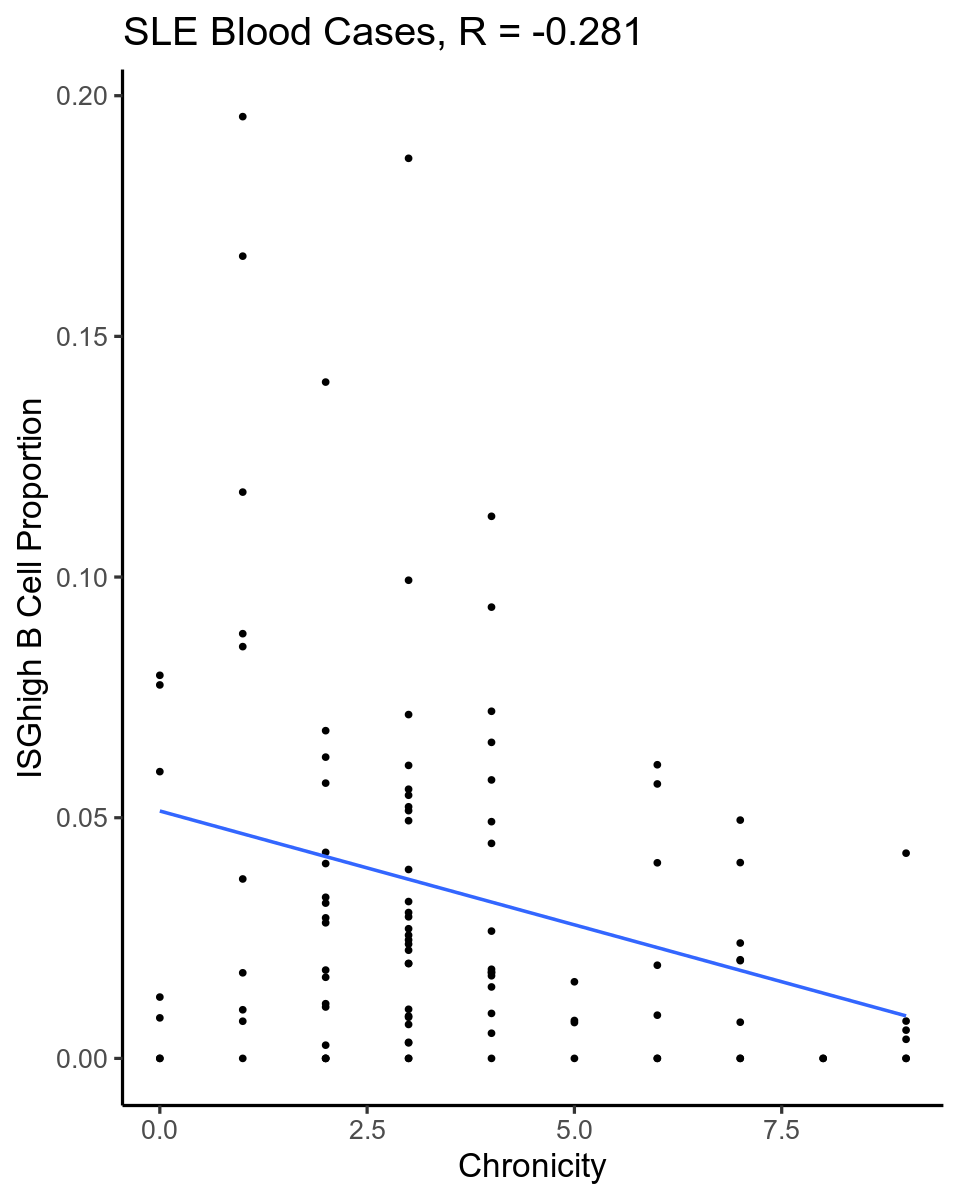

In [231]:
my_comparisons <- list(
                        c("1", "4"),
                        c("2", "4"),
                        c("3", "4"))

ggplot(sle_blood_cell_state_freq,
        aes(x = as.character(Chronicity_Quantile), y = ctl_freq, fill = Chronicity_Quantile)) + 
    geom_boxplot() + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5)) + 
    labs(x = "Chronicity Quantile", 
         y = "ISGhigh B Cell Proportion",
         title = "Blood") + 
    scale_fill_viridis() + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) 

cor.test(sle_blood_cell_state_freq$Final_Chronicity, sle_blood_cell_state_freq$ctl_freq)

ggplot(sle_blood_cell_state_freq, aes(x = Final_Chronicity, y = ctl_freq)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "Chronicity", y = "ISGhigh B Cell Proportion",
         title = "SLE Blood Cases, R = -0.281") + 
    geom_smooth(method = "lm", se = FALSE)

In [239]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata.rds')

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control"))


sle_blood_cell_state_freq <- SLE_pbmc_meta %>% 
                                    filter(Type == "SLE") %>% 
                                    select(RNA_snn_res.0.75, Unified_Visit) %>% table()  %>% 
                                    data.frame() %>% pivot_wider(names_from = "RNA_snn_res.0.75",
                                                         values_from = "Freq")

sle_blood_cell_state_freq$total <- rowSums(sle_blood_cell_state_freq[, -c(1)])
sle_blood_cell_state_freq$ctl_freq <- rowSums(sle_blood_cell_state_freq[, c('13')]) / sle_blood_cell_state_freq$total
sle_blood_cell_state_freq <- sle_blood_cell_state_freq %>%
                                        left_join(SLE_pbmc_meta %>% select(Unified_Visit, individual) %>% unique()) %>% 
                                        left_join(clinical_LN %>% select(individual, Final_Chronicity)) %>% 
                                        select(Unified_Visit, individual, Final_Chronicity, ctl_freq) %>% 
                                        na.omit() %>% 
                                        mutate(Chronicity_Quantile = ntile(Final_Chronicity, n = 4)) 

Joining, by = "Unified_Visit"
Joining, by = "individual"


[1] FALSE



	Pearson's product-moment correlation

data:  sle_blood_cell_state_freq$Final_Chronicity and sle_blood_cell_state_freq$ctl_freq
t = 0.43208, df = 108, p-value = 0.6665
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1468428  0.2270165
sample estimates:
       cor 
0.04154082 


`geom_smooth()` using formula = 'y ~ x'


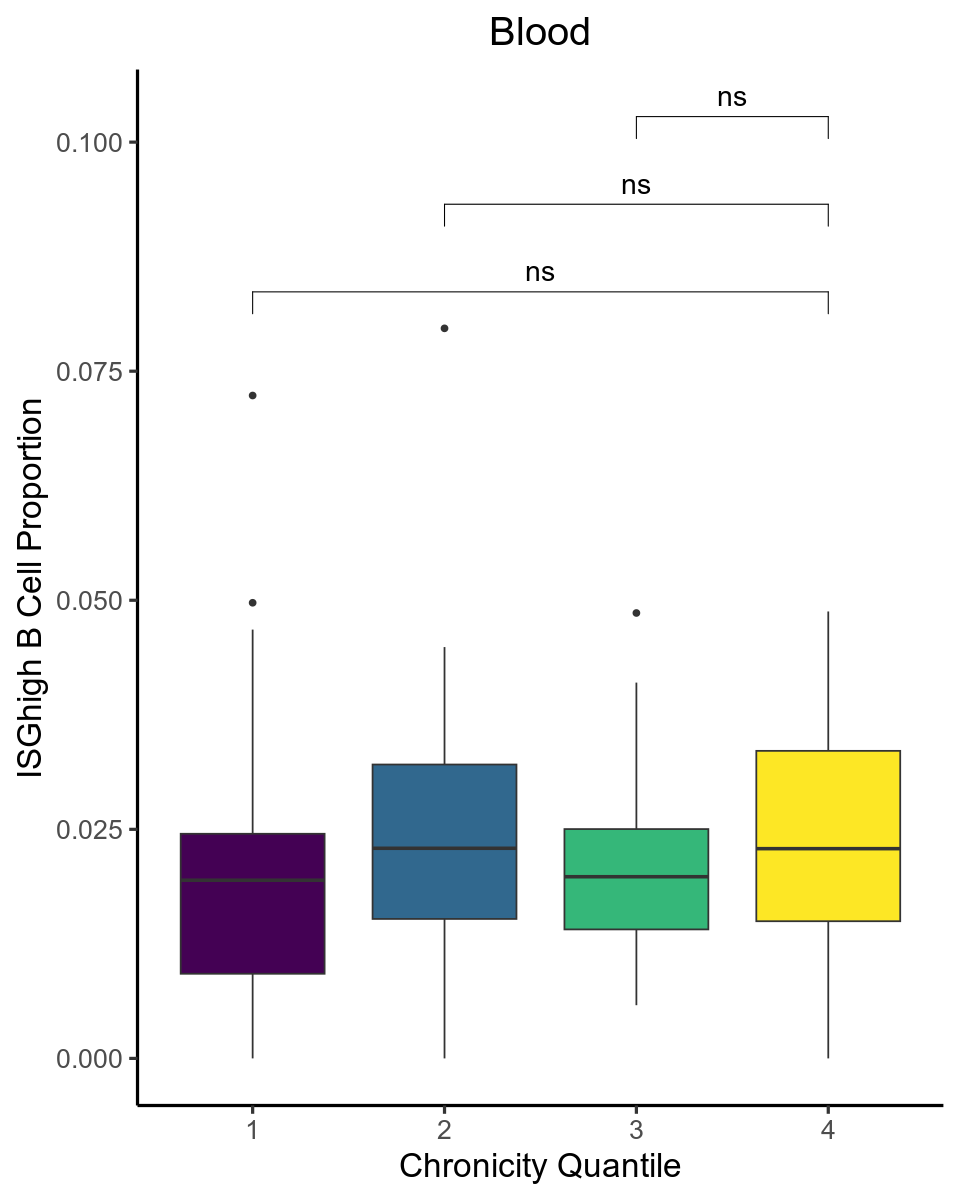

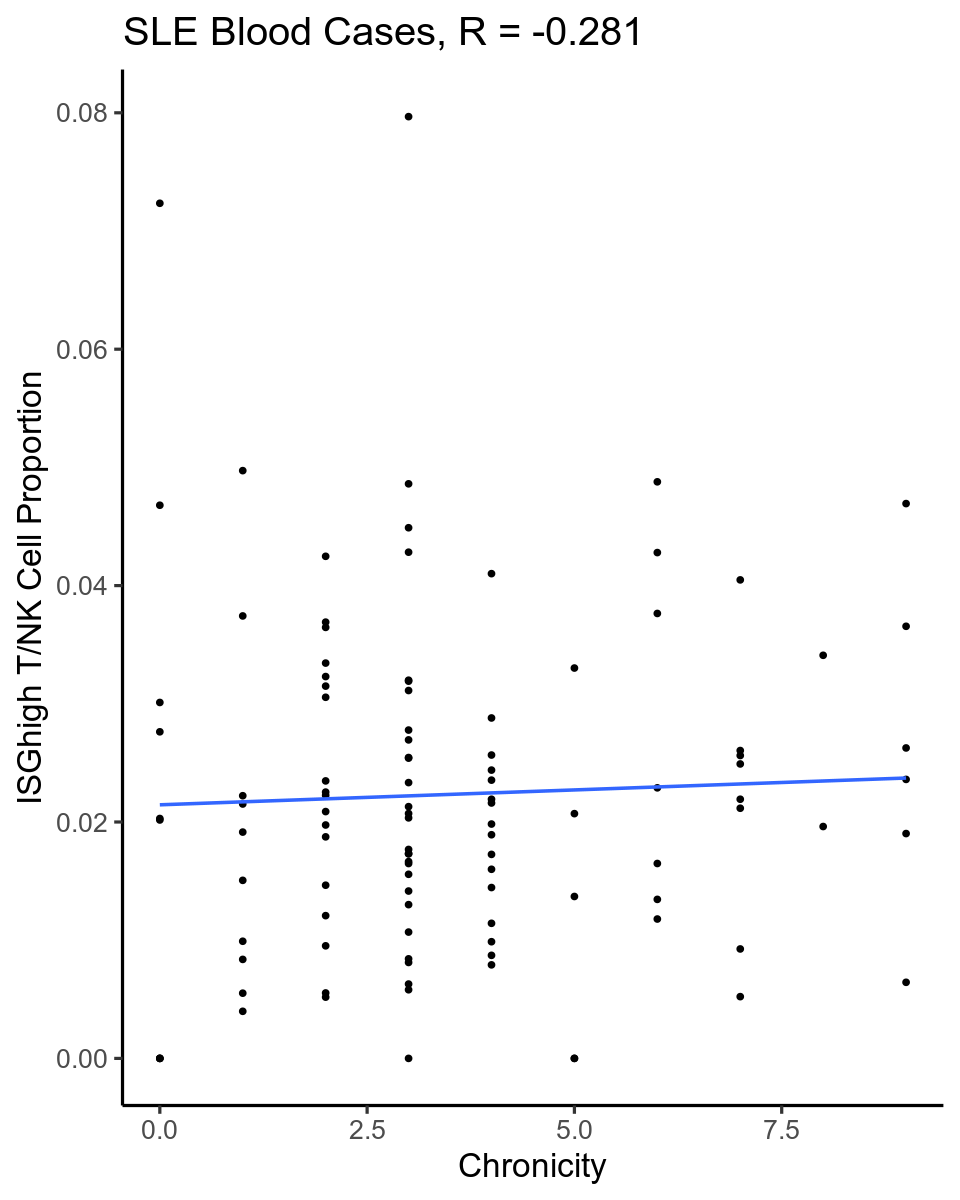

In [240]:
my_comparisons <- list(
                        c("1", "4"),
                        c("2", "4"),
                        c("3", "4"))

ggplot(sle_blood_cell_state_freq,
        aes(x = as.character(Chronicity_Quantile), y = ctl_freq, fill = Chronicity_Quantile)) + 
    geom_boxplot() + 
    theme_classic(base_size = 20) + 
    theme(legend.position = "none",
          plot.title = element_text(hjust = 0.5)) + 
    labs(x = "Chronicity Quantile", 
         y = "ISGhigh B Cell Proportion",
         title = "Blood") + 
    scale_fill_viridis() + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6) 

cor.test(sle_blood_cell_state_freq$Final_Chronicity, sle_blood_cell_state_freq$ctl_freq)

ggplot(sle_blood_cell_state_freq, aes(x = Final_Chronicity, y = ctl_freq)) + 
    geom_point() + 
    theme_classic(base_size = 20) + 
    labs(x = "Chronicity", y = "ISGhigh T/NK Cell Proportion",
         title = "SLE Blood Cases, R = -0.281") + 
    geom_smooth(method = "lm", se = FALSE)

# CNA PREP - ALL PBMCS

In [108]:
tnk_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata.rds')
mono_dc_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata_new.rds')
bcell_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_metadata.rds')
final_cell_list <- c(tnk_pbmc_meta$Cell, mono_dc_pbmc_meta$Cell, bcell_pbmc_meta$Cell)

In [109]:
norm <- readRDS('/data/srlab/ssg34/SLE_pbmc_analysis/data/gene_expression/demux_cell_qcd_gex_seurat_sc_analysis_08232023.rds')[['RNA']]@data
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_pbmc_metadata.rds')
SLE_harmony <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_pbmc_hPCs.rds')
SLE_umap <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_pbmc_umap.rds')

In [110]:
SLE_donors <- read.csv('/data/srlab/ssg34/SLE_pbmc/lupus_pbmcs/sequencing_meta/samples.csv', check.names = FALSE)

In [9]:
SLE_pbmc_meta <- cbind(SLE_pbmc_meta, SLE_umap) %>% 
                    filter(Cell %in% final_cell_list)

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() 

SLE_pbmc_LN <- SLE_pbmc_meta %>% 
                    filter(Type == "SLE", individual %in% kidney_immune_meta$individual) 
SLE_pbmc_control <- SLE_pbmc_meta %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control")) %>% 
                        filter(Type == "Control")
filtered_meta <- rbind(SLE_pbmc_LN, SLE_pbmc_control)

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `individual %in% kidney_immune_meta$individual`.
[1mCaused by error in `individual %in% kidney_immune_meta$individual`:[22m
[33m![39m object 'kidney_immune_meta' not found


In [8]:
# saveRDS(filtered_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_all_pbmc_metadata_filtered_V0_cases_controls_07182024.rds')

In [111]:
filtered_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_all_pbmc_metadata_filtered_V0_cases_controls_07182024.rds')

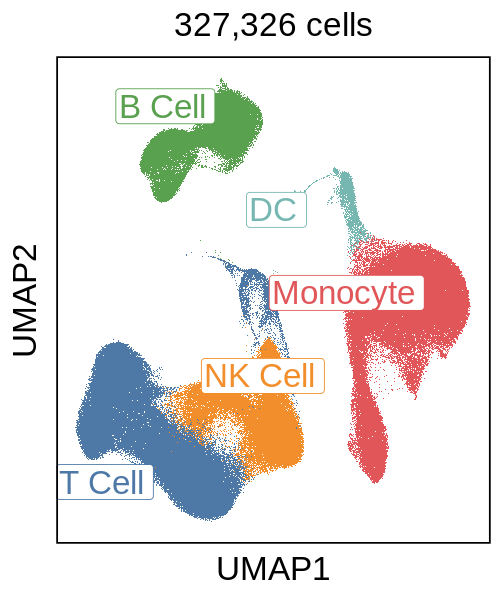

In [104]:
ncells = filtered_meta %>% nrow
cluster_center <- filtered_meta %>%
                  group_by(broad.ids) %>%
                  summarise_at(vars(UMAP_1, UMAP_2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

p <- ggplot() +
  geom_point(
    data = filtered_meta[sample(nrow(filtered_meta)), ] %>% 
      select(UMAP_1, UMAP_2, broad.ids) %>% 
              mutate(broad.ids = as.factor(broad.ids)),
    aes(x = UMAP_1, y = UMAP_2, color = broad.ids),
    size = 0.4, shape = 20, stroke = 0.0001) +
ggrepel::geom_label_repel(hjust = 0,
        data = cluster_center,
        aes(x = UMAP_1, y = UMAP_2, 
            label = broad.ids, color = broad.ids),
        size = 7,  
        box.padding = unit(1, "lines"),
        point.padding = unit(0.2, "lines"),
          show.legend = FALSE,
      ) +
    ggthemes::scale_color_tableau(direction = -1) +
theme_classic(base_size = tickfontsize) +
  theme(
    legend.position = "none",
         plot.title = element_text(size = labelfontsize, hjust = 0.5),
          axis.title = element_text(size = labelfontsize), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          text=element_text(family="Arial")
  )+
        labs(x = "UMAP1", y = "UMAP2", 
             title = paste0(format(ncells,big.mark=",",scientific=FALSE), ' cells')) +
        guides(color = guide_legend(ncol = 1, override.aes = list(size = 8)))

outplot = p

height = 5
width = 4.2
fig.size(height, width)
outplot

ggsave(paste0(figdir, 'pbmc_umap_sc.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pbmc_umap_sc.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


In [112]:
qcd_meta = filtered_meta
qcd_norm = norm

In [113]:
markers = c('CD3D', 'NCAM1','LYZ', 'MS4A1')

In [114]:
qcd_scaled = qcd_norm[markers, ] %>% scaleData
vmax = qcd_scaled %>% quantile(.95)
vmin = qcd_scaled %>% quantile(.05)

In [118]:
qcd_meta$cell = qcd_meta$Cell
qcd_meta = qcd_meta %>% mutate(hUMAP1 = UMAP_1, hUMAP2 = UMAP_2)

In [117]:
qcd_meta %>% head(2)

orig.ident    nCount_RNA nFeature_RNA BARCODE            percent.mt SNG.1ST 
1 SeuratProject 6070       2472         AAACCCAAGAAGTCTA-1 5.107084   200-2741
2 SeuratProject 9129       2884         AAACCCAAGCCGCACT-1 4.469274   200-2729
  Channel Cell                         Batch Scrublet_Sample ⋯ RNA_snn_res.0.25
1 2       channel_2_AAACCCAAGAAGTCTA-1 1     200-2741_1      ⋯ 3               
2 2       channel_2_AAACCCAAGCCGCACT-1 1     200-2729_1      ⋯ 4               
  seurat_clusters RNA_snn_res.0.1 cell.type.ids broad.ids mono.ids UMAP_1   
1 2               2               NK Cell       NK Cell   Lymphoid  1.447459
2 3               3               B Cell        B Cell    Lymphoid -1.792289
  UMAP_2    Type individual
1 -5.024845 SLE  2741      
2 12.064863 SLE  2729

In [124]:
p = plot_shuffled_features(qcd_meta, qcd_scaled, markers[1], pt_size = 1, max.cutoff = vmax,
                          min.cutoff = vmin)
p1 = p + theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
               theme(text=element_text(family="Arial")),
              legend.position = "none") + labs(x = 'UMAP1', y = 'UMAP2')

p = plot_shuffled_features(qcd_meta, qcd_scaled, markers[2], pt_size = 1, max.cutoff = vmax,
                          min.cutoff = vmin)
p2 = p + theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
               theme(text=element_text(family="Arial")),
              legend.position = "none") + labs(x = 'UMAP1', y = 'UMAP2')

p = plot_shuffled_features(qcd_meta, qcd_scaled, markers[3], pt_size = 1, max.cutoff = vmax,
                          min.cutoff = vmin)
p3 = p + theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
               theme(text=element_text(family="Arial")),
              legend.position = "none") + labs(x = 'UMAP1', y = 'UMAP2')

p = plot_shuffled_features(qcd_meta, qcd_scaled, markers[4], pt_size = 1, max.cutoff = vmax,
                          min.cutoff = vmin)
p4 = p + theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
               theme(text=element_text(family="Arial")),
              legend.position = "none") + labs(x = 'UMAP1', y = 'UMAP2')

umap_legend = get_legend(p +theme(legend.text = element_text(size = labelfontsize-2),
                legend.title = element_text(size = labelfontsize),
                plot.title = element_text(hjust = 0.5, size = labelfontsize),
                theme(text=element_text(family="Arial"))))
umap_legend = cowplot::plot_grid(umap_legend) 

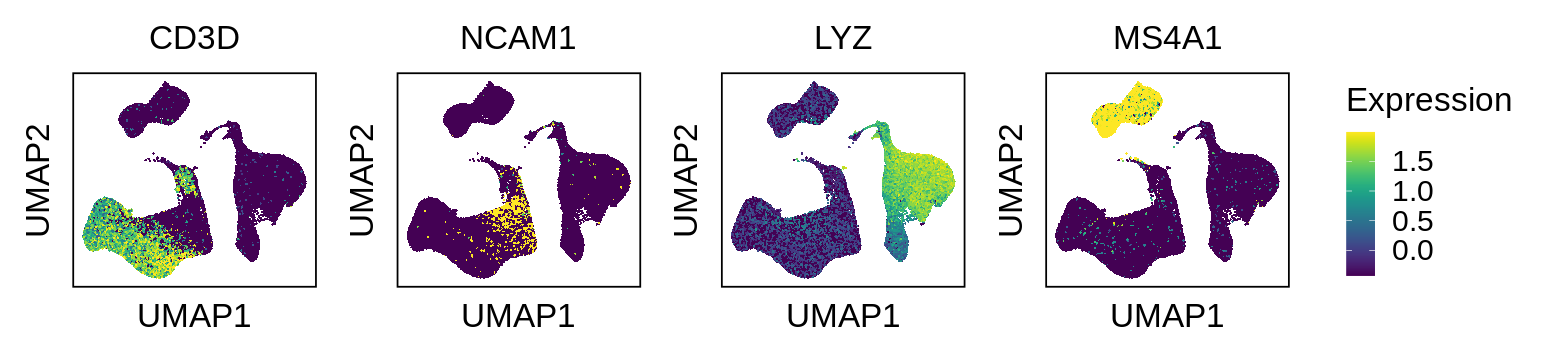

In [125]:
# height = 3
# width = 13
# fig.size(height, width)

# outplot = p1 + p2 + p3 + p4 + umap_legend + plot_layout(nrow = 1)
# outplot

# # ggsave(paste0(figdir, 'pbmc_umap_markers.png'), plot = outplot,  
# #        height = height, width = width, dpi = 500)
# # ggsave(paste0(figdir, 'pbmc_umap_markers.pdf'), plot = outplot,  
# #        height = height, width = width, dpi = 500, device = cairo_pdf)

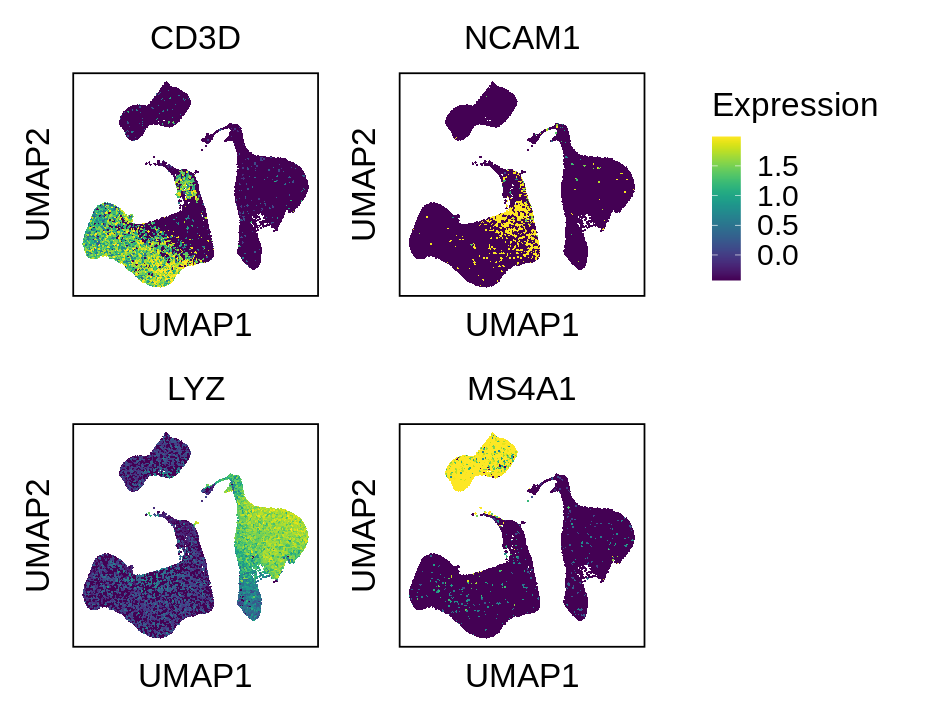

In [132]:
height = 6
width = 7.8
fig.size(height, width)

outplot = p1 + p2 + umap_legend + p3 + p4 + plot_spacer() + plot_layout(nrow = 2, ncol = 3)
outplot

ggsave(paste0(figdir, 'pbmc_umap_markers.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pbmc_umap_markers.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

## CASE/CONTROL

In [69]:
SLE_pbmc_meta <- filtered_meta %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame()

In [70]:
SLE_pbmc_LN <- SLE_pbmc_meta %>% 
                    filter(Type == "SLE", individual %in% kidney_immune_meta$individual) 
SLE_pbmc_control <- SLE_pbmc_meta %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control")) %>% 
                        filter(Type == "Control")

In [71]:
SLE_pbmc_case_control <- rbind(SLE_pbmc_LN, SLE_pbmc_control)
SLE_pbmc_case_control <- SLE_pbmc_case_control %>% left_join(clinical)

Joining, by = c("Type", "individual")


In [88]:
meta <- SLE_pbmc_case_control

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta <- meta %>% mutate(Type = ifelse(Type == "SLE", 1, 0))

meta$Age <- as.numeric(meta$Age)
meta$Sex <- as.numeric(meta$Sex)

meta <- meta %>% select(Unified_Visit, Type, Age, Sex)



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/umap.csv', 
          row.names = FALSE, quote = FALSE)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


### RESULTS

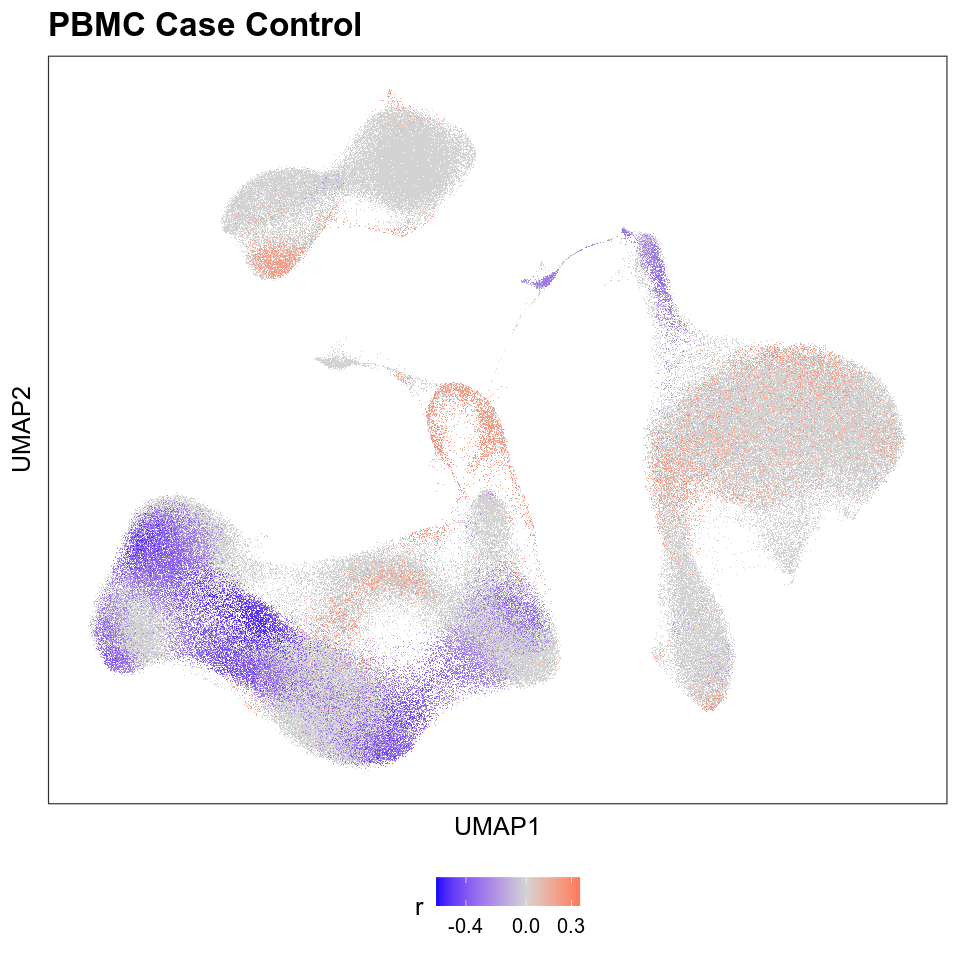

In [16]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(
      data = tmp_meta %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation),
        size = 0.1, shape = 20, stroke = 0.0001) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red',
                            na.value = "lightgrey", name = "r",
                            breaks = c(-0.4, 0, 0.3)) + 
      labs(x="UMAP1", y="UMAP2", title = "PBMC Case Control") +
      theme_bw(base_size = 15) +
  theme( legend.position = "bottom",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", face = "bold", size=20)
  ) 

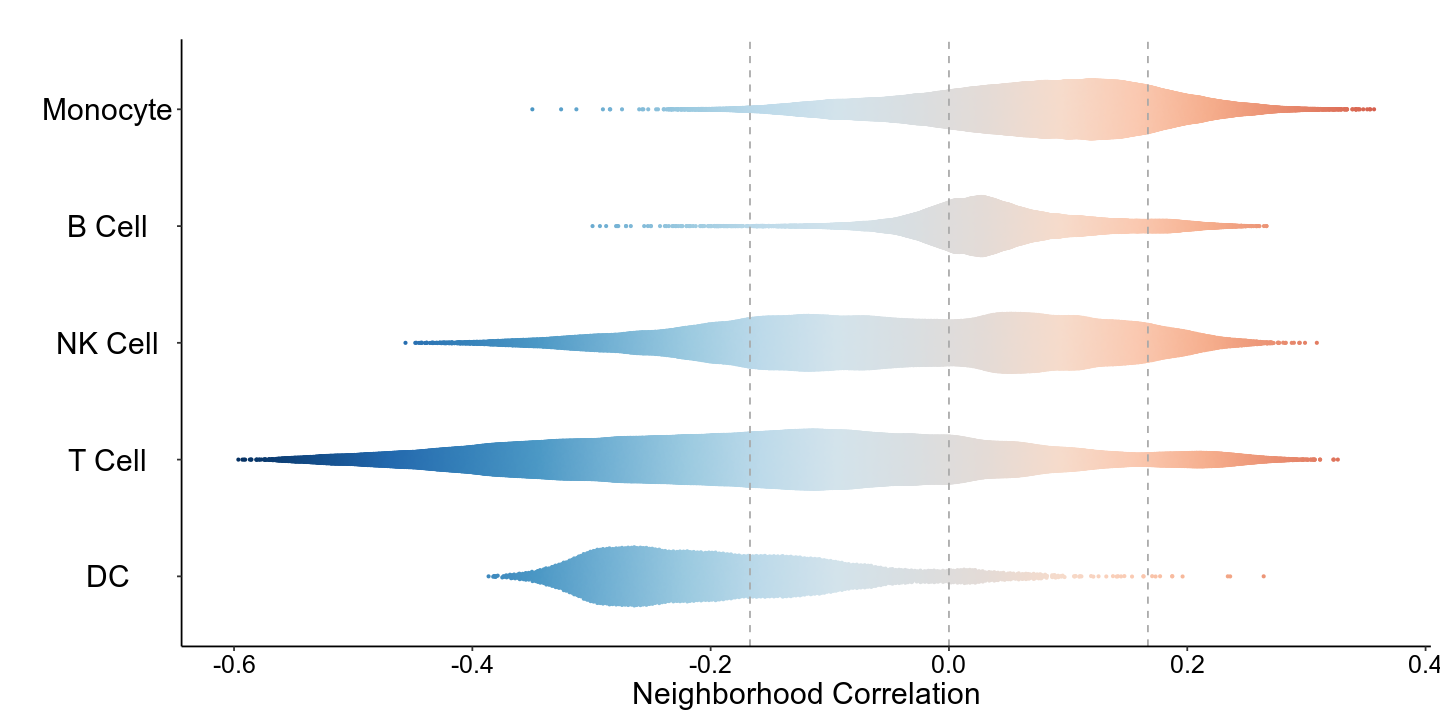

In [19]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/case_control/fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)


pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)

ggplot(meta,  aes(y = reorder(broad.ids, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
#   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5)) 

### COMBINED PER CELL TYPE DE

In [4]:
tnk_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/tnk_case_control_differential_expression_pbmc_010422024.rds')
mono_dc_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/myeloid_case_control_differential_expression_pbmc_010422024.rds')
bcell_de <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/bcell_case_control_differential_expression_pbmc_010422024.rds')

In [5]:
tnk_de <- tnk_de %>% 
                na.omit() %>% 
                mutate(FDR = p.adjust(LRP, "BH"),
                       cell.type = "T/NK") %>% 
                filter(FDR < 0.05)
mono_dc_de <- mono_dc_de %>% 
                na.omit() %>% 
                mutate(FDR = p.adjust(LRP, "BH"),
                       cell.type = "Mono/DC") %>% 
                filter(FDR < 0.05)
bcell_de <- bcell_de %>% 
                na.omit() %>% 
                mutate(FDR = p.adjust(LRP, "BH"),
                       cell.type = "B Cell") %>% 
                filter(FDR < 0.05)

In [9]:
de_df <- rbind(tnk_de, mono_dc_de, bcell_de)
de_df <- de_df[, c("gene", "LRP", "F", "Beta", "SE", "FDR", "cell.type")]

In [11]:
write.csv(de_df, 
          '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/all_de_pbmc_case_control_res_SupplementaryTable4_05162024.csv',
          quote = FALSE, row.names = FALSE)

In [217]:
genes <- c("ISG15", "IFI6", "IFI44L", "CD55", "STAT1",
            "LY6E", "NEAT1", "COMMD6", "IL4R")

In [219]:
all_de %>% filter(gene == "IL4R")

gene LRP          F        Beta       SE         FDR         cell.type
1 IL4R 2.175818e-05 19.47632 -0.2524865 0.05721168 0.009705351 B Cell

## WITHIN CASES

In [172]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% filter(Donor %in% clinical_LN$AMP.Subject_ID) 

In [173]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [174]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                            left_join(clinical_LN) %>% 
                            left_join(first_biop_pred) %>% 
                            select(c(Cell, BARCODE, Sex, cell.type.ids, Unified_Visit, Donor,
                                     Responder.Status, Age, Race, Final_ISN, 
                                     Final_Chronicity, Final_Activity, Type, Final_Site,
                                     First_biop, Pred_use, individual))  %>% 
                            rename(AMP.Subject_ID = Donor)

Joining, by = "individual"
Joining, by = "individual"


## AGE

In [126]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/age/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/age/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/age/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## SEX

In [127]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)


meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/sex/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/sex/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/sex/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## RESPONSE

In [114]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/response/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/response/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/response/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## RACE

In [129]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/race/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/race/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/race/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## FIRST BIOPSY

In [136]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/first_biop/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/first_biop/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/first_biop/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## PREDNISONE USE

In [131]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/pred_use/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/pred_use/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/pred_use/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## SITE

In [132]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/site/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/site/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/site/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## CHRONICITY

In [113]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/chronicity/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/chronicity/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/chronicity/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## ACTIVITY

In [134]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/activity/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/activity/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/activity/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## ISN

In [115]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESULTS

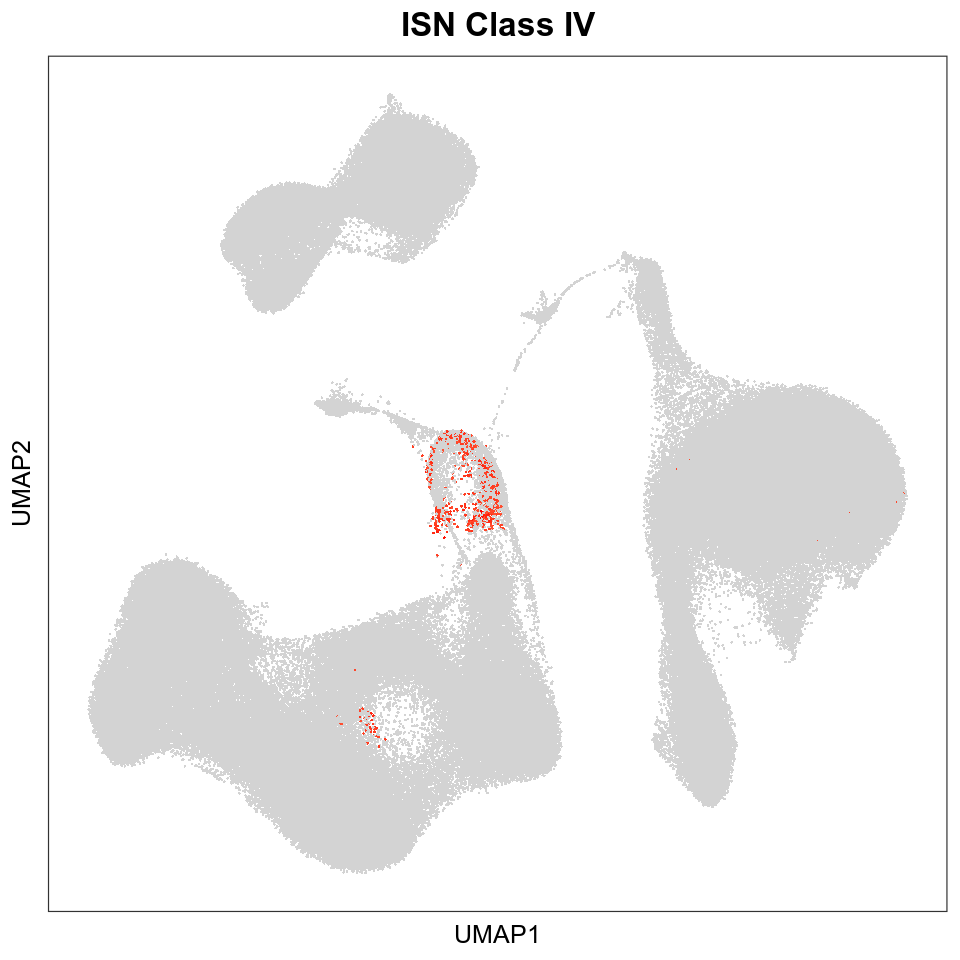

In [118]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/cond_class_4_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/cond_class_4_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(
      data = tmp_meta %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation),
        size = 0.75, stroke = 0.00001) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "ISN Class IV") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

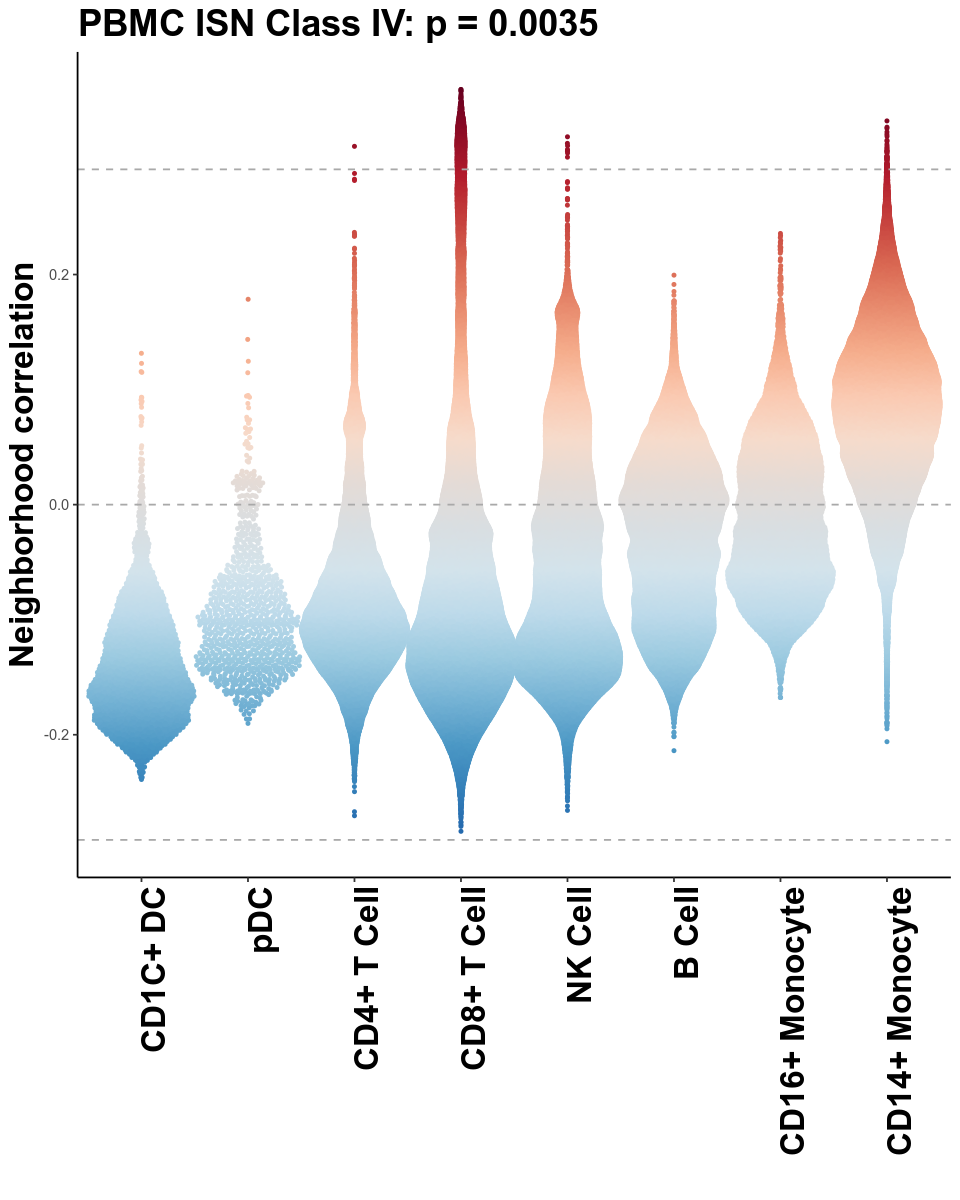

In [121]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/cond_class_4_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/isn/cond_class_4_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

ggplot(meta, aes(x = reorder(cell.type.ids, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation",
        title = "PBMC ISN Class IV: p = 0.0035") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(angle = 90, hjust = 1, color = "black", size = 20, face = "bold"),
        axis.title = element_text(size=20, face = "bold")) 

## INJURED PT

In [81]:
sc_pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/sc_injured_pt_prop_07142023.rds')

In [87]:
sc_pt_meta <- sc_pt_meta %>% mutate(individual = unlist(str_split(sample, "_"))[3])

In [88]:
meta <- SLE_pbmc_meta

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)

meta <- meta %>% left_join(sc_pt_meta)

ind <- c(1:nrow(meta))[!is.na(meta$injured_pt_prop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]


meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/injured_pt/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/injured_pt/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/injured_pt/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"
Joining, by = "individual"


# CNA PREP - T Cells

In [183]:
norm <- readRDS('/data/srlab/ssg34/SLE_pbmc_analysis/data/gene_expression/t_nk_qcd_seurat_sc_analysis_08252023.rds')[['RNA']]@data
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata.rds')
SLE_harmony <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_hPCs.rds')
SLE_umap <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_umap.rds')

In [184]:
annotations <- data.frame(RNA_snn_res.1 = as.character(seq(0, 19)),
                          annotation = c("bl-NK0. CD56dim CD16high FGFBP2high NK", 
                                         "bl-T1. CD8+ GZMHhigh FGFBP2high",
                                         "bl-T2. CD8+ GZMK+ CD74+ HLA-DR+",
                                         "bl-T3. CD4+ IL7Rhigh VIMhigh",
                                         "bl-T4. CD8+ MT-high",
                                         "bl-NK5. CD56bright NEAT1high PRF1high NK",
                                         "bl-NK6. CD56bright XCL2high IL2RBhigh NK",
                                         "bl-T7. CD8+ GZMK+ TEMRA", 
                                         "bl-T8. CD8+ Central Memory/Naive",
                                         "bl-T9. CD4+ Effector Memory",
                                         "bl-T10. CD4+ Central Memory/Naive", 
                                         "bl-T11. TRDC+ Gamma/Delta",
                                         "bl-T12. TRGC1+ Gamma/Delta", 
                                         "bl-T13. CD4+ MAF+ IT2MA+ Effector Memory",
                                         "bl-T14. CD8+ GZMK+ CD74high HLA-DRhigh",
                                         "bl-T15. CD8+ GZMB+ DNMT1+ HELLS+ Proliferating",
                                         "bl-T16. CD4+ T-reg",
                                         "bl-T17. ISGhigh",
                                         "bl-T18. CD8+ GZMB+ PCNAhigh Proliferating",
                                         "bl-T19. CD8+ GZMB+ CENPFhigh Proliferating"))

In [158]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata.rds')
SLE_pbmc_meta <- cbind(SLE_pbmc_meta, SLE_umap)
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame()


SLE_pbmc_LN <- SLE_pbmc_meta %>% 
                    filter(Type == "SLE", individual %in% kidney_immune_meta$individual) 

SLE_pbmc_control <- SLE_pbmc_meta %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control")) %>% 
                        filter(Type == "Control")

filtered_meta <- rbind(SLE_pbmc_LN, SLE_pbmc_control)
filtered_meta <- filtered_meta %>% left_join(annotations)
saveRDS(filtered_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata_filtered_V0_cases_controls_07182024.rds')

Joining, by = "RNA_snn_res.1"


In [185]:
filtered_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata_filtered_V0_cases_controls_07182024.rds')

In [186]:
# Update cluster names
filtered_meta= filtered_meta %>% select(-annotation) %>% left_join(annotations)

Joining with `by = join_by(RNA_snn_res.1)`


In [45]:
library(pals)



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis




In [76]:
annotations %>% nrow

[1] 20

In [180]:
name = 'T/NK'

In [181]:
ncells = filtered_meta %>% nrow

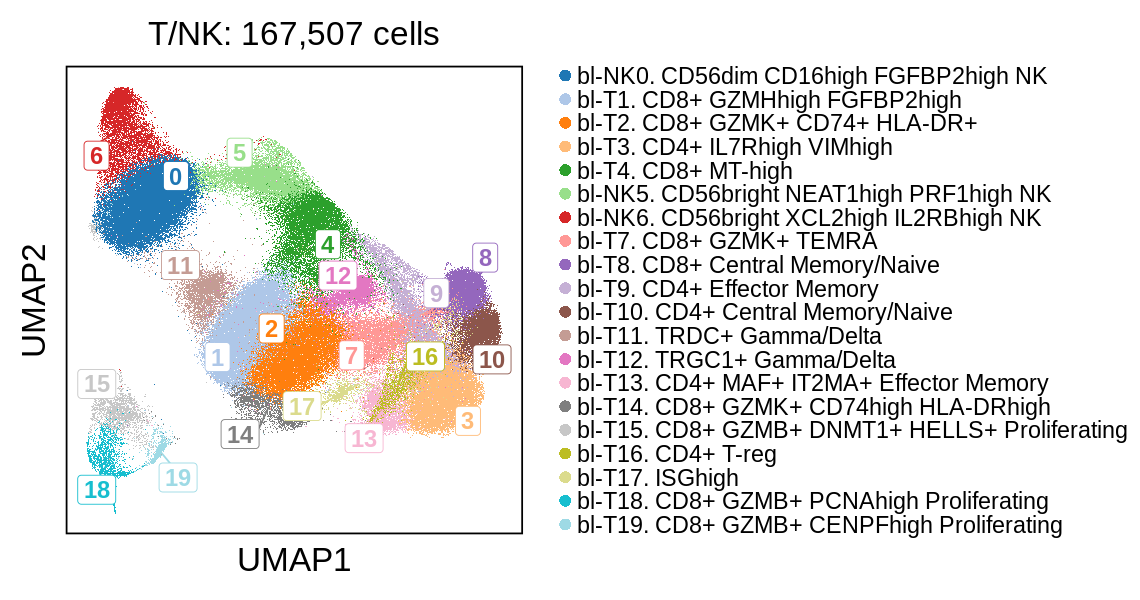

In [182]:
options(warn=-1)
cluster_center <- filtered_meta %>%
                  mutate(RNA_snn_res.1 = as.numeric(RNA_snn_res.1)) %>% 
                  group_by(RNA_snn_res.1, annotation) %>%
                  summarise_at(vars(UMAP_1, UMAP_2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

cluster_center <- cluster_center[order(cluster_center$RNA_snn_res.1), ]

options(repr.plot.height = 9, repr.plot.width = 18)
p <- ggplot() +
      geom_point(
        data = filtered_meta[sample(nrow(filtered_meta)), ] %>% 
          select(UMAP_1, UMAP_2, RNA_snn_res.1, annotation) %>% 
                  mutate(annotation = factor(annotation, 
                                                   levels = cluster_center$annotation)),
        aes(x = UMAP_1, y = UMAP_2, color = annotation),
          size = 0.5, shape = 20, stroke = 0.0001) +
      ggrepel::geom_label_repel(
        data = cluster_center,
        aes(x = UMAP_1, y = UMAP_2, 
            label = RNA_snn_res.1, color = factor(annotation, 
                                                     levels = cluster_center$annotation)),
        size = 5,  fontface = "bold",
        box.padding = unit(0.5, "lines"),
        point.padding = unit(0.01, "lines"),
        show.legend = FALSE
      ) +
    ggthemes::scale_color_tableau(palette = "Classic 20") + 
    # scale_color_manual(values = as.vector(polychrome(20))) +
theme_classic(base_size = tickfontsize) +
  theme(
         plot.title = element_text(size = labelfontsize, hjust = 0.5),
          axis.title = element_text(size = labelfontsize), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          text=element_text(family="Arial"),
          legend.text = element_text(size = 14,
                                     margin = margin(t = 0, b = 0, unit = "pt")),
          legend.title = element_blank(),
          legend.key.size = unit(0.4, "cm"),           # Adjust size of legend key
          legend.spacing.y = unit(0, "cm"),           # Adjust spacing between legend items

  )+
        labs(x = "UMAP1", y = "UMAP2", 
             title = paste0(name, ': ', format(ncells,big.mark=",",scientific=FALSE), ' cells'),
            col = '') +
        guides(color = guide_legend(ncol = 1, byrow = TRUE, override.aes = list(size = 5)))
legend <- cowplot::get_legend(p)
p = p + theme(legend.position = "none")
legend = cowplot::plot_grid(legend)
outplot = p + legend + plot_layout(widths = c(1, 1.3))

height = 5
width = 9.5
fig.size(height, width)
outplot

ggsave(paste0(figdir, 'pbmc_tnk_umap_sc.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pbmc_tnk_umap_sc.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


In [42]:
meta <- SLE_pbmc_meta 

In [43]:
meta <- meta %>% cbind(SLE_umap)

In [52]:
riboprot <- grep("\\bRPL", colnames(tnk_pb)[1:36601], value = TRUE)
mt_genes <- grep("\\MT-", colnames(tnk_pb)[1:36601], value = TRUE)

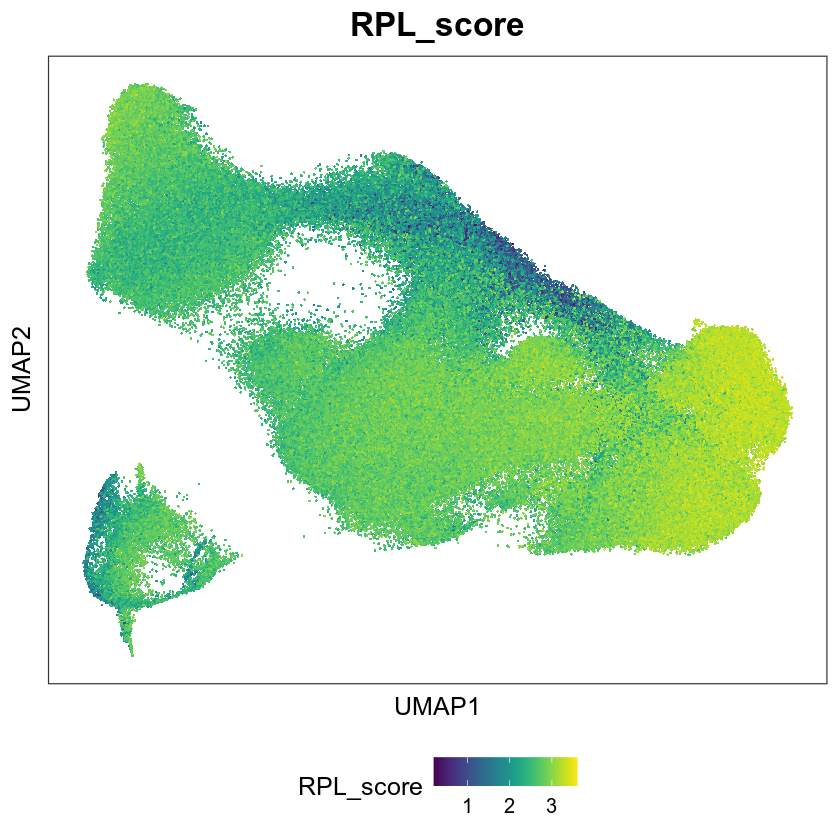

In [63]:
ggplot() + 
      geom_point(
      data = meta, 
          aes(x = UMAP_1, y = UMAP_2, color = RPL_score),
        size = 0.75, stroke = 0.00001) + 
      scale_color_viridis() + 
      labs(x="UMAP1", y="UMAP2", title = "RPL_score") +
      theme_bw(base_size = 15) +
  theme( legend.position = "bottom",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

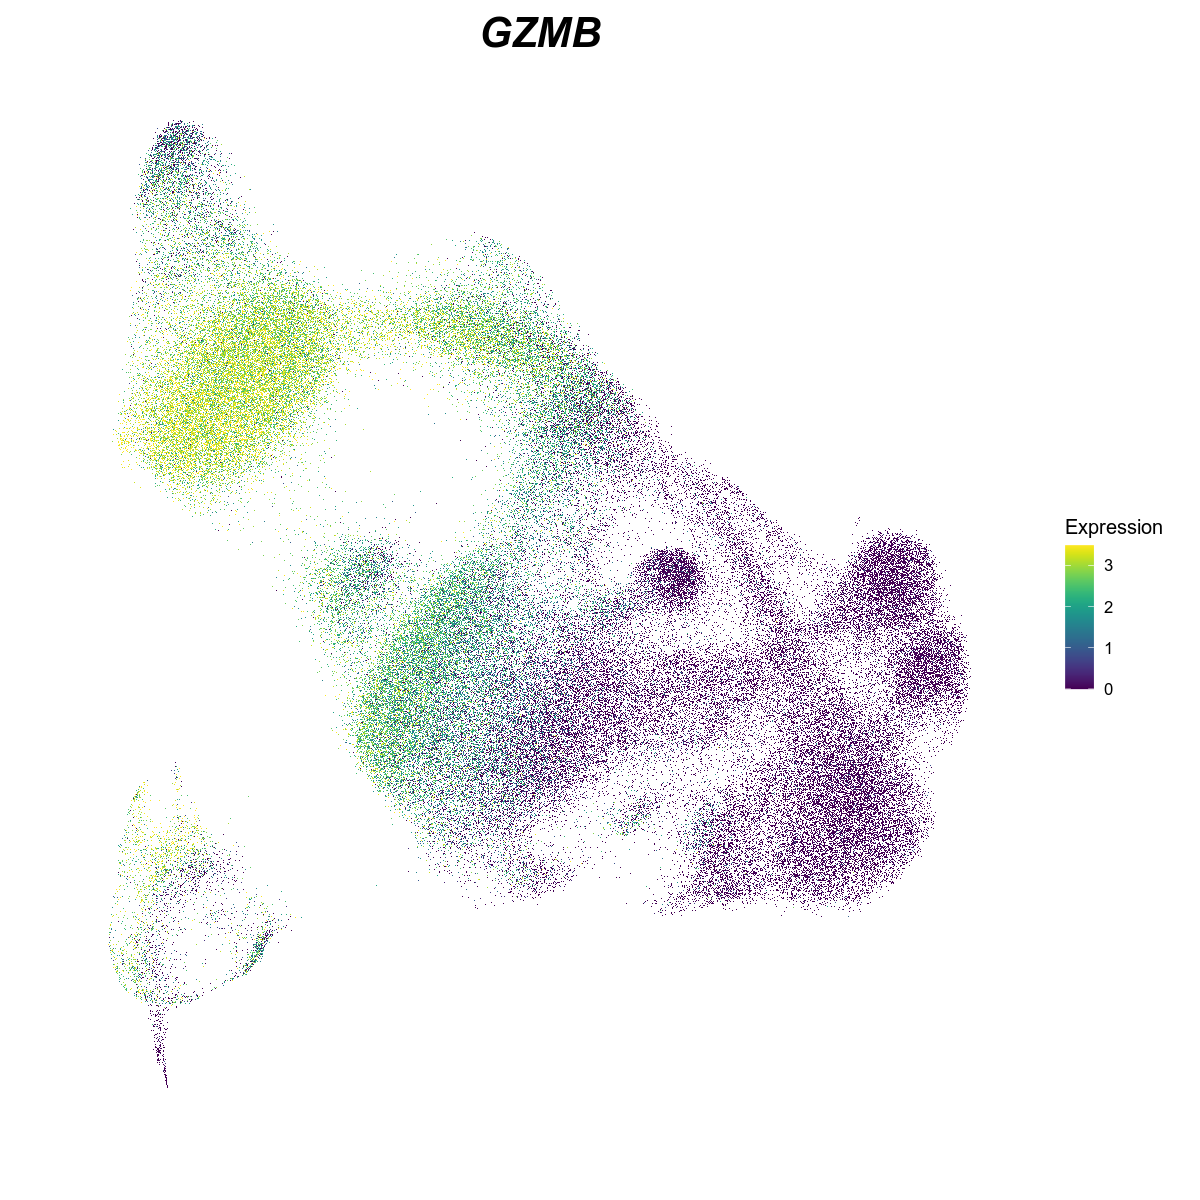

In [186]:
plot_shuffled_features(filtered_meta, norm, "GZMB", 0.95, 0.1)

In [187]:
filter_genes <- c("CD3D", "NCAM1", "FCGR3A", "FGFBP2",  
                  "NEAT1", "PRF1", "XCL2", "IL2RB", "CD74", "HLA-DRA",
                  "CD8A", "CD4", "GZMK", "GZMH", "GZMB",
                  "IL7R", "VIM", "SELL", "CCR7", "CD28",
                  "FOXP3", "IL2RA", "TRDC", "TRGC1", "MAF1", "ITM2A",
                  "ISG15", "IFI27", "DNMT1", "HELLS", "MKI67", "PCNA", "CENPF")

In [189]:
library(presto)

Loading required package: Rcpp



In [190]:
tnk_de <- wilcoxauc(norm[filter_genes, filtered_meta$Cell], filtered_meta$annotation)

In [191]:
plot_df <- tnk_de %>% select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [195]:
dat = plot_df %>%  rename(percent = pct_in,
                             zscore = avgExpr_scaled)
dat$zscore = dat$zscore %>% as.numeric
vmax = (abs(dat$zscore) %>% quantile(.95))[[1]] %>% round(1)
vmin = -vmax

In [298]:
clus_order = dat$group %>% unique %>% sort

clus_order = c('bl-NK0. CD56dim CD16high FGFBP2high NK',
               'bl-NK5. CD56bright NEAT1high PRF1high NK',
               'bl-NK6. CD56bright XCL2high IL2RBhigh NK',
               
               
               
               'bl-T11. TRDC+ Gamma/Delta',
               'bl-T12. TRGC1+ Gamma/Delta',
               
               'bl-T7. CD8+ GZMK+ TEMRA',
               'bl-T13. CD4+ MAF+ IT2MA+ Effector Memory',
               'bl-T14. CD8+ GZMK+ CD74high HLA-DRhigh',
               'bl-T2. CD8+ GZMK+ CD74+ HLA-DR+',
              'bl-T1. CD8+ GZMHhigh FGFBP2high',
              'bl-T4. CD8+ MT-high',
               'bl-T17. ISGhigh',

               'bl-T16. CD4+ T-reg',
              'bl-T3. CD4+ IL7Rhigh VIMhigh',
               'bl-T9. CD4+ Effector Memory',

               'bl-T10. CD4+ Central Memory/Naive',
               'bl-T8. CD8+ Central Memory/Naive',
               
               'bl-T18. CD8+ GZMB+ PCNAhigh Proliferating',
               'bl-T15. CD8+ GZMB+ DNMT1+ HELLS+ Proliferating',
               'bl-T19. CD8+ GZMB+ CENPFhigh Proliferating'

)

In [299]:
setdiff(dat$group, clus_order)
setdiff(clus_order, dat$group)

character(0)

character(0)

In [300]:
# gene_order = c()
# gene_order = c(gene_order, setdiff(dat$feature %>% unique, gene_order))

In [301]:
gene_order = c('CD3D',
               'CD8A',
               'CD4',

               'NCAM1',
               'FCGR3A',
               'FGFBP2',
               'XCL2',
               'IL2RB',
               'MAF1',
               'NEAT1',
               'PRF1',
                'TRDC',
               'TRGC1',
              
               'GZMB',
               'GZMK',
               'GZMH',
               'HLA-DRA',
               'CD28',
               'ISG15',
               'IFI27',
               'FOXP3',
               'IL2RA',
               'CD74',

               'VIM',
               'SELL',
               'CCR7',
               'IL7R',
               'ITM2A',

               'MKI67',
               'HELLS',
               'PCNA',
               'DNMT1',
               'CENPF'
)
gene_order = c(gene_order, setdiff(dat$feature %>% unique, gene_order))

In [302]:
setdiff(dat$feature, gene_order)
setdiff(gene_order, dat$feature)

character(0)

character(0)

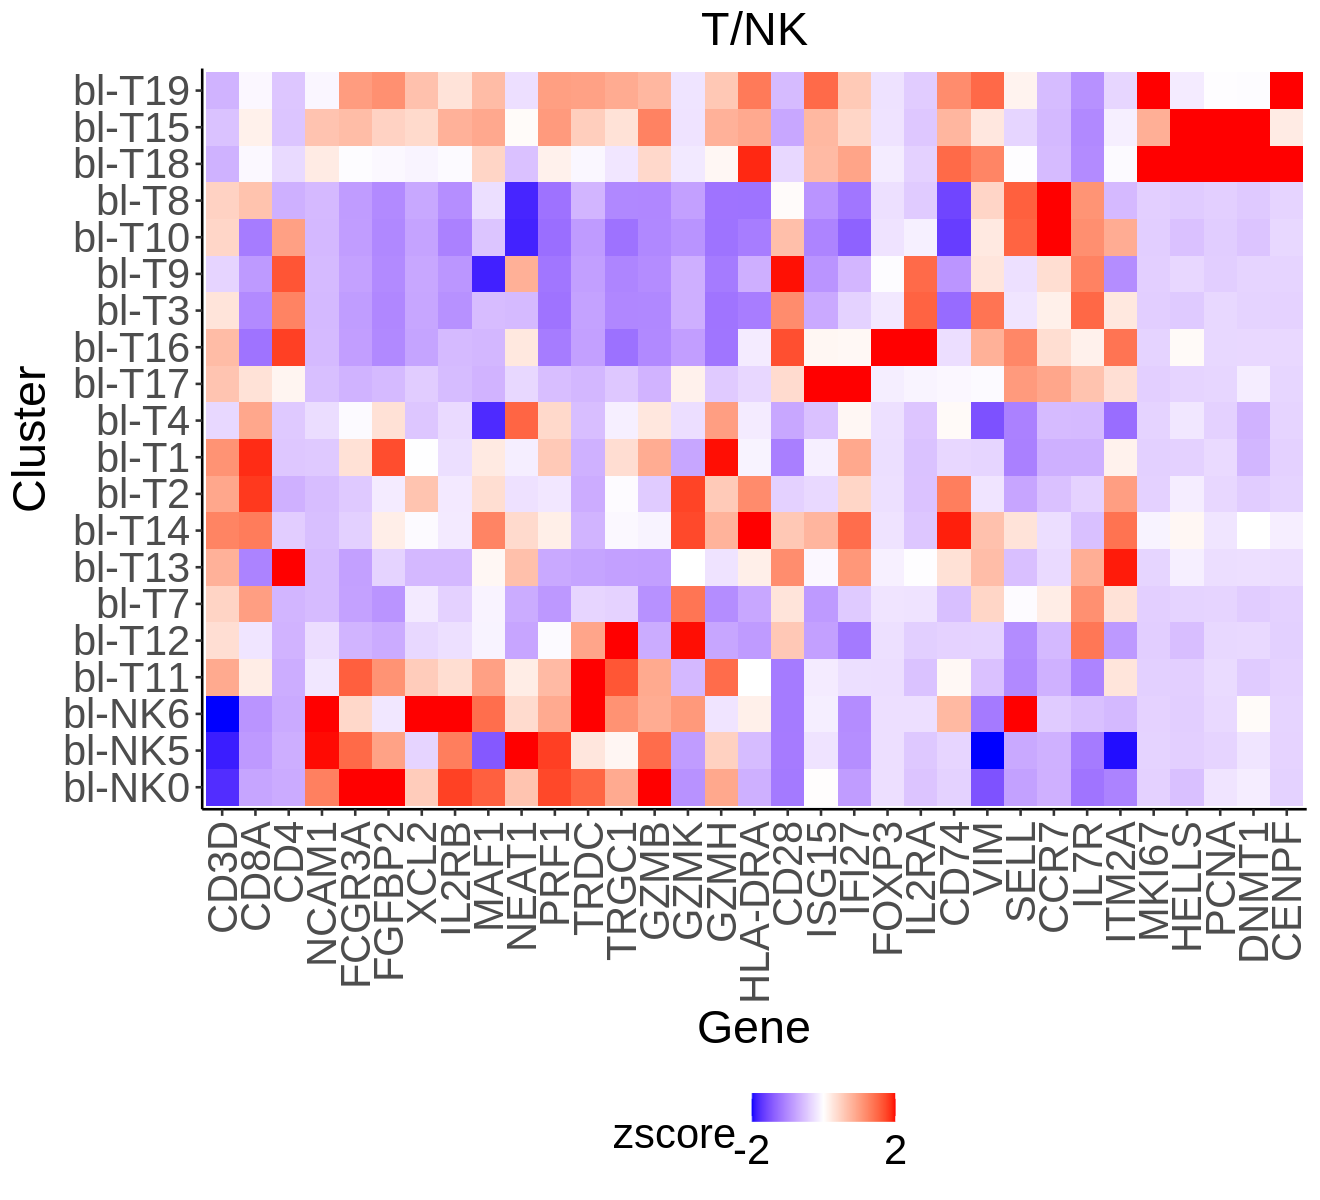

In [305]:

marker_heatmap = ggplot(dat, 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = tickfontsize) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(vmin, vmax), 
                         oob = scales::squish, breaks = c(vmin, vmax)) + 
    scale_x_discrete(limits = gene_order) + 
    scale_y_discrete(limits = clus_order, labels =clus_order %>% str_split('[.]') %>% map(1) %>% unlist) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5),
          axis.text = element_text( size = labelfontsize+5),
          axis.title = element_text(size = labelfontsize+8), 
          plot.title = element_text(size = labelfontsize+8, hjust = 0.5), 
          legend.text = element_text(size = labelfontsize+5),
          legend.title = element_text(size = labelfontsize+5),
          legend.position = 'bottom'

         ) + 
    labs(x = "Gene", y = "Cluster", title = name)

height = 10
width = 11
fig.size(height, width)

outplot = marker_heatmap
outplot

ggsave(paste0(figdir, 'tnk_pbmc_heatmap_markers.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'tnk_pbmc_heatmap_markers.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

Warning message:
“Removed 25 rows containing non-finite values (`stat_boxplot()`).”


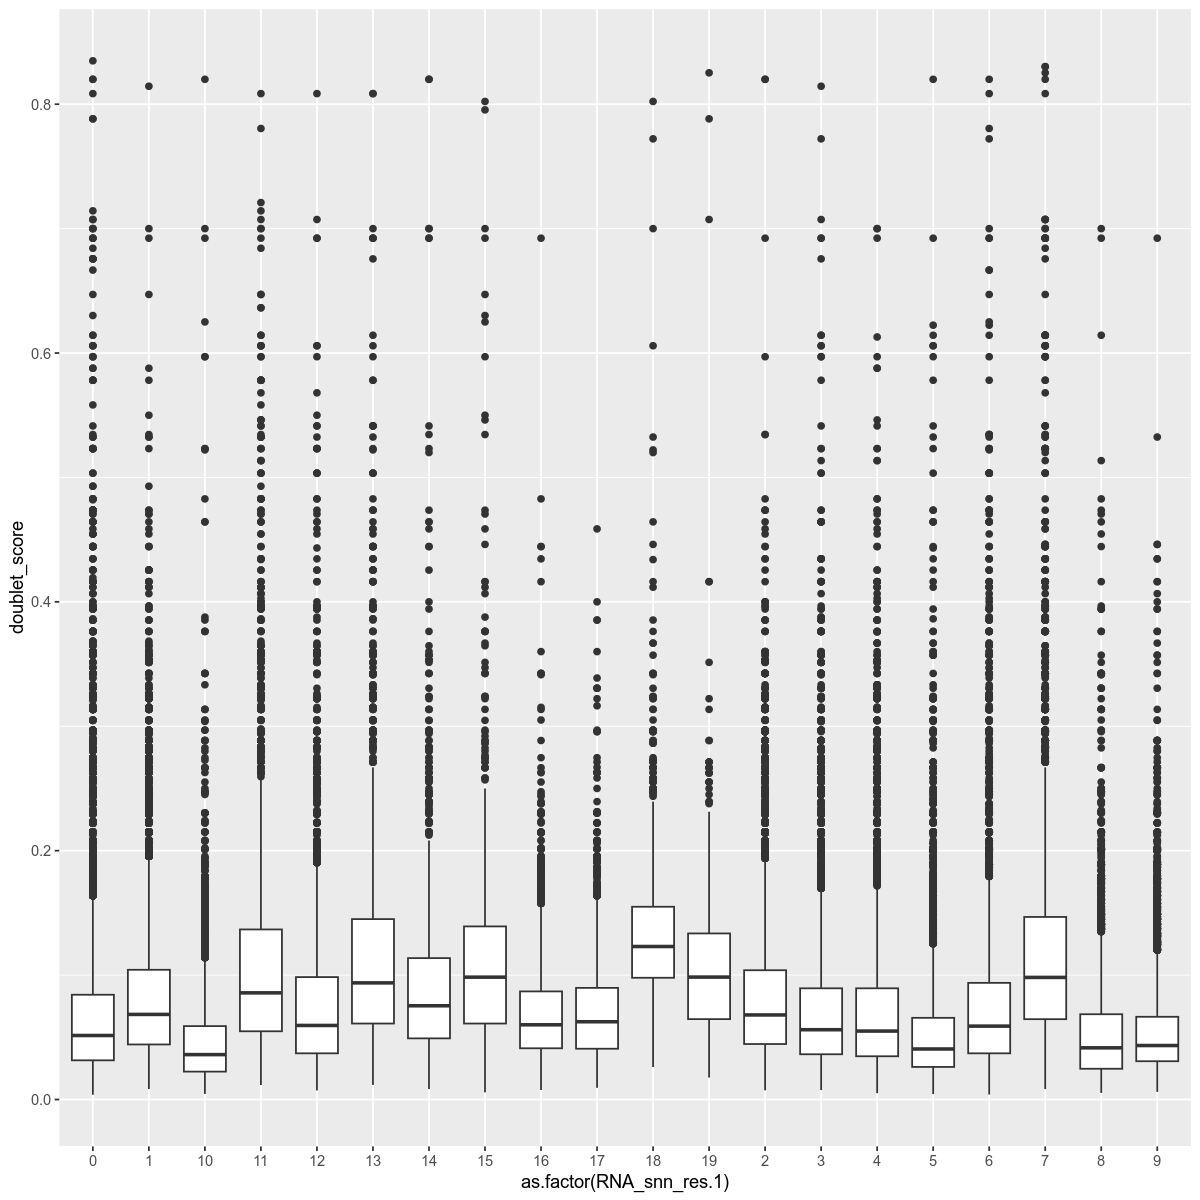

In [190]:
ggplot(filtered_meta, aes(x = as.factor(RNA_snn_res.1), y = doublet_score)) + 
    geom_boxplot()

In [189]:
colnames(filtered_meta)

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
 [4] "BARCODE"            "percent.mt"         "SNG.1ST"           
 [7] "Channel"            "Cell"               "Batch"             
[10] "Scrublet_Sample"    "doublet_score"      "doublet_prediction"
[13] "Unified_Visit"      "Donor"              "RNA_snn_res.0.25"  
[16] "seurat_clusters"    "RNA_snn_res.0.1"    "cell.type.ids"     
[19] "broad.ids"          "mono.ids"           "RNA_snn_res.0.5"   
[22] "RNA_snn_res.0.75"   "RNA_snn_res.1"      "UMAP_1"            
[25] "UMAP_2"             "Type"               "individual"

## CASE/CONTROL

In [100]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame()


individuals <- kidney_immune_meta %>% 
                        filter(broad_cell_type %in% c("T Cell", "NK Cell")) %>% 
                        pull(individual) %>% unique()

SLE_pbmc_LN <- SLE_pbmc_meta %>% 
                    filter(Type == "SLE", individual %in% individuals) 

SLE_pbmc_control <- SLE_pbmc_meta %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control")) %>% 
                        filter(Type == "Control")

SLE_pbmc_case_control <- rbind(SLE_pbmc_LN, SLE_pbmc_control)

In [102]:
meta <- SLE_pbmc_case_control

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta <- meta %>% mutate(Type = ifelse(Type == "SLE", 1, 0))

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/umap.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

In [9]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1
meta <- meta %>% 
            mutate(RNA_snn_res.1 = as.factor(RNA_snn_res.1)) %>% 
            left_join(annotations)

Joining, by = "RNA_snn_res.1"


In [21]:
control <- meta %>% filter(Type == 0) %>% 
                group_by(RNA_snn_res.1) %>% 
                summarize(samples = length(unique(Unified_Visit)),
                          ncells = length(unique(Cell))) %>% 
                mutate(control = paste0(samples, " (", ncells, ")")) %>% select(RNA_snn_res.1, control)
LN <- meta %>% filter(Type == 1) %>% 
                group_by(RNA_snn_res.1) %>% 
                summarize(samples = length(unique(Unified_Visit)),
                          ncells = length(unique(Cell))) %>% 
                mutate(LN = paste0(samples, " (", ncells, ")")) %>% select(RNA_snn_res.1, LN)
merged <- LN %>% left_join(control) %>% left_join(LN) %>% left_join(control)
merged[is.na(merged)] <- "0 (0)"
write.csv(merged, 
          '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/tnk_summary_04192024.csv', 
          quote = FALSE, row.names = FALSE)

Joining, by = "RNA_snn_res.1"
Joining, by = c("RNA_snn_res.1", "LN")
Joining, by = c("RNA_snn_res.1", "control")


Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


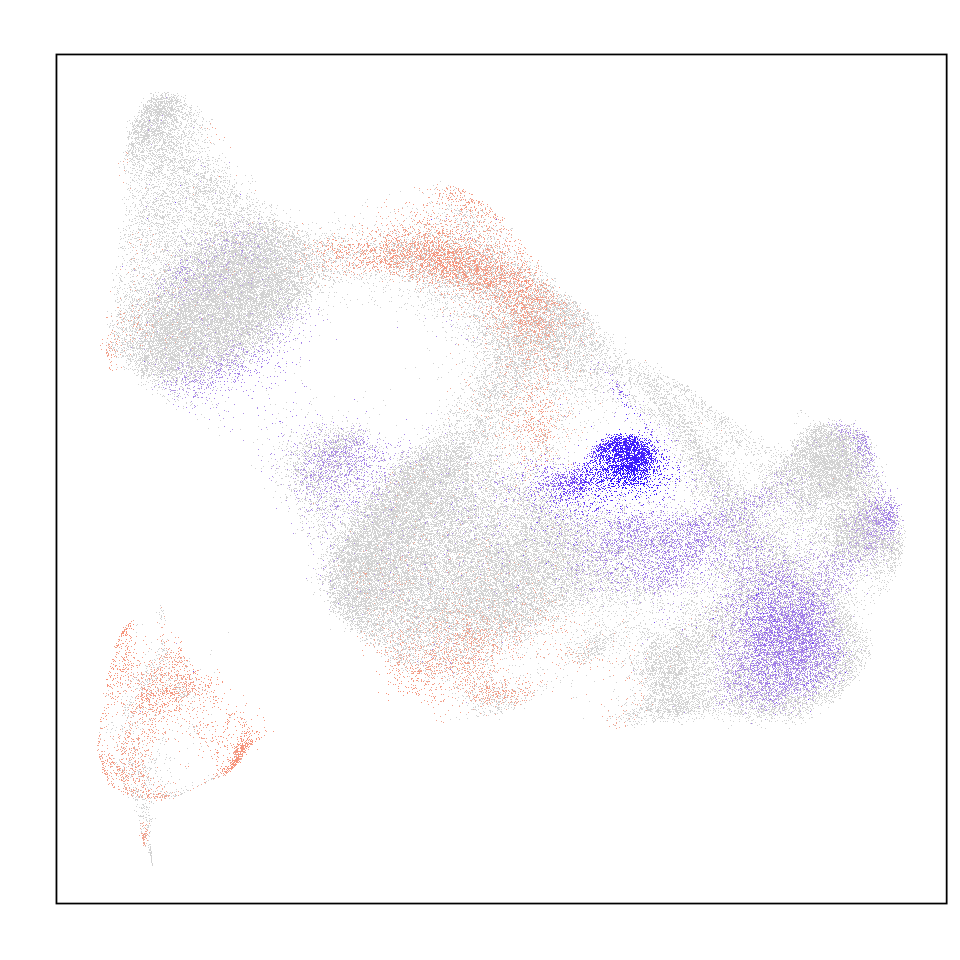

In [10]:
fdr_10 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = tmp_meta,
                 aes(x = UMAP_1, y = UMAP_2), color = 'lightgrey', size = 0.1, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation), size = 0.1, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
                           #breaks = c(-0.3, -0.15, 0, 0.15, 0.3)) + 
     # labs(x="UMAP1", y="UMAP2", title = "T/NK Chronicity: p = 0.006") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
    legend.key.width = unit(1, 'cm'),
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r") 

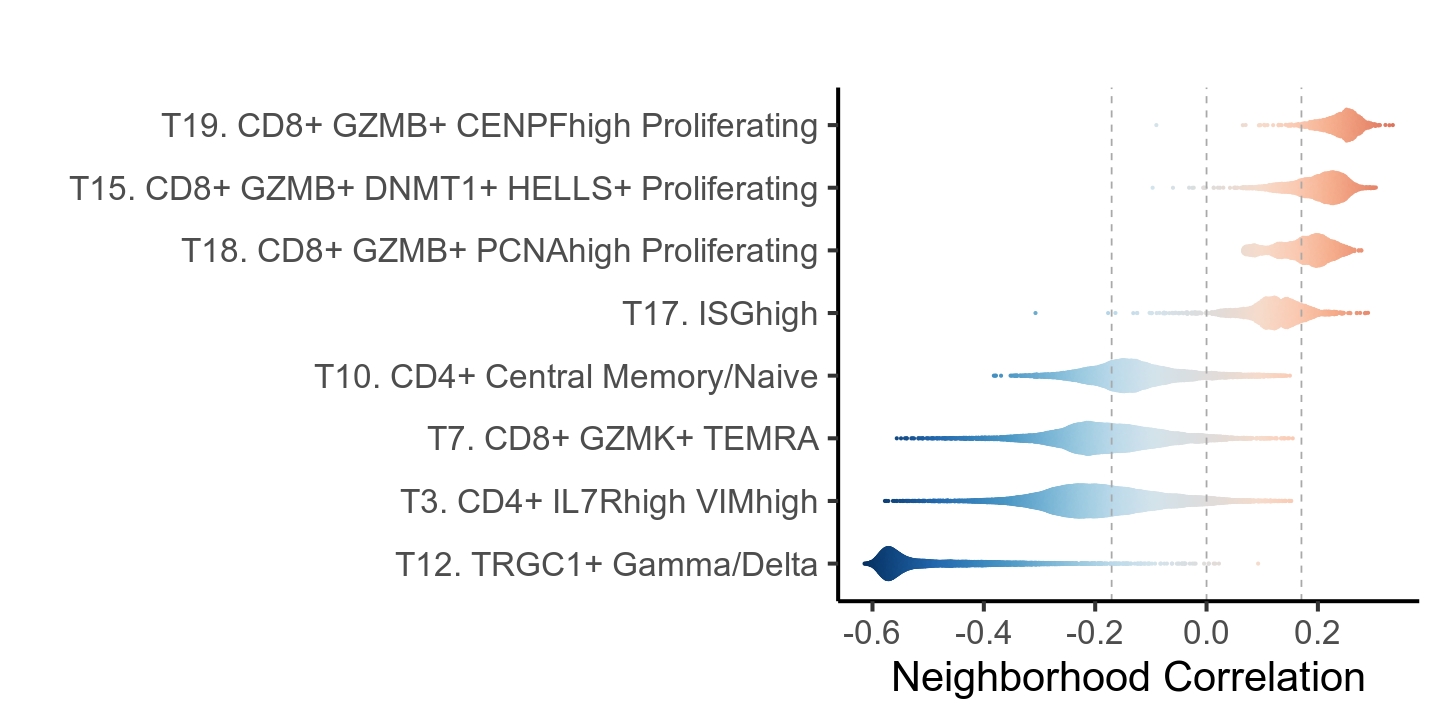

In [19]:
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))

subset <- as.character(c(3,7,10,12,15,17,18,19))

ggplot(meta %>% filter(RNA_snn_res.1 %in% subset), 
       aes(y = reorder(annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic(base_size = 25) +
    theme(
        legend.position = "none",
        panel.grid = element_blank()) 

In [14]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata.rds')
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/meta.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/ncorr.csv", header = FALSE)
meta$ncorr <- ncorr$V1

ci_summary <- meta %>% 
                select(RNA_snn_res.1, Cell, ncorr) %>% 
                group_by(RNA_snn_res.1) %>% 
                summarize(ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(Cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(Cell)), 3), ")"))
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/tnk_pbmc/case_control.rds') %>% 
            mutate(RNA_snn_res.1 = as.integer(str_remove(cluster, "cluster")),
               OR.ci = paste0("(", round(Type.OR.95pct.ci.lower, 3) , ", ", 
                              round(Type.OR.95pct.ci.upper, 3), ")")) %>% 
         select(RNA_snn_res.1, OR.ci)

summary <- ci_summary %>% left_join(res)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/tnk_case_control_corr_04192024.csv', 
          quote = FALSE, row.names = FALSE, sep = '\t')

Joining, by = "RNA_snn_res.1"


### MASC

In [38]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/meta.csv")

In [39]:
model_df <- meta %>% select(Unified_Visit, Type, nCount_RNA, percent.mt, RNA_snn_res.1)
model_df <- model_df %>% 
                mutate(
                       nCount_RNA = log(nCount_RNA))

In [40]:
res <- MASC.me(model_df, factor(model_df$RNA_snn_res.1),
                contrast = "Type",
                random_effects = c("Unified_Visit"),
                fixed_effects = c("nCount_RNA", "percent.mt"),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Using null model: cluster ~ nCount_RNA + percent.mt + (1|Unified_Visit)

Creating logistic mixed models for cluster0

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00405616 (tol = 0.002, component 1)”
Creating logistic mixed models for cluster1

Creating logistic mixed models for cluster10



In [12]:
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/tnk_pbmc/case_control.rds')

In [14]:
res %>% filter(bonferroni < 0.05)

cluster   size  model.pvalue Type.OR   Type.OR.95pct.ci.lower
cluster12 cluster12  5812 5.311318e-11 0.2080892 0.1354330             
cluster15 cluster15  2423 1.939868e-07 2.9126219 1.9902138             
cluster19 cluster19   873 2.001394e-07 3.2809199 2.1315585             
cluster10 cluster10  5929 3.430790e-07 0.2008129 0.1118707             
cluster3  cluster3  14563 4.666572e-06 0.3344833 0.2129221             
cluster17 cluster17  1871 7.553018e-05 2.8375659 1.7289997             
cluster18 cluster18  1860 7.427346e-04 2.2559611 1.4194212             
cluster7  cluster7   7640 2.043799e-03 0.6583496 0.5070057             
          Type.OR.95pct.ci.upper bonferroni  
cluster12 0.3197234              1.062264e-09
cluster15 4.2625402              3.879737e-06
cluster19 5.0500304              4.002788e-06
cluster10 0.3604680              6.861580e-06
cluster3  0.5254462              9.333144e-05
cluster17 4.6569011              1.510604e-03
cluster18 3.5855180              1.485469e-02
cluster7  0.8548705              4.087598e-02

### DE

In [47]:
tnk_norm <- readRDS("/data/srlab/ssg34/SLE_pbmc_analysis/data/gene_expression/t_nk_qcd_seurat_sc_analysis_08252023.rds")[["RNA"]]@data

In [48]:
tnk_norm <- tnk_norm[, meta$Cell]

In [59]:
out <- mclapply(unique(meta$Unified_Visit), pseudobulk, meta, tnk_norm,
               mc.cores = 6)

In [101]:
feature = "ISG15"
model_df <- tnk_pb %>% select(feature, Unified_Visit, Age, Sex, Type, avg_count, avg_mt) %>% rename(Exp = feature)
m_0 <- lm(Exp ~ log(avg_count) + avg_mt + scale(Age) + Sex, data = model_df)
m_1 <- lm(Exp ~ log(avg_count) + avg_mt + scale(Age) + Sex + Type, data = model_df)
ANNO <- anova(m_0, m_1)
LRP <- ANNO[2,6]
F <- ANNO[2,5]
Beta <- summary(m_1)$coefficients['Type', 'Estimate']
SE <- summary(m_1)$coefficients['Type', 'Std. Error']
res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(feature)

  # Now:
  data %>% select(all_of(feature))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


ERROR: Error in summary(m_1)$coefficients["Type", "Estimate"]: subscript out of bounds


In [66]:
tnk_pb <- data.frame(do.call(rbind, out))
sample_stats <- meta %>% group_by(Unified_Visit) %>% summarize(avg_count = mean(nCount_RNA), 
                                                               avg_mt = mean(percent.mt))
tnk_pb <- tnk_pb %>% left_join(sample_stats) %>% left_join(unique(meta %>% select(Unified_Visit, Type)))
colnames(tnk_pb)[1:36601] <- rownames(tnk_norm)

Joining, by = "Unified_Visit"
Joining, by = "Unified_Visit"


In [79]:
saveRDS(tnk_pb, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/tnk_pbmc_norm_pseudobulk_01042024.rds')

In [35]:
tnk_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/tnk_pbmc_norm_pseudobulk_01042024.rds')

In [108]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/case_control/meta.csv")

In [110]:
meta %>% colnames()

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
 [4] "BARCODE"            "percent.mt"         "SNG.1ST"           
 [7] "Channel"            "Cell"               "Batch"             
[10] "Scrublet_Sample"    "doublet_score"      "doublet_prediction"
[13] "Unified_Visit"      "Donor"              "RNA_snn_res.0.25"  
[16] "seurat_clusters"    "RNA_snn_res.0.1"    "cell.type.ids"     
[19] "broad.ids"          "mono.ids"           "RNA_snn_res.0.5"   
[22] "RNA_snn_res.0.75"   "RNA_snn_res.1"      "Type"              
[25] "individual"

In [ ]:
tnk_pb <- tnk_pb %>% left_join(unique(meta %>% select(Unified_Visit, Age, Sex)))

In [99]:
de_out <- mclapply(colnames(tnk_pb)[1:36601], de, tnk_pb, mc.cores = 20)

Warning message in mclapply(colnames(tnk_pb)[1:36601], de, tnk_pb, mc.cores = 20):
“all scheduled cores encountered errors in user code”


In [81]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [82]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/tnk_case_control_differential_expression_pbmc_010422024.rds')

In [29]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/tnk_case_control_differential_expression_pbmc_010422024.rds')

In [30]:
de_df <- de_df %>% na.omit()

In [31]:
de_df$FDR <- p.adjust(de_df$LRP, method = "BH")

In [235]:
genes <- c("COMMD6", "CD48", "GZMK", "XAF1", 
           "ITM2B", "IL7R",
            "NEAT1", "IFI44L", "ISG15",
            "MX1", "STAT1", "BST2")

Warning message:
“Removed 24153 rows containing missing values (`geom_text_repel()`).”


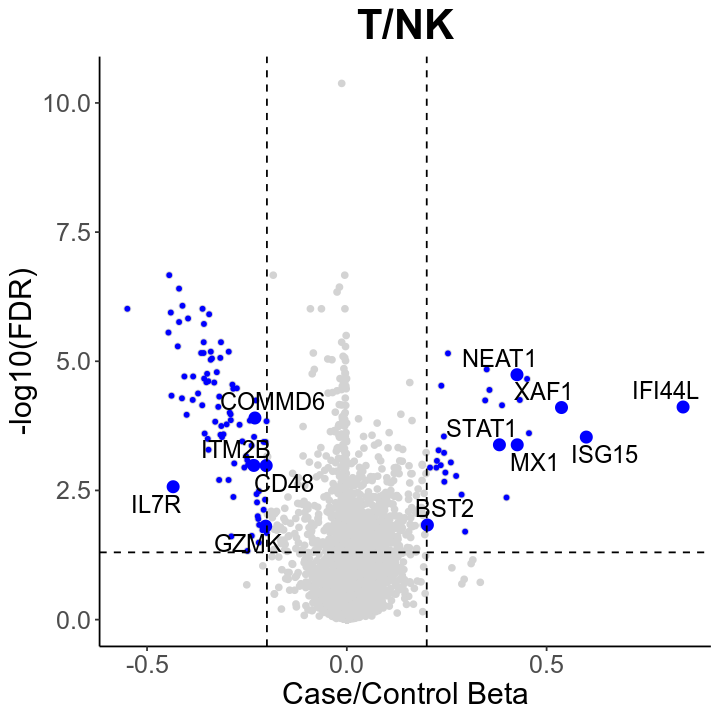

In [247]:
fig.size(6, 6)
ggplot(de_df,
                aes(x = Beta, y = -log10(FDR))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(FDR < 0.05 & abs(Beta) >= 0.2,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.2, 0.2), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(gene %in% genes, gene, NA)),
                                     aes(x = Beta, y = -log10(FDR), 
                                         size = 5, label = label), color = "black", 
                                     max.overlaps = 15) +
    scale_size_identity() + 
    labs(x = "Case/Control Beta", y = "-log10(FDR)", title = "T/NK")

In [65]:
plot_df <- tnk_pb %>% 
            select(c(grep("MT-", colnames(tnk_pb), value = TRUE), Type, Unified_Visit)) %>% 
            pivot_longer(grep("MT-", colnames(tnk_pb), value = TRUE),
                         names_to = "MT_Gene",
                         values_to = "Pseudobulk_Expression")  

## WITHIN CASES

In [148]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                        filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() 

In [149]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% filter(Donor %in% clinical_LN$AMP.Subject_ID) 

In [150]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                            left_join(clinical_LN) %>% 
                            left_join(first_biop_pred) %>% 
                            select(c(Cell, BARCODE, Sex, cell.type.ids, Unified_Visit, Donor,
                                     Responder.Status, Age, Race, Final_ISN, 
                                     Final_Chronicity, Final_Activity, Type, Final_Site,
                                     First_biop, Pred_use, individual, RNA_snn_res.0.5))  %>% 
                            rename(AMP.Subject_ID = Donor)

Joining, by = "individual"
Joining, by = "individual"


## RESPONSE

In [51]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/response/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/response/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/response/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## CHRONICITY

In [54]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESULTS

In [ ]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.10) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) %>% 
                    left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.5))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(
      data = tmp_meta %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation),
        size = 0.75, stroke = 0.00001) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "T/NK Chronicity") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

In [50]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata.rds')
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/meta.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/cond_ncorr.csv", header = FALSE)
meta$ncorr <- ncorr$V1

ci_summary <- meta %>% left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.1)) %>% 
                select(RNA_snn_res.1, Cell, ncorr) %>% 
                group_by(RNA_snn_res.1) %>% 
                summarize(ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(Cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(Cell)), 3), ")"))
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/tnk_pbmc/chronicity_covariates.rds') %>% 
            mutate(RNA_snn_res.1 = as.factor(str_remove(cluster, "cluster")),
               OR.ci = paste0("(", round(Final_Chronicity1.OR.95pct.ci.lower, 3), ", ", 
                              round(Final_Chronicity1.OR.95pct.ci.upper, 3), ")")) %>% 
        select(RNA_snn_res.1, OR.ci)

summary <- ci_summary %>% 
            mutate(RNA_snn_res.1 = factor(RNA_snn_res.1, levels = 0:19)) %>% 
            left_join(res) %>% 
            arrange(RNA_snn_res.1)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/tnk_chronicity_corr_04192024.csv', 
          quote = FALSE, row.names = FALSE, sep = '\t')

Joining, by = "Cell"
Joining, by = "RNA_snn_res.1"


### MASC

In [ ]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/chronicity/meta.csv")
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_t_nk_pbmc_metadata.rds')

model_df <- meta %>% left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.1)) %>% 
                        mutate(RNA_snn_res.1 = as.character(RNA_snn_res.1)) %>% 
                            mutate(Final_Chronicity = as.factor(Final_Chronicity))

Joining, by = "Cell"


In [19]:
res <- MASC.me(model_df, as.factor(model_df$RNA_snn_res.1),
                contrast = "Final_Chronicity",
                random_effects = c("Unified_Visit"),
                fixed_effects = c("Age", "Sex", 'First_biop', 'Responder_Status'),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Using null model: cluster ~ Age + Sex + First_biop + Responder_Status + (1|Unified_Visit)

Creating logistic mixed models for cluster0

Creating logistic mixed models for cluster1

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00249818 (tol = 0.002, component 1)”
Creating logistic mixed models for cluster10

Creating logistic mixed models for cluster11

Creating logistic mixed models for cluster12

Creating logistic mixed models for cluster13

Creating logistic mixed models for cluster14

Creating logistic mixed models for cluster15

Creating logistic mixed models for cluster16

Creating logistic mixed models for cluster17

Creating logistic mixed models for cluster18

Creating logistic mixed models for cluster19

Creating logistic mixed models for cluster2

Creating logistic mixed models for cluster3

Creating logistic mixed models for cluster4

Creating logistic mixed models for cluster5

Creating l

In [20]:
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/tnk_pbmc/chronicity_covariates.rds')

## ACTIVITY

In [55]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/activity/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/activity/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/activity/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## ISN

In [59]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/isn/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/isn/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/isn/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESULTS

In [ ]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/isn/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/isn/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/isn/class_5_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/t_nk/isn/class_5_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.11) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) %>% 
                    left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.5))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(
      data = tmp_meta %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation),
        size = 0.75, stroke = 0.00001) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "T/NK ISN Class 5") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

In [ ]:
fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

meta <- meta %>% 
            left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.5))

pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

ggplot(meta, aes(x = reorder(RNA_snn_res.0.5, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

# CNA PREP - Monocytes and DC

In [411]:
norm <- readRDS('/data/srlab/ssg34/SLE_pbmc_analysis/data/gene_expression/mono_dc_qcd_seurat_sc_analysis_08252023.rds')[['RNA']]@data
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata_new.rds')
SLE_harmony <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_hPCs_new.rds')
SLE_umap <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_umap_new.rds')

In [412]:
annotations <- data.frame(RNA_snn_res.0.75 = as.character(seq(0, 12)),
                          annotation = c("bl-M0. CD14+ CD16- S100Ahigh", 
                                         "bl-M1. CD14+ CD16- CXCL8+",
                                         "bl-M2. CD14+ CD16- CCR2high",
                                         "bl-M3. CD16++ CD14dim CDKN1C+",
                                         "bl-M4. CD14+ CD16+ MHC2higher",
                                         "bl-M5. CD14+ CD16- LGALS2+",
                                         "bl-DC6. CLEC10A+ CD1C+ DC2",
                                         "bl-M7. CD14+ CD16- ISGhigh", 
                                         "bl-P8. PPBP+ GP1BB+ Platelet",
                                         "bl-DC9. TCF4+ CLEC4C+ pDC",
                                         "bl-M10. MThigh",
                                         "bl-M11. CD14+ CD16+ MHC2lower",
                                         "bl-DC12. CLEC9A+ XCR1+ DC1"))

In [99]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% left_join(annotations)

Joining, by = "RNA_snn_res.0.75"


In [100]:
SLE_pbmc_meta <- cbind(SLE_pbmc_meta, SLE_umap)
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame()


SLE_pbmc_LN <- SLE_pbmc_meta %>% 
                    filter(Type == "SLE", individual %in% kidney_immune_meta$individual) 

SLE_pbmc_control <- SLE_pbmc_meta %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control")) %>% 
                        filter(Type == "Control")

filtered_meta <- rbind(SLE_pbmc_LN, SLE_pbmc_control)
saveRDS(filtered_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata_filtered_V0_cases_controls_07182024.rds')

In [413]:
filtered_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata_filtered_V0_cases_controls_07182024.rds')

In [414]:
# Update cluster names
filtered_meta= filtered_meta %>% select(-annotation) %>% left_join(annotations)

Joining with `by = join_by(RNA_snn_res.0.75)`


In [415]:
name = 'Monocyte/Dendritic'

In [175]:
ncells = filtered_meta %>% nrow

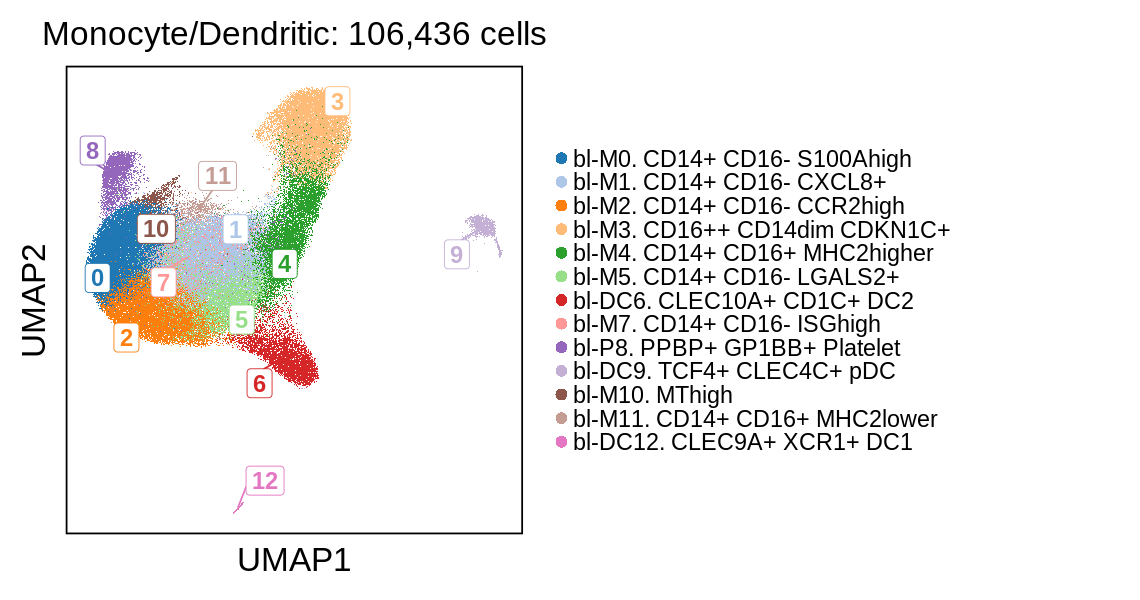

In [176]:
options(warn=-1)
cluster_center <- filtered_meta %>%
                  mutate(RNA_snn_res.0.75 = as.numeric(RNA_snn_res.0.75)) %>% 
                  group_by(RNA_snn_res.0.75, annotation) %>%
                  summarise_at(vars(UMAP_1, UMAP_2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

cluster_center <- cluster_center[order(cluster_center$RNA_snn_res.0.75), ]

options(repr.plot.height = 9, repr.plot.width = 18)
p <- ggplot() +
      geom_point(
        data = filtered_meta[sample(nrow(filtered_meta)), ] %>% 
          select(UMAP_1, UMAP_2, RNA_snn_res.0.75, annotation) %>% 
                  mutate(annotation = factor(annotation, 
                                                   levels = cluster_center$annotation)),
        aes(x = UMAP_1, y = UMAP_2, color = annotation),
          size = 0.5, shape = 20, stroke = 0.0001) +
      ggrepel::geom_label_repel(
        data = cluster_center,
        aes(x = UMAP_1, y = UMAP_2, 
            label = RNA_snn_res.0.75, color = factor(annotation, 
                                                     levels = cluster_center$annotation)),
        size = 5,  fontface = "bold",
        box.padding = unit(0.5, "lines"),
        point.padding = unit(0.01, "lines"),
        show.legend = FALSE
      ) +
    ggthemes::scale_color_tableau(palette = "Classic 20") + 
    # scale_color_manual(values = as.vector(polychrome(20))) +
theme_classic(base_size = tickfontsize) +
  theme(
         plot.title = element_text(size = labelfontsize, hjust = 0.5),
          axis.title = element_text(size = labelfontsize), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          text=element_text(family="Arial"),
          legend.text = element_text(size = 14,
                                     margin = margin(t = 0, b = 0, unit = "pt")),
          legend.title = element_blank(),
          legend.key.size = unit(0.4, "cm"),           # Adjust size of legend key
          legend.spacing.y = unit(0, "cm"),           # Adjust spacing between legend items
            legend.justification = "left",  
  )+
        labs(x = "UMAP1", y = "UMAP2", 
             title = paste0(name, ': ', format(ncells,big.mark=",",scientific=FALSE), ' cells'),
            col = '') +
        guides(color = guide_legend(ncol = 1, byrow = TRUE, override.aes = list(size = 5)))
legend <- cowplot::get_legend(p)
p = p + theme(legend.position = "none")
legend = cowplot::plot_grid(legend)
outplot = p + legend + plot_layout(widths = c(1, 1.3))

height = 5
width = 9.5
fig.size(height, width)
outplot

ggsave(paste0(figdir, 'pbmc_myeloid_umap_sc.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pbmc_myeloid_umap_sc.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


In [416]:
mono_dc_de <- wilcoxauc(norm[, filtered_meta$Cell], filtered_meta$annotation)

In [417]:
filter_genes <- c("CD14","CXCL8", "CCR2", "FPR1", "CD163",
                  "S100A8", "S100A9", "S100A12",
                  "FCGR3A", "CDKN1C", "LGALS2", 
                  "CLEC10A", "CD1C",
                  "ISG15", "IFI44L", 
                  "PPBP", "GP1BB", "CLEC4C", "TCF4", "CLEC9A", "XCR1", 
                  "HLA-DRA", "HLA-DPA1", "HLA-DPB1")

In [418]:
plot_df <- mono_dc_de %>% filter(feature %in% filter_genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [419]:
dat = plot_df %>%  rename(percent = pct_in,
                             zscore = avgExpr_scaled)
dat$zscore = dat$zscore %>% as.numeric
vmax = (abs(dat$zscore) %>% quantile(.95))[[1]] %>% round(1)
vmin = -vmax

In [420]:
# clus_order = dat$group %>% unique %>% sort

clus_order = c(
             "bl-P8. PPBP+ GP1BB+ Platelet",

             "bl-M0. CD14+ CD16- S100Ahigh", 
             "bl-M1. CD14+ CD16- CXCL8+",
             "bl-M2. CD14+ CD16- CCR2high",
             "bl-M5. CD14+ CD16- LGALS2+",
             "bl-M7. CD14+ CD16- ISGhigh", 

             "bl-M11. CD14+ CD16+ MHC2lower",
             "bl-M4. CD14+ CD16+ MHC2higher",
             "bl-M3. CD16++ CD14dim CDKN1C+",
    
             "bl-M10. MThigh",
               
             "bl-DC6. CLEC10A+ CD1C+ DC2",
             "bl-DC9. TCF4+ CLEC4C+ pDC",
             "bl-DC12. CLEC9A+ XCR1+ DC1"
               

)

In [421]:
setdiff(dat$group, clus_order)
setdiff(clus_order, dat$group)

character(0)

character(0)

In [325]:
# gene_order = c()
# gene_order = c(gene_order, setdiff(dat$feature %>% unique, gene_order))

In [422]:
gene_order = c(
                "PPBP", "GP1BB",
                "CD14","CXCL8", "CCR2", "FPR1", "CD163",
                  "S100A8", "S100A9", "S100A12",
                  "ISG15", "IFI44L", 
                  "FCGR3A", "CDKN1C", "LGALS2", 
                  "CLEC10A", "CD1C",
                   "CLEC4C", "TCF4", "CLEC9A", "XCR1", 
                  "HLA-DRA", "HLA-DPA1", "HLA-DPB1"
)
gene_order = c(gene_order, setdiff(dat$feature %>% unique, gene_order))

In [423]:
setdiff(dat$feature, gene_order)
setdiff(gene_order, dat$feature)

character(0)

character(0)

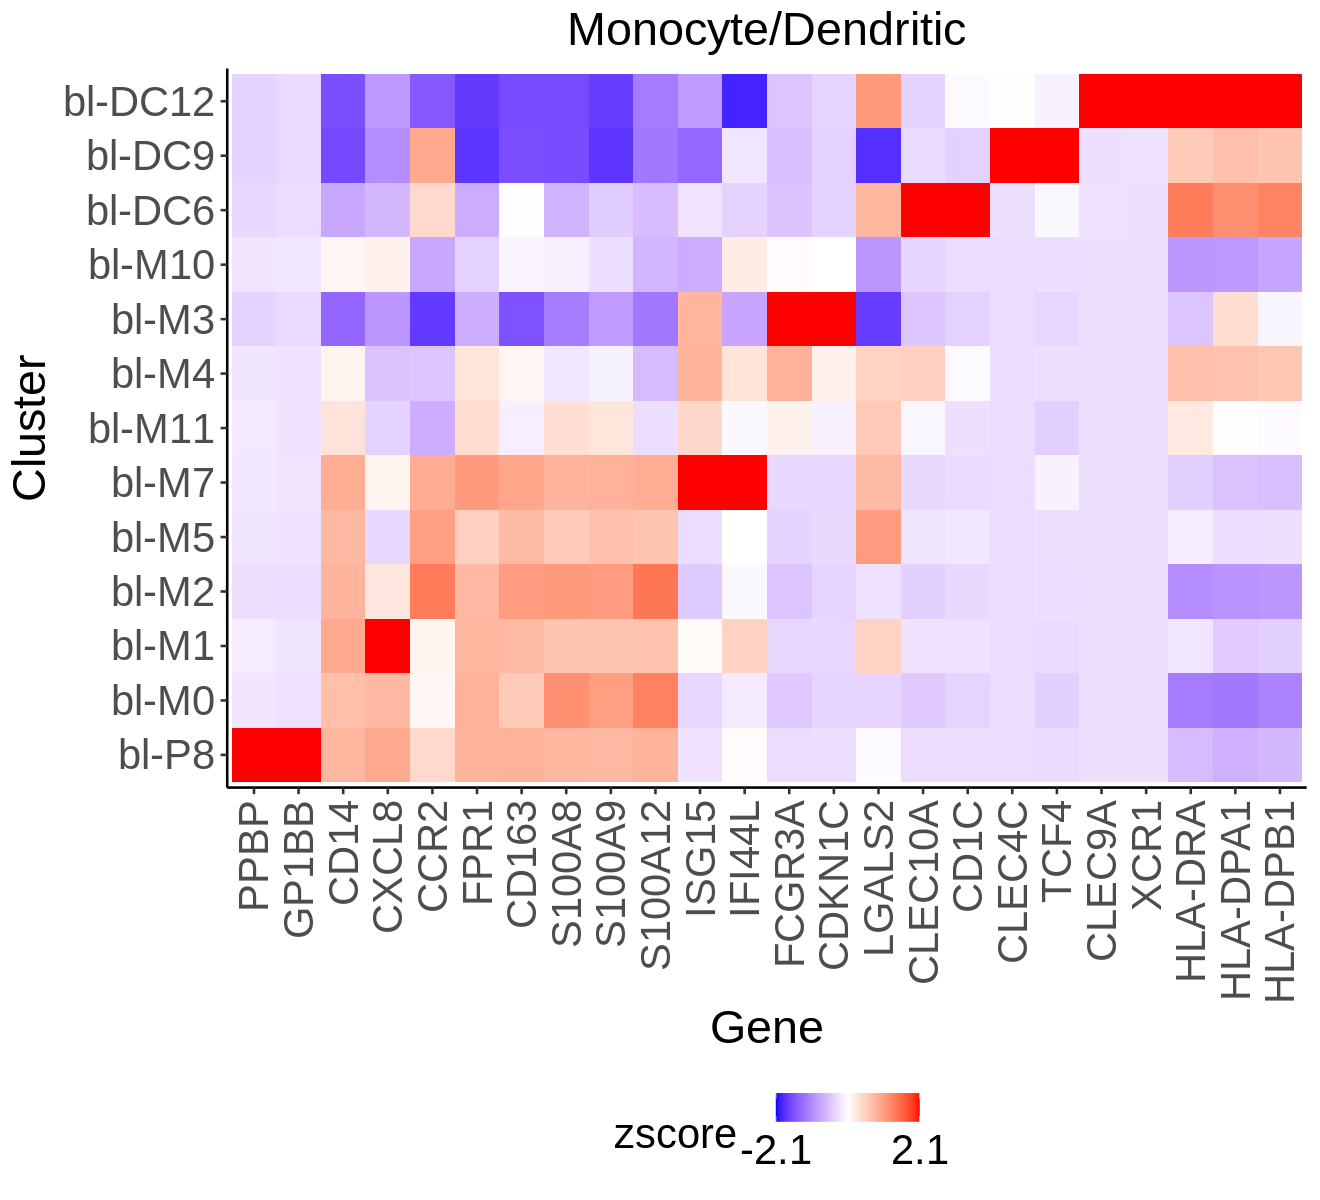

In [426]:

marker_heatmap = ggplot(dat, 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = tickfontsize) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(vmin, vmax), 
                         oob = scales::squish, breaks = c(vmin, vmax)) + 
    scale_x_discrete(limits = gene_order) + 
    scale_y_discrete(limits = clus_order, labels =clus_order %>% str_split('[.]') %>% map(1) %>% unlist) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5),
          axis.text = element_text( size = labelfontsize+5),
          axis.title = element_text(size = labelfontsize+8), 
          plot.title = element_text(size = labelfontsize+8, hjust = 0.5), 
          legend.text = element_text(size = labelfontsize+5),
          legend.title = element_text(size = labelfontsize+5),
          legend.position = 'bottom'

         ) + 
    labs(x = "Gene", y = "Cluster", fill = 'zscore  ', title = name)

height = 10
width = 11
fig.size(height, width)

outplot = marker_heatmap
outplot

ggsave(paste0(figdir, 'myeloid_pbmc_heatmap_markers.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'myeloid_pbmc_heatmap_markers.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

## CASE/CONTROL

In [3]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata_new.rds')
SLE_harmony <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_hPCs_new.rds')
SLE_umap <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_umap_new.rds')

In [8]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame()


individuals <- kidney_immune_meta %>% 
                        filter(broad_cell_type == "Myeloid Cell") %>% 
                        pull(individual) %>% unique()

SLE_pbmc_LN <- SLE_pbmc_meta %>% 
                    filter(Type == "SLE", individual %in% individuals) 

SLE_pbmc_control <- SLE_pbmc_meta %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control")) %>% 
                        filter(Type == "Control")

SLE_pbmc_case_control <- rbind(SLE_pbmc_LN, SLE_pbmc_control)

In [9]:
meta <- SLE_pbmc_case_control

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta <- meta %>% mutate(Type = ifelse(Type == "SLE", 1, 0))

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/umap.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

In [35]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1
meta <- meta %>% mutate(RNA_snn_res.0.75 = as.factor(RNA_snn_res.0.75)) %>% left_join(annotations)

Joining, by = "RNA_snn_res.0.25"


ERROR: [1m[33mError[39m in `left_join()`:[22m
[1m[22m[33m![39m Can't join on `x$RNA_snn_res.0.25` x `y$RNA_snn_res.0.25` because of incompatible types.
[36mℹ[39m `x$RNA_snn_res.0.25` is of type <integer>>.
[36mℹ[39m `y$RNA_snn_res.0.25` is of type <character>>.


In [22]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/meta.csv")
control <- meta %>% filter(Type == 0) %>% 
                group_by(RNA_snn_res.0.75) %>% 
                summarize(samples = length(unique(Unified_Visit)),
                          ncells = length(unique(Cell))) %>% 
                mutate(control = paste0(samples, " (", ncells, ")")) %>% select(RNA_snn_res.0.75, control)
LN <- meta %>% filter(Type == 1) %>% 
                group_by(RNA_snn_res.0.75) %>% 
                summarize(samples = length(unique(Unified_Visit)),
                          ncells = length(unique(Cell))) %>% 
                mutate(LN = paste0(samples, " (", ncells, ")")) %>% select(RNA_snn_res.0.75, LN)
merged <- LN %>% left_join(control) %>% left_join(LN) %>% left_join(control)
merged[is.na(merged)] <- "0 (0)"
write.csv(merged, 
          '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc_summary_04192024.csv', 
          quote = FALSE, row.names = FALSE)

Joining, by = "RNA_snn_res.0.75"
Joining, by = c("RNA_snn_res.0.75", "LN")
Joining, by = c("RNA_snn_res.0.75", "control")


In [44]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/meta.csv")

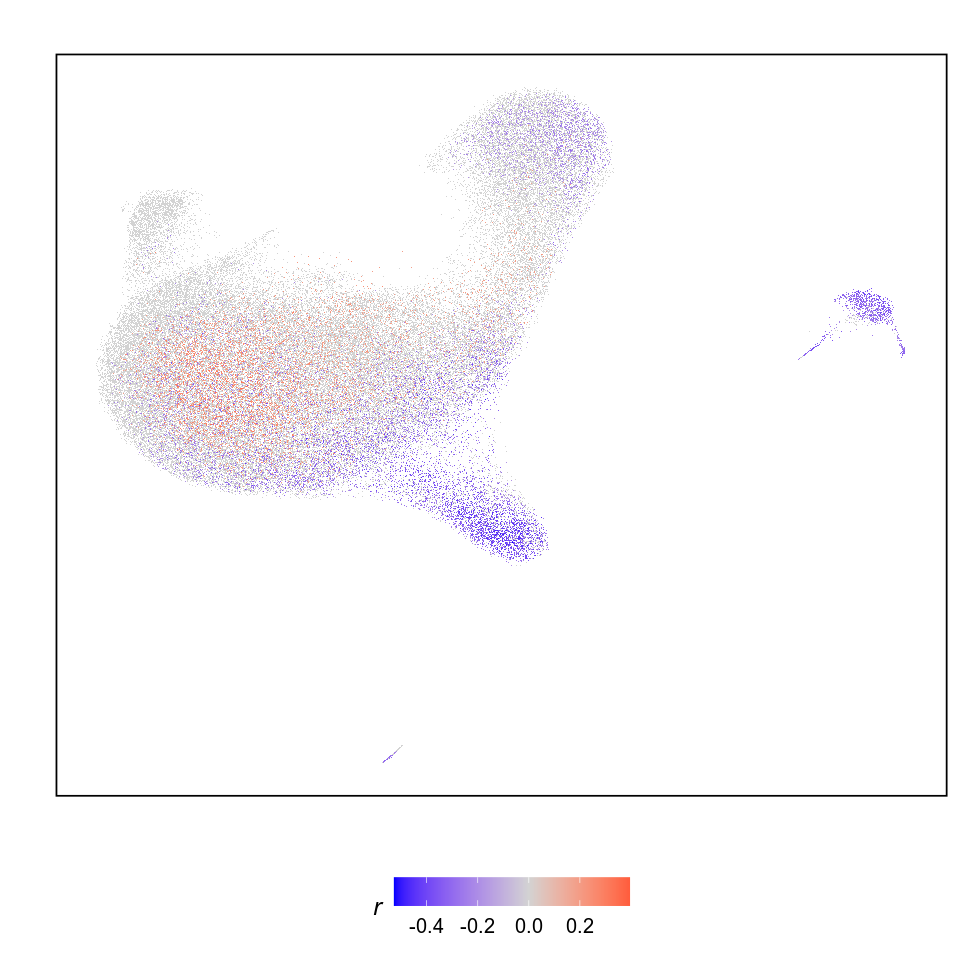

In [18]:
fdr_10 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = tmp_meta,
                 aes(x = UMAP_1, y = UMAP_2), color = 'lightgrey', size = 0.1, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation), size = 0.1, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
                           #breaks = c(-0.3, -0.15, 0, 0.15, 0.3)) + 
     # labs(x="UMAP1", y="UMAP2", title = "T/NK Chronicity: p = 0.006") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "bottom",
    legend.key.width = unit(1, 'cm'),
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r") 

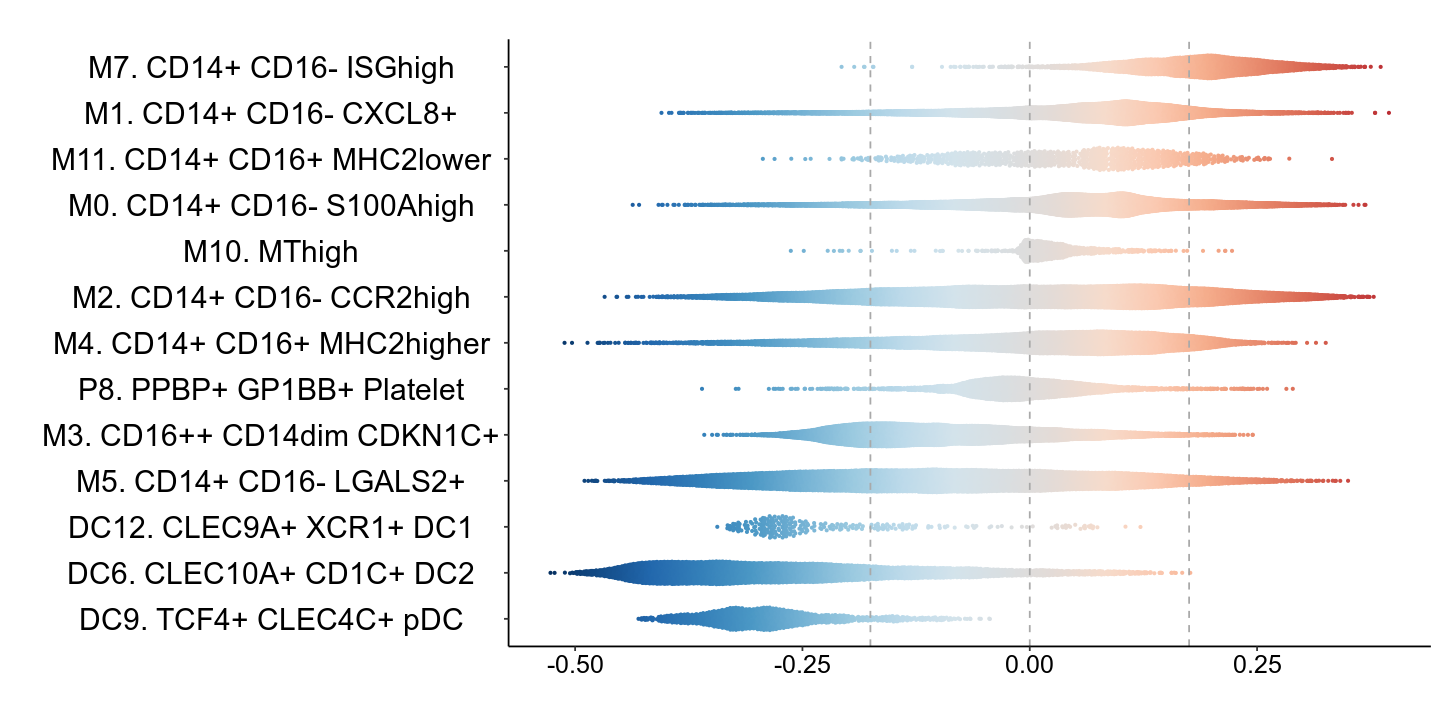

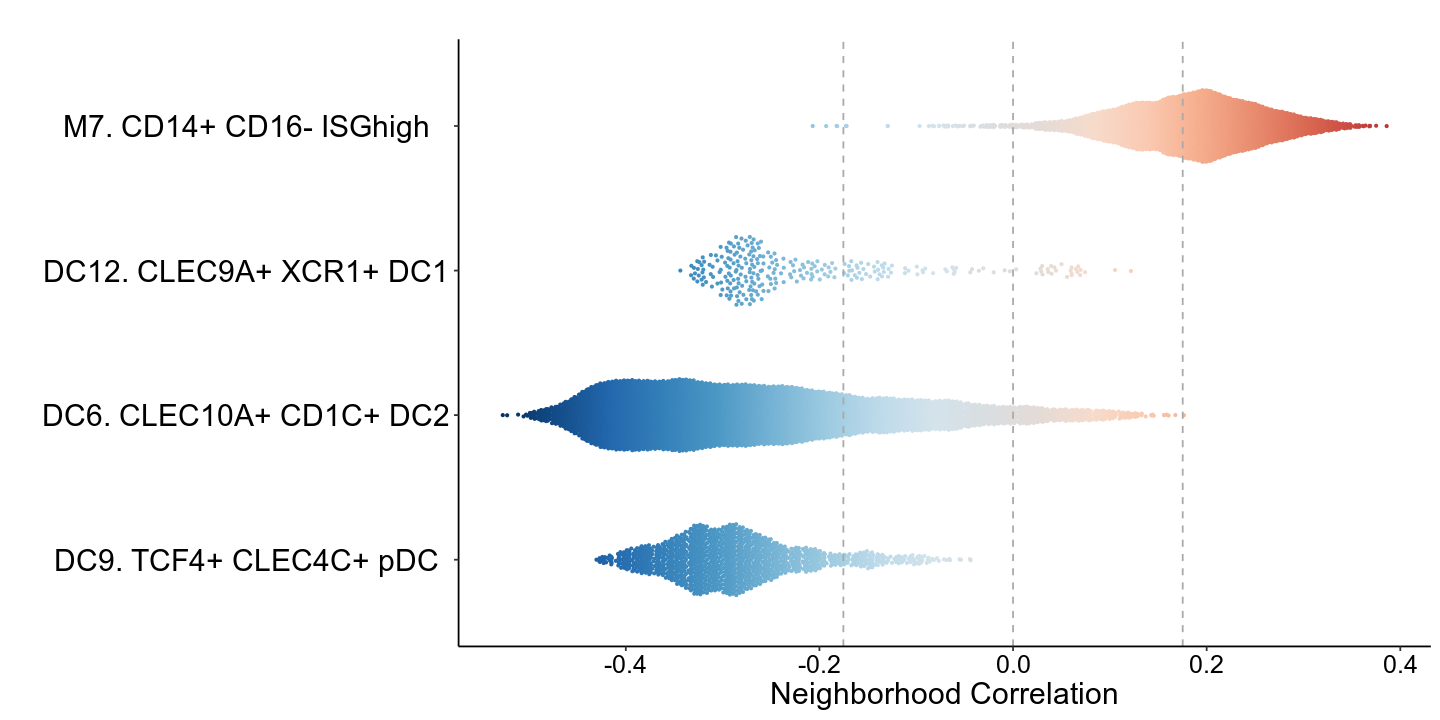

In [21]:
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)
ggplot(meta, aes(y = reorder(annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

subset <- c(9, 6, 12, 7)

ggplot(meta %>% filter(RNA_snn_res.0.75 %in% subset), 
       aes(y = reorder(annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [4]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata_new.rds')
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/meta.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/case_control/ncorr.csv", header = FALSE)
meta$ncorr <- ncorr$V1

ci_summary <- meta %>% 
                select(RNA_snn_res.0.75, Cell, ncorr) %>% 
                group_by(RNA_snn_res.0.75) %>% 
                summarize(ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(Cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(Cell)), 3), ")"))
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/myeloid_pbmc/case_control.rds') %>% 
            mutate(RNA_snn_res.0.75 = as.integer(str_remove(cluster, "cluster")),
               OR.ci = paste0("(", round(Type.OR.95pct.ci.lower, 3), ", ", 
                              round(Type.OR.95pct.ci.upper, 3), ")")) %>% 
         select(RNA_snn_res.0.75, OR.ci)

summary <- ci_summary %>% left_join(res)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc_casecontrol_corr_04192024.csv', 
          quote = FALSE, row.names = FALSE, sep = '\t')

Joining, by = "RNA_snn_res.0.75"


### DE

In [38]:
norm <- norm[, meta$Cell]

In [40]:
out <- mclapply(unique(meta$Unified_Visit), pseudobulk, meta, norm,
               mc.cores = 6)

In [41]:
myeloid_pb <- data.frame(do.call(rbind, out))
sample_stats <- meta %>% group_by(Unified_Visit) %>% summarize(avg_count = mean(nCount_RNA), 
                                                               avg_mt = mean(percent.mt))
myeloid_pb <- myeloid_pb %>% left_join(sample_stats) %>% left_join(unique(meta %>% select(Unified_Visit, Type)))
colnames(myeloid_pb)[1:36601] <- rownames(norm)

Joining, by = "Unified_Visit"
Joining, by = "Unified_Visit"


In [42]:
saveRDS(myeloid_pb, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/myeloid_pbmc_norm_pseudobulk_01042024.rds')

In [43]:
de_out <- mclapply(colnames(myeloid_pb)[1:36601], de, myeloid_pb, mc.cores = 20)

In [44]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [46]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/myeloid_case_control_differential_expression_pbmc_010422024.rds')

In [260]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/myeloid_case_control_differential_expression_pbmc_010422024.rds')

In [261]:
de_df <- de_df %>% na.omit()

In [262]:
de_df$FDR <- p.adjust(de_df$LRP, method = "BH")

In [251]:
genes <- c("COMMD6", "NCL", "FPR1", "FCER1A", "HLA-DPB1", "HLA-DPA1", 
           "IFITM3", "ISG15", "MX1", "CD163", "STAT1", "NEAT1")

Warning message:
“Removed 22840 rows containing missing values (`geom_text_repel()`).”


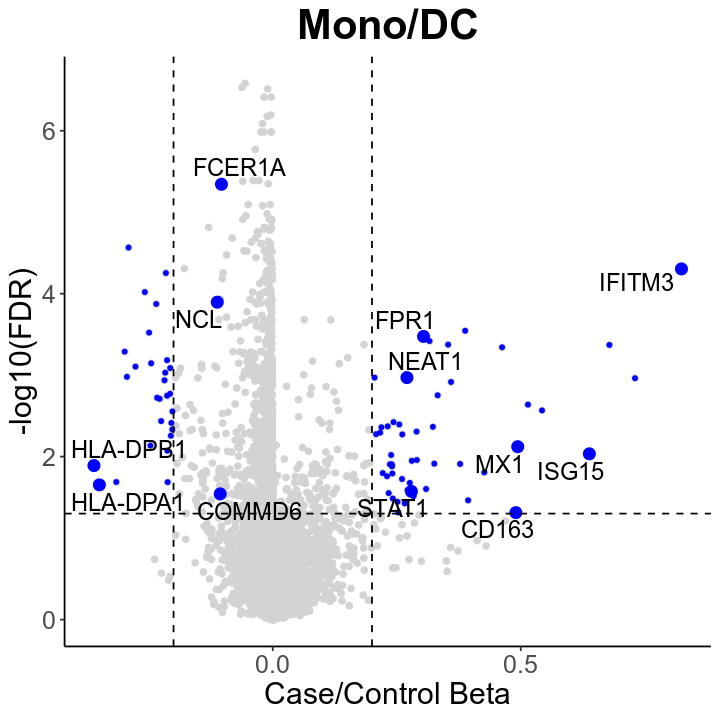

In [253]:
fig.size(6, 6)
ggplot(de_df,
                aes(x = Beta, y = -log10(FDR))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(FDR < 0.05 & abs(Beta) >= 0.2,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.2, 0.2), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(gene %in% genes, gene, NA)),
                                     aes(x = Beta, y = -log10(FDR), 
                                         size = 5, label = label), color = "black", 
                                     max.overlaps = 15) +
    scale_size_identity() + 
    labs(x = "Case/Control Beta", y = "-log10(FDR)", title = "Mono/DC")

## WITHIN CASES

In [235]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                        filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() 

In [236]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% filter(Donor %in% clinical_LN$AMP.Subject_ID) 

In [237]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                            left_join(clinical_LN) %>% 
                            left_join(first_biop_pred) %>% 
                            select(c(Cell, BARCODE, Sex, cell.type.ids, Unified_Visit, Donor,
                                     Responder.Status, Age, Race, Final_ISN, 
                                     Final_Chronicity, Final_Activity, Type, Final_Site,
                                     First_biop, Pred_use, individual, RNA_snn_res.0.25, RNA_snn_res.0.5, RNA_snn_res.0.75))  %>% 
                            rename(AMP.Subject_ID = Donor)

Joining, by = "individual"
Joining, by = "individual"


In [238]:
dim(SLE_pbmc_meta)

[1] 86906    20

## RESPONSE

In [57]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/response/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/response/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/response/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## CHRONICITY

In [58]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESULTS

In [116]:
annotations <- data.frame(RNA_snn_res.0.75 = as.character(seq(0, 12)),
                          annotation = c("M0. CD14+ CD16- S100Ahigh", 
                                         "M1. CD14+ CD16- CXCL8+",
                                         "M2. CD14+ CD16- CCR2high",
                                         "M3. CD16++ CD14dim CDKN1C+",
                                         "M4. CD14+ CD16+ MHC2higher",
                                         "M5. CD14+ CD16- LGALS2+",
                                         "DC6. CLEC10A+ CD1C+ DC2",
                                         "M7. CD14+ CD16- ISGhigh", 
                                         "P8. PPBP+ GP1BB+ Platelet",
                                         "DC9. TCF4+ CLEC4C+ pDC",
                                         "M10. MThigh",
                                         "M11. CD14+ CD16+ MHC2lower",
                                         "DC12. CLEC9A+ XCR1+ DC1"))

In [113]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_metadata_new.rds')
SLE_umap <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_mono_dc_pbmc_umap_new.rds')

Joining, by = c("Cell", "RNA_snn_res.0.75")


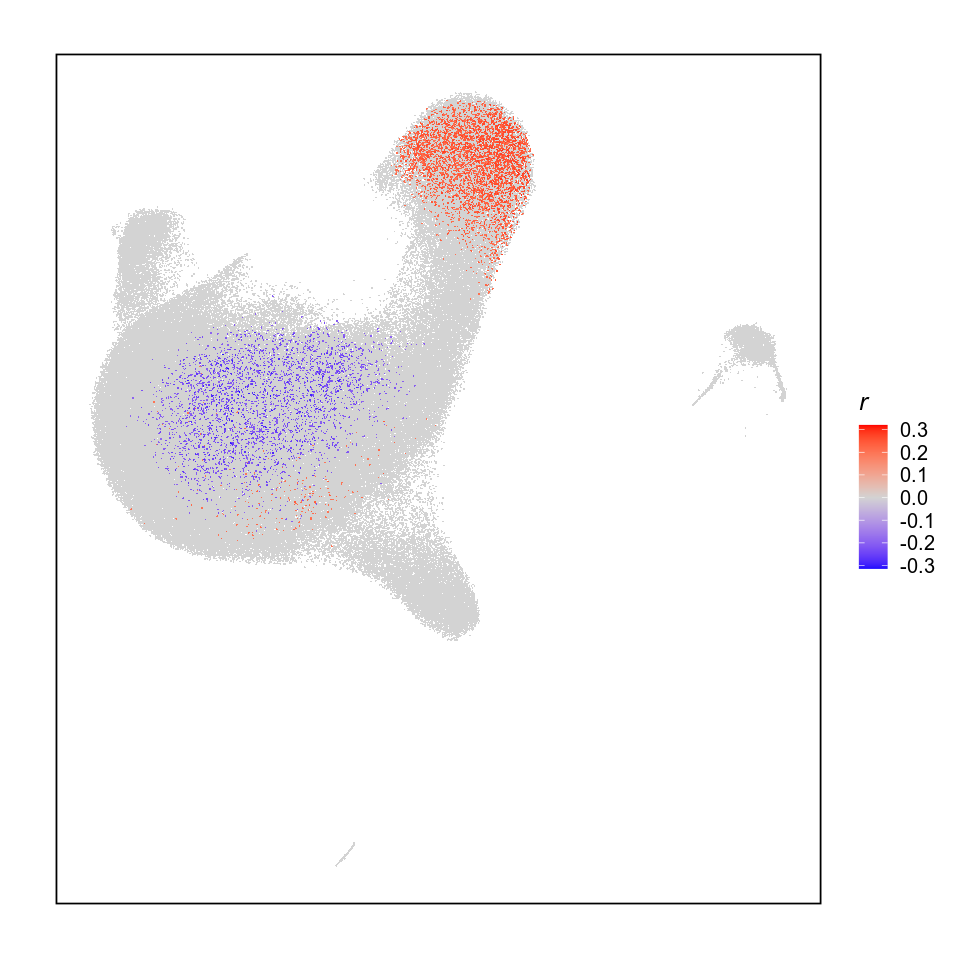

In [123]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.10) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA),
                           RNA_snn_res.0.75 = as.factor(RNA_snn_res.0.75)) %>% 
                    left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.75))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)

ggplot() + 
      geom_point(data = data.frame(SLE_umap),
                aes(x = UMAP_1, y = UMAP_2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "right",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")

Joining, by = c("RNA_snn_res.0.75", "annotation")


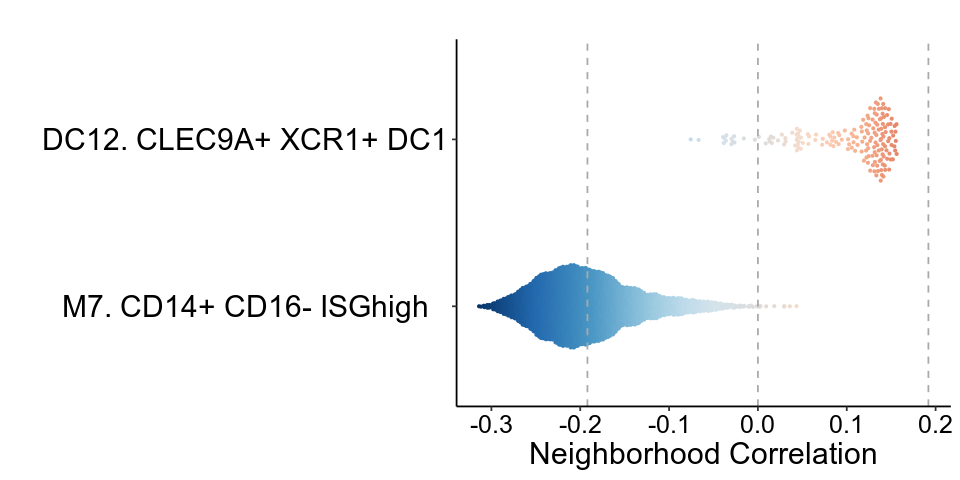

In [121]:
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))

meta <- meta %>%  
            mutate( RNA_snn_res.0.75 = as.factor(RNA_snn_res.0.75)) %>% 
            left_join(annotations)


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(4, 8)

ggplot(meta %>% filter(RNA_snn_res.0.75 %in% c(7, 12)), aes(y = reorder(annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

### CNA Prediction of Chronicity

In [17]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/meta.csv")

In [11]:
yresid_predicted <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/cond_y_resid_hat.csv", header = TRUE)

In [20]:
yresid_predicted <- yresid_predicted %>% 
                        left_join(meta %>% 
                                      select(Final_Chronicity, Unified_Visit) %>%
                                         unique())

Joining, by = "Unified_Visit"


In [37]:
cor.test(yresid_predicted$Predicted.Chronicity, yresid_predicted$Final_Chronicity)


	Pearson's product-moment correlation

data:  yresid_predicted$Predicted.Chronicity and yresid_predicted$Final_Chronicity
t = 3.6166, df = 89, p-value = 0.0004947
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1641063 0.5251825
sample estimates:
      cor 
0.3579534 


`geom_smooth()` using formula = 'y ~ x'


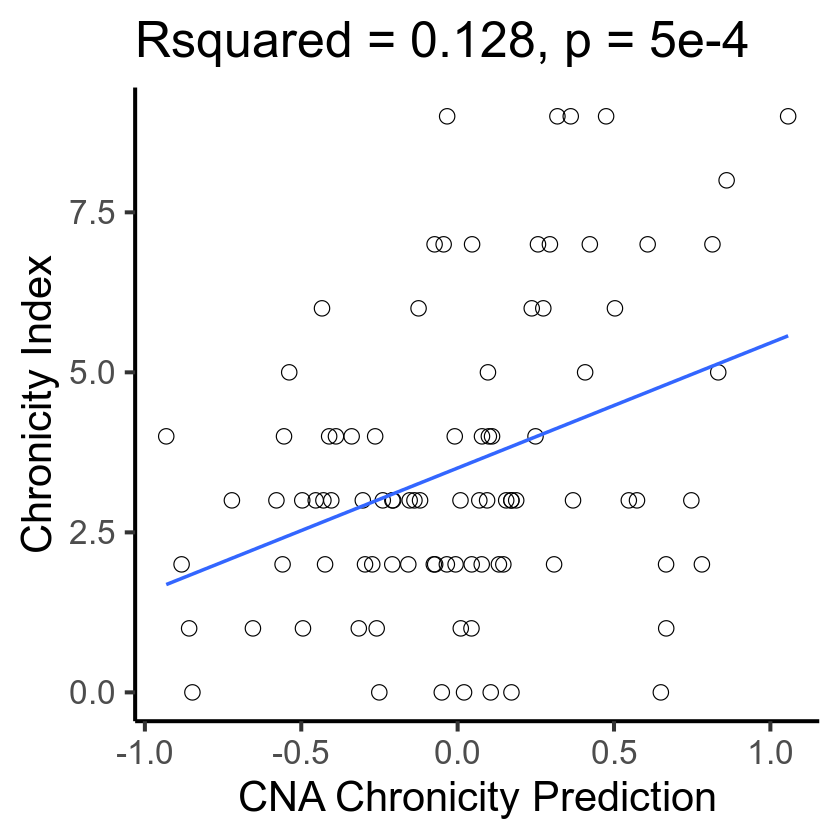

In [38]:
ggplot(yresid_predicted, aes(x = Predicted.Chronicity, y = Final_Chronicity)) + 
    geom_point(size = 4, shape = 1) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = "CNA Chronicity Prediction", 
         y = "Chronicity Index",
         title = "Rsquared = 0.128, p = 5e-4") + 
    theme_classic(base_size = 25) 

In [56]:
training_index <- sample(nrow(yresid_predicted), 75)
training <- yresid_predicted[training_index, ]
test <- yresid_predicted[seq(1, nrow(yresid_predicted))[-training_index], ]

### MASC

In [6]:
annotations <- data.frame(RNA_snn_res.0.75 = as.character(seq(0, 12)),
                          annotation = c("M0. CD14+ CD16- S100Ahigh", 
                                         "M1. CD14+ CD16- CXCL8+",
                                         "M2. CD14+ CD16- CCR2high",
                                         "M3. CD16++ CD14dim CDKN1C+",
                                         "M4. CD14+ CD16+ MHC2higher",
                                         "M5. CD14+ CD16- LGALS2+",
                                         "DC6. CLEC10A+ CD1C+ DC2",
                                         "M7. CD14+ CD16- ISGhigh", 
                                         "P8. PPBP+ GP1BB+ Platelet",
                                         "DC9. TCF4+ CLEC4C+ pDC",
                                         "M10. MThigh",
                                         "M11. CD14+ CD16+ MHC2lower",
                                         "DC12. CLEC9A+ XCR1+ DC1"))

In [30]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/meta.csv")

model_df <- meta %>% 
                mutate(RNA_snn_res.0.75 = as.character(RNA_snn_res.0.75)) %>% 
                    left_join(annotations) %>% mutate(Final_Chronicity = as.factor(Final_Chronicity))

res <- MASC.me(model_df, as.factor(model_df$RNA_snn_res.0.75),
                contrast = "Final_Chronicity",
                random_effects = c("Unified_Visit"),
                fixed_effects = c("Age", "Sex", 'First_biop', 'Responder_Status'),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Joining, by = "RNA_snn_res.0.75"
Using null model: cluster ~ Age + Sex + First_biop + Responder_Status + (1|Unified_Visit)

Creating logistic mixed models for cluster0

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00422703 (tol = 0.002, component 1)”
Creating logistic mixed models for cluster1

Creating logistic mixed models for cluster10

Creating logistic mixed models for cluster11

Creating logistic mixed models for cluster12

Creating logistic mixed models for cluster2

Creating logistic mixed models for cluster3

Creating logistic mixed models for cluster4

Creating logistic mixed models for cluster5

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00204239 (tol = 0.002, component 1)”
Creating logistic mixed models for cluster6

Creating logistic mixed models for cluster7

Creating logistic mixed models for clust

In [32]:
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/myeloid_pbmc/chronicity_covariates.rds')

In [176]:
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/myeloid_pbmc/chronicity_covariates.rds')

In [177]:
res <- res %>% 
        rowwise() %>% 
        mutate(cluster = ifelse(unlist(str_split(cluster, 'cluster'))[2] %in% c(6, 9, 12), 
                                paste0('DC', unlist(str_split(cluster, 'cluster'))[2]),
                                paste0('M', unlist(str_split(cluster, 'cluster'))[2])))

Warning message:
“Removed 11 rows containing missing values (`geom_label_repel()`).”


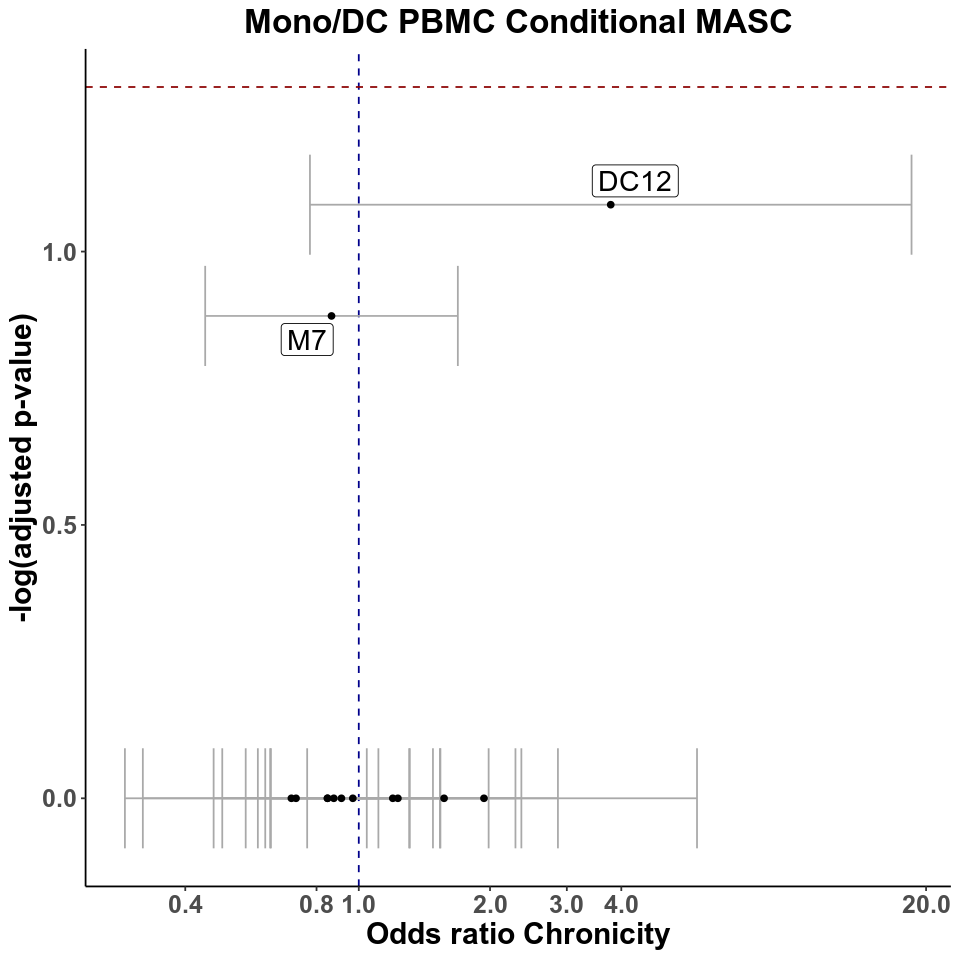

In [180]:
fig.size(8, 8)
ggplot(data = res %>% mutate(label = ifelse(-log10(model.pvalue) > -log10(0.05), cluster, NA)), 
       aes(x = Final_Chronicity1.OR, y = -log10(bonferroni))) +
    theme_classic() + ylab("-log(adjusted p-value)") + xlab("Odds ratio Chronicity") + 
    labs(title = "Mono/DC PBMC Conditional MASC") +
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=Final_Chronicity1.OR.95pct.ci.lower	, xmax=Final_Chronicity1.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(.05), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.1, 0.4, 0.8, 1, 2, 3, 4, 20)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(plot.title = element_text(size = 20, hjust = 0.5, face = "bold"),
          axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"))

### DE

In [165]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, Unified_Visit, 
                              Final_Chronicity, avg_count, avg_mt, Age, Sex) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.1 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Final_Chronicity, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['Final_Chronicity', 'Estimate']
        SE <- summary(m_1)$coefficients['Final_Chronicity', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [133]:
myeloid_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/myeloid_pbmc_norm_pseudobulk_01042024.rds')
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/chronicity/meta.csv")

In [134]:
myeloid_pb <- myeloid_pb %>% 
                filter(Unified_Visit %in% unique(meta$Unified_Visit)) %>% 
                left_join(meta %>% 
                              select(Unified_Visit, Age, Sex, Final_Chronicity) %>% 
                              unique())

Joining, by = "Unified_Visit"


In [166]:
de_out <- mclapply(colnames(myeloid_pb)[1:36601], de, myeloid_pb, mc.cores = 20)

In [171]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [150]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/myeloid_chronicity_differential_expression_pbmc_032922024.rds')

In [25]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/myeloid_chronicity_differential_expression_pbmc_032922024.rds')

In [26]:
de_df <- de_df %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) 

In [28]:
de_df %>% arrange(Beta)

gene     LRP          F         Beta        SE          FDR      
1     ISG15    0.0025362931  9.607492 -0.09043759 0.02917722  0.2922134
2     IFI44L   0.0015964590 10.550132 -0.08944637 0.02753809  0.2842894
3     IFI6     0.0005363370 12.826120 -0.08571122 0.02393261  0.2181014
4     S100A8   0.0065137490  7.733188 -0.08072484 0.02902872  0.3722835
5     VCAN     0.0018466814 10.252096 -0.06653113 0.02077871  0.2842894
6     MX1      0.0074006513  7.484612 -0.06142526 0.02245238  0.3839698
7     S100A9   0.0208136857  5.521220 -0.06094537 0.02593721  0.4711700
8     IFITM3   0.0230125777  5.335724 -0.06018753 0.02605613  0.4827892
9     THBS1    0.0466207317  4.062168 -0.06017619 0.02985697  0.5773460
10    LY6E     0.0121639264  6.529505 -0.05595801 0.02189889  0.4170864
11    IFI44    0.0012172610 11.108922 -0.05432921 0.01630037  0.2688875
12    S100A12  0.0185275577  5.737356 -0.05203497 0.02172398  0.4575444
13    CD14     0.0008864051 11.768489 -0.04998003 0.01456921  0.2603621
14    MX2      0.0020334956 10.055617 -0.04869801 0.01535702  0.2842894
15    MT2A     0.0294464847  4.884734 -0.04835571 0.02187899  0.5202977
16    NAMPT    0.0780924655  3.170884 -0.04722647 0.02652133  0.6450504
17    CEBPD    0.0057454045  7.978830 -0.04692493 0.01661246  0.3621461
18    SIGLEC1  0.0013099878 10.957177 -0.04626788 0.01397752  0.2688875
19    EPSTI1   0.0005752258 12.677829 -0.04614697 0.01296047  0.2263699
20    SLC2A3   0.0090528333  7.094842 -0.04595364 0.01725236  0.3990876
21    FOS      0.1003878029  2.751593 -0.04561775 0.02750058  0.6862146
22    APOBEC3A 0.0569054332  3.713345 -0.04293541 0.02228091  0.5920791
23    EIF2AK2  0.0007952762 11.995535 -0.04282672 0.01236531  0.2467533
24    PLSCR1   0.0004119592 13.387728 -0.04205265 0.01149317  0.2181014
25    GLUL     0.0002083853 14.857751 -0.04183383 0.01085303  0.1990343
26    XAF1     0.0224656677  5.380058 -0.04108129 0.01771131  0.4800952
27    OAS2     0.0028751064  9.354669 -0.04101174 0.01340893  0.3020968
28    FKBP5    0.1621705465  1.983966 -0.04024151 0.02856980  0.7397484
29    PARP14   0.0155957008  6.059709 -0.03979734 0.01616695  0.4409264
30    IFIT3    0.0206036522  5.540008 -0.03779423 0.01605722  0.4711700
⋮     ⋮        ⋮            ⋮         ⋮           ⋮           ⋮        
24370 RPS8     1.179427e-02  6.588222 0.02404093  0.009366280 0.4170864
24371 RPS27    7.570562e-03  7.440543 0.02433324  0.008920672 0.3839698
24372 RPL26    9.869306e-03  6.928825 0.02450951  0.009311183 0.4053892
24373 RPL3     3.191396e-03  9.145055 0.02521497  0.008338066 0.3139794
24374 RPS10    9.411566e-03  7.020052 0.02553987  0.009639367 0.4009410
24375 MS4A7    5.323454e-02  3.829447 0.02601871  0.013295898 0.5880629
24376 RPL21    7.540540e-03  7.448255 0.02682473  0.009828971 0.3839698
24377 LST1     1.286196e-02  6.423549 0.02706499  0.010678749 0.4211321
24378 HLA-DMB  5.083445e-04 12.939879 0.02733671  0.007599432 0.2181014
24379 RPL10    2.862151e-03  9.363756 0.02755361  0.009004374 0.3020968
24380 RPL10A   3.599627e-03  8.904254 0.02827104  0.009474210 0.3309736
24381 POU2F2   2.097519e-02  5.506908 0.02853300  0.012158878 0.4711700
24382 FCGR3A   1.001579e-01  2.755373 0.02872014  0.017302002 0.6862146
24383 RPL5     6.602256e-03  7.706847 0.02934996  0.010572292 0.3722835
24384 IRF1     2.385846e-02  5.269297 0.02986839  0.013011745 0.4892367
24385 TMEM176B 1.032147e-01  2.705899 0.03080393  0.018726233 0.6880337
24386 CD74     2.072374e-02  5.529241 0.03082938  0.013110884 0.4711700
24387 EEF1B2   3.401892e-04 13.797820 0.03212508  0.008648465 0.2148191
24388 CLEC12A  3.672093e-02  4.486432 0.03222861  0.015215670 0.5486711
24389 HLA-DQA1 4.163001e-03  8.614750 0.03243855  0.011051980 0.3355304
24390 CALHM6   1.805252e-03 10.298448 0.03344009  0.010420333 0.2842894
24391 KLF2     2.078626e-02  5.523662 0.03393439  0.014438647 0.4711700
24392 RPS3A    1.609441e-03 10.533518 0.03446695  0.010619796 0.2842894
24393 CRIP1    4.207291e-02  4.243758 0.036286

## ACTIVITY

In [59]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/activity/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/activity/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/activity/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## ISN

In [60]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESULTS

Joining, by = "Cell"


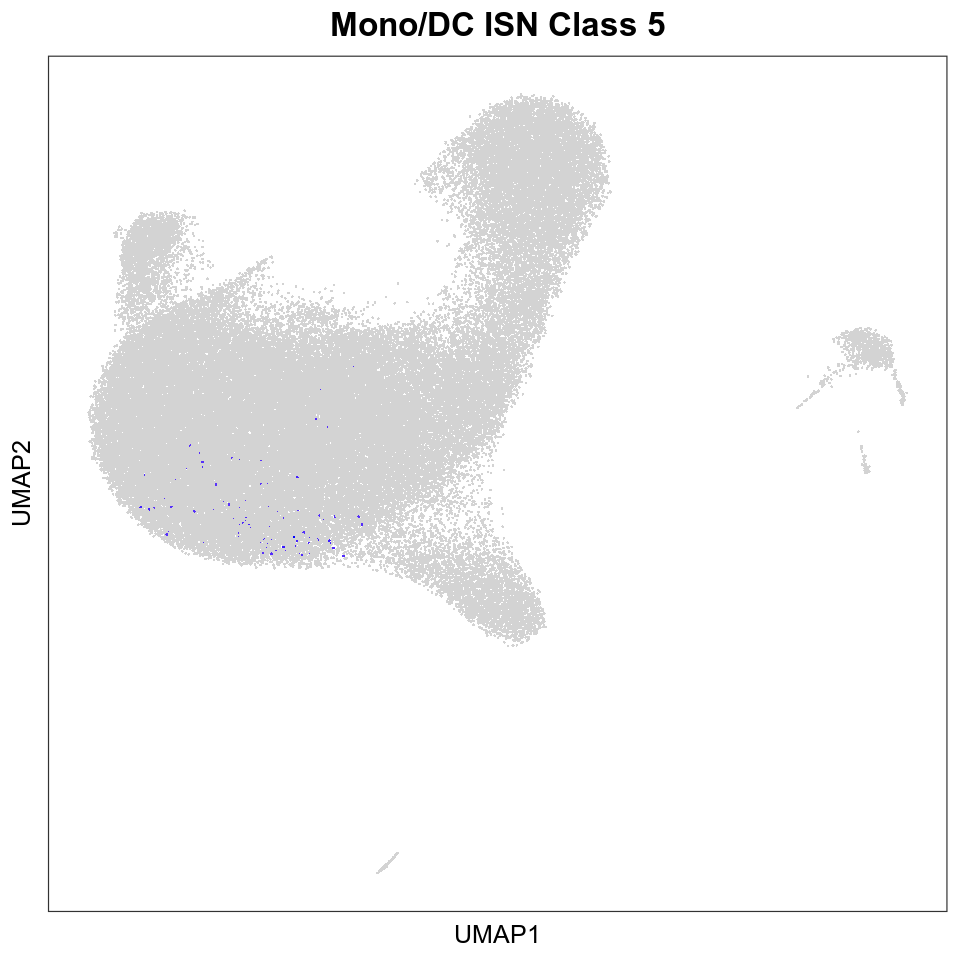

In [11]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/class_5_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/class_5_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.11) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) %>% 
                    left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.5))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(
      data = tmp_meta %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation),
        size = 0.75, stroke = 0.00001) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Mono/DC ISN Class 5") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

In [4]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/class_5_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/class_5_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

meta <- meta %>% 
            left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.5))

pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

ggplot(meta, aes(x = reorder(RNA_snn_res.0.5, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

Warning message in file(file, "rt"):
“cannot open file '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/mono_dc/isn/cond_class_5_ncorr.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


# CNA PREP - B CELL

In [ ]:
norm <- readRDS('/data/srlab/ssg34/SLE_pbmc_analysis/data/gene_expression/b_cell_qcd_seurat_sc_analysis_08252023.rds')[['RNA']]@data
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_metadata.rds')
SLE_harmony <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_hPCs.rds')
SLE_umap <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_umap.rds')

In [ ]:
annotations <- data.frame(RNA_snn_res.0.25 = as.character(seq(0, 8)),
                          annotation = c("bl-B0. CXCR5high Naive",
                                         "bl-B1. CRIP1+ Mature",
                                         "bl-B2. FCRL5+ ITGAX+ ABC",
                                         "bl-B3. CD79A+ VREPB3+ pre B Cell",
                                         "bl-B4. ISGhigh Naive",
                                         "bl-B5. MThigh",
                                         "bl-B6. JUN+ NFKB1+ Activated",
                                         "bl-B7. IGKC+ XBP1+ Plasma-like", 
                                         "bl-B8. FCRL5+ IGHG1+ B Cell"))


In [ ]:
SLE_pbmc_meta <- left_join(SLE_pbmc_meta, annotations)

In [82]:
SLE_pbmc_meta <- cbind(SLE_pbmc_meta, SLE_umap)
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame()


SLE_pbmc_LN <- SLE_pbmc_meta %>% 
                    filter(Type == "SLE", individual %in% kidney_immune_meta$individual) 

SLE_pbmc_control <- SLE_pbmc_meta %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control")) %>% 
                        filter(Type == "Control")

filtered_meta <- rbind(SLE_pbmc_LN, SLE_pbmc_control)
saveRDS(filtered_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_metadata_filtered_V0_cases_controls_07182024.rds')

In [ ]:
filtered_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_metadata_filtered_V0_cases_controls_07182024.rds')

In [430]:
# Update cluster names
filtered_meta= filtered_meta %>% select(-annotation) %>% left_join(annotations)

Joining with `by = join_by(RNA_snn_res.0.25)`


In [431]:
name = 'B'

In [168]:
ncells = filtered_meta %>% nrow

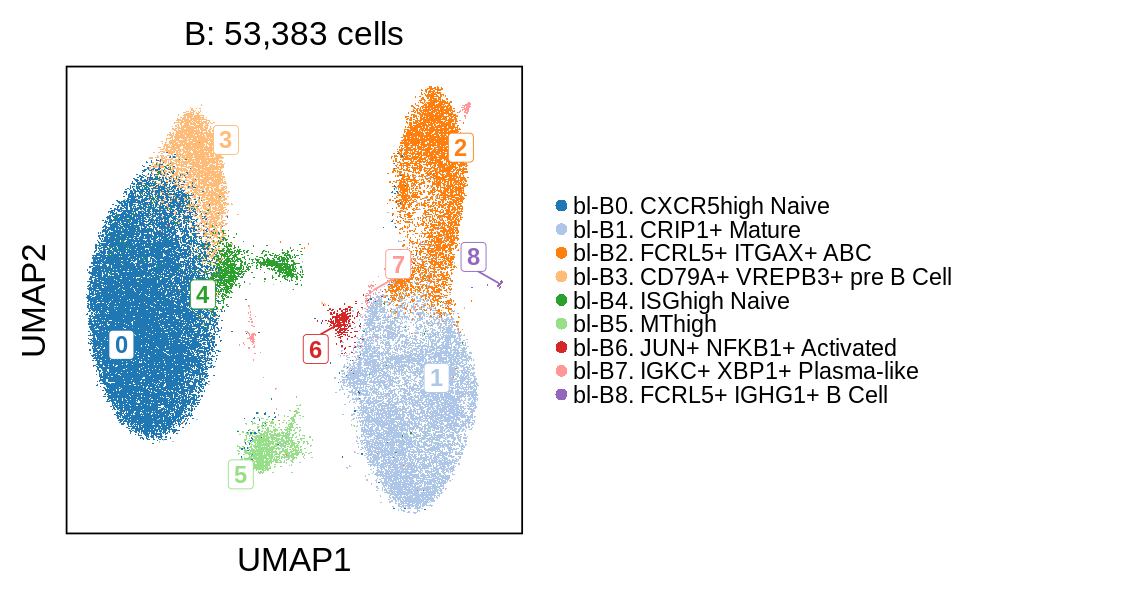

In [170]:
options(warn=-1)
cluster_center <- filtered_meta %>%
                  mutate(RNA_snn_res.0.25 = as.numeric(RNA_snn_res.0.25)) %>% 
                  group_by(RNA_snn_res.0.25, annotation) %>%
                  summarise_at(vars(UMAP_1, UMAP_2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

cluster_center <- cluster_center[order(cluster_center$RNA_snn_res.0.25), ]

options(repr.plot.height = 9, repr.plot.width = 18)
p <- ggplot() +
      geom_point(
        data = filtered_meta[sample(nrow(filtered_meta)), ] %>% 
          select(UMAP_1, UMAP_2, RNA_snn_res.0.25, annotation) %>% 
                  mutate(annotation = factor(annotation, 
                                                   levels = cluster_center$annotation)),
        aes(x = UMAP_1, y = UMAP_2, color = annotation),
          size = 0.7, shape = 20, stroke = 0.0001) +
      ggrepel::geom_label_repel(
        data = cluster_center,
        aes(x = UMAP_1, y = UMAP_2, 
            label = RNA_snn_res.0.25, color = factor(annotation, 
                                                     levels = cluster_center$annotation)),
        size = 5,  fontface = "bold",
        box.padding = unit(0.5, "lines"),
        point.padding = unit(0.01, "lines"),
        show.legend = FALSE
      ) +
    ggthemes::scale_color_tableau(palette = "Classic 20") + 
    # scale_color_manual(values = as.vector(polychrome(20))) +
theme_classic(base_size = tickfontsize) +
  theme(
         plot.title = element_text(size = labelfontsize, hjust = 0.5),
          axis.title = element_text(size = labelfontsize), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          text=element_text(family="Arial"),
          legend.text = element_text(size = 14,
                                     margin = margin(t = 0, b = 0, unit = "pt")),
          legend.title = element_blank(),
          legend.key.size = unit(0.4, "cm"),           # Adjust size of legend key
          legend.spacing.y = unit(0, "cm"),           # Adjust spacing between legend items
            legend.justification = "left",  
  )+
        labs(x = "UMAP1", y = "UMAP2", 
             title = paste0(name, ': ', format(ncells,big.mark=",",scientific=FALSE), ' cells'),
            col = '') +
        guides(color = guide_legend(ncol = 1, byrow = TRUE, override.aes = list(size = 5)))
legend <- cowplot::get_legend(p)
p = p + theme(legend.position = "none")
legend = cowplot::plot_grid(legend)
outplot = p + legend + plot_layout(widths = c(1, 1.3))

height = 5
width = 9.5
fig.size(height, width)
outplot

ggsave(paste0(figdir, 'pbmc_b_umap_sc.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'pbmc_b_umap_sc.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)


In [432]:
bcell_de <- wilcoxauc(norm[, filtered_meta$Cell], filtered_meta$annotation)

In [472]:
filter_genes <- c("MS4A1", "BCL6", "PAX5","IL7R", "TCL1A", "CXCR4", "CD27",
                  "IGHM", "IGHD",
                  "CXCR5", "CRIP1",
                  "FCRL5", "ITGAX", "CD79A", "VPREB3",
                  "ISG15", "IFI44L", "JUN", "NFKB1",
                  "IGKC", "XBP1",
                  "IGHA1", "IGHG1")

In [473]:
plot_df <- bcell_de %>% filter(feature %in% filter_genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [474]:
dat = plot_df %>%  rename(percent = pct_in,
                             zscore = avgExpr_scaled)
dat$zscore = dat$zscore %>% as.numeric
vmax = (abs(dat$zscore) %>% quantile(.95))[[1]] %>% round(1)
vmin = -vmax

In [475]:
# clus_order = dat$group %>% unique %>% sort

clus_order = c(
         "bl-B5. MThigh",
         "bl-B3. CD79A+ VREPB3+ pre B Cell",
        "bl-B0. CXCR5high Naive",
         "bl-B4. ISGhigh Naive",
         "bl-B1. CRIP1+ Mature",
         "bl-B6. JUN+ NFKB1+ Activated",
         "bl-B7. IGKC+ XBP1+ Plasma-like", 
         "bl-B8. FCRL5+ IGHG1+ B Cell",
         "bl-B2. FCRL5+ ITGAX+ ABC"

)

In [476]:
setdiff(dat$group, clus_order)
setdiff(clus_order, dat$group)

character(0)

character(0)

In [406]:
# gene_order = c()
# gene_order = c(gene_order, setdiff(dat$feature %>% unique, gene_order))

In [477]:
gene_order = c("MS4A1", "PAX5",
            "IGHM", "IGHD",
              "IL7R", "TCL1A",
                "CD79A", "VPREB3",
                          "CXCR5", "CXCR4",

              "ISG15", "IFI44L", 
             "CRIP1",
               "CD27",
              "JUN", "NFKB1", 
              "IGKC", "XBP1",
               "BCL6",
               
              "IGHA1", "IGHG1",
            "FCRL5", "ITGAX"
    
)
gene_order = c(gene_order, setdiff(dat$feature %>% unique, gene_order))

In [478]:
setdiff(dat$feature, gene_order)
setdiff(gene_order, dat$feature)

character(0)

character(0)

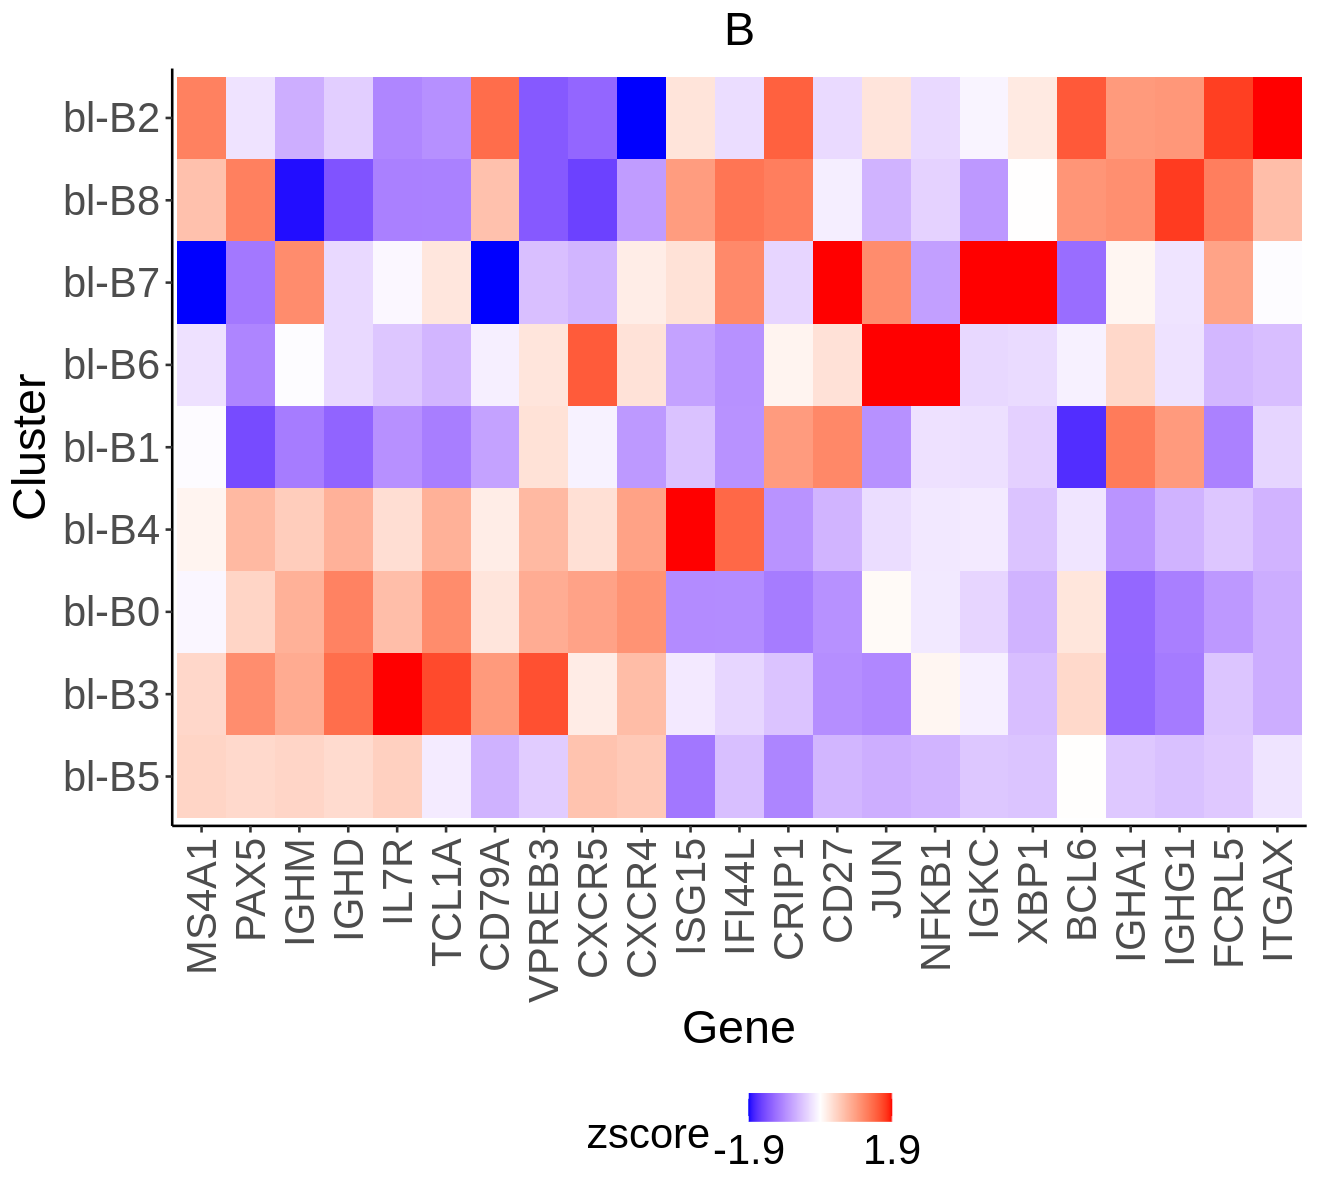

In [480]:

marker_heatmap = ggplot(dat, 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = tickfontsize) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(vmin, vmax), 
                         oob = scales::squish, breaks = c(vmin, vmax)) + 
    scale_x_discrete(limits = gene_order) + 
    scale_y_discrete(limits = clus_order, labels =clus_order %>% str_split('[.]') %>% map(1) %>% unlist) + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5),
          axis.text = element_text( size = labelfontsize+5),
          axis.title = element_text(size = labelfontsize+8), 
          plot.title = element_text(size = labelfontsize+8, hjust = 0.5), 
          legend.text = element_text(size = labelfontsize+5),
          legend.title = element_text(size = labelfontsize+5),
          legend.position = 'bottom'

         ) + 
    labs(x = "Gene", y = "Cluster", fill = 'zscore  ', title = name)

height = 10
width = 11
fig.size(height, width)

outplot = marker_heatmap
outplot

ggsave(paste0(figdir, 'b_pbmc_heatmap_markers.png'), plot = outplot,  
       height = height, width = width, dpi = 500)
ggsave(paste0(figdir, 'b_pbmc_heatmap_markers.pdf'), plot = outplot,  
       height = height, width = width, dpi = 500, device = cairo_pdf)

## CASE/CONTROL

In [111]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                    left_join(SLE_donors %>% select(Donor, Type) %>% unique(), by = "Donor") %>% 
                    filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame()


individuals <- kidney_immune_meta %>% 
                        filter(broad_cell_type %in% c("B Cell", "Plasma Cell")) %>% 
                        pull(individual) %>% unique()

SLE_pbmc_LN <- SLE_pbmc_meta %>% 
                    filter(Type == "SLE", individual %in% individuals) 

SLE_pbmc_control <- SLE_pbmc_meta %>% 
                        mutate(Type = ifelse(Type == "SLE", Type, "Control")) %>% 
                        filter(Type == "Control")

SLE_pbmc_case_control <- rbind(SLE_pbmc_LN, SLE_pbmc_control)

In [112]:
meta <- SLE_pbmc_case_control

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta <- meta %>% mutate(Type = ifelse(Type == "SLE", 1, 0))

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/umap.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

In [54]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1
meta <- meta %>% mutate(RNA_snn_res.0.25 = as.factor(RNA_snn_res.0.25)) %>% left_join(annotations)

Joining, by = "RNA_snn_res.0.25"


In [24]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/meta.csv")
control <- meta %>% filter(Type == 0) %>% 
                group_by(RNA_snn_res.0.25) %>% 
                summarize(samples = length(unique(Unified_Visit)),
                          ncells = length(unique(Cell))) %>% 
                mutate(control = paste0(samples, " (", ncells, ")")) %>% select(RNA_snn_res.0.25, control)
LN <- meta %>% filter(Type == 1) %>% 
                group_by(RNA_snn_res.0.25) %>% 
                summarize(samples = length(unique(Unified_Visit)),
                          ncells = length(unique(Cell))) %>% 
                mutate(LN = paste0(samples, " (", ncells, ")")) %>% select(RNA_snn_res.0.25, LN)
merged <- LN %>% left_join(control) %>% left_join(LN) %>% left_join(control)
merged[is.na(merged)] <- "0 (0)"
write.csv(merged, 
          '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/bcell_summary_04192024.csv', 
          quote = FALSE, row.names = FALSE)

Joining, by = "RNA_snn_res.0.25"
Joining, by = c("RNA_snn_res.0.25", "LN")
Joining, by = c("RNA_snn_res.0.25", "control")


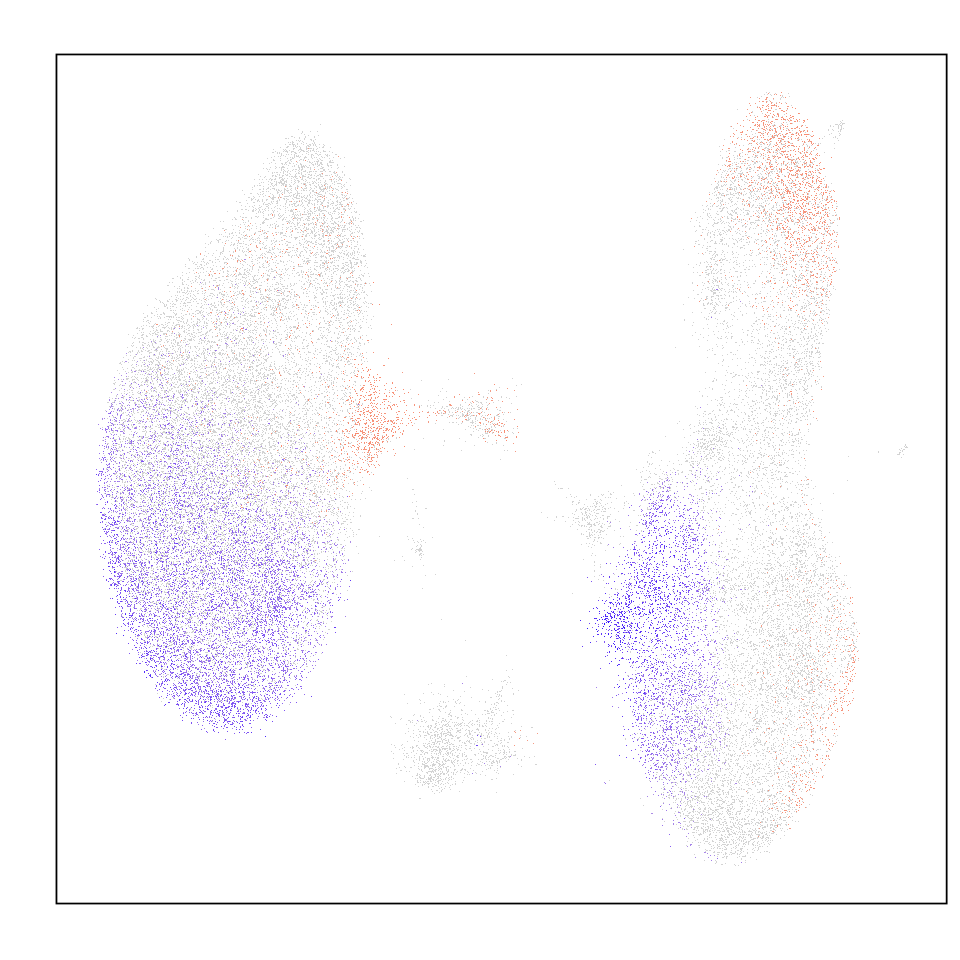

In [30]:
fdr_10 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = tmp_meta,
                 aes(x = UMAP_1, y = UMAP_2), color = 'lightgrey', size = 0.5, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation), size = 0.5, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
                           #breaks = c(-0.3, -0.15, 0, 0.15, 0.3)) + 
     # labs(x="UMAP1", y="UMAP2", title = "T/NK Chronicity: p = 0.006") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
    legend.key.width = unit(1, 'cm'),
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r") 

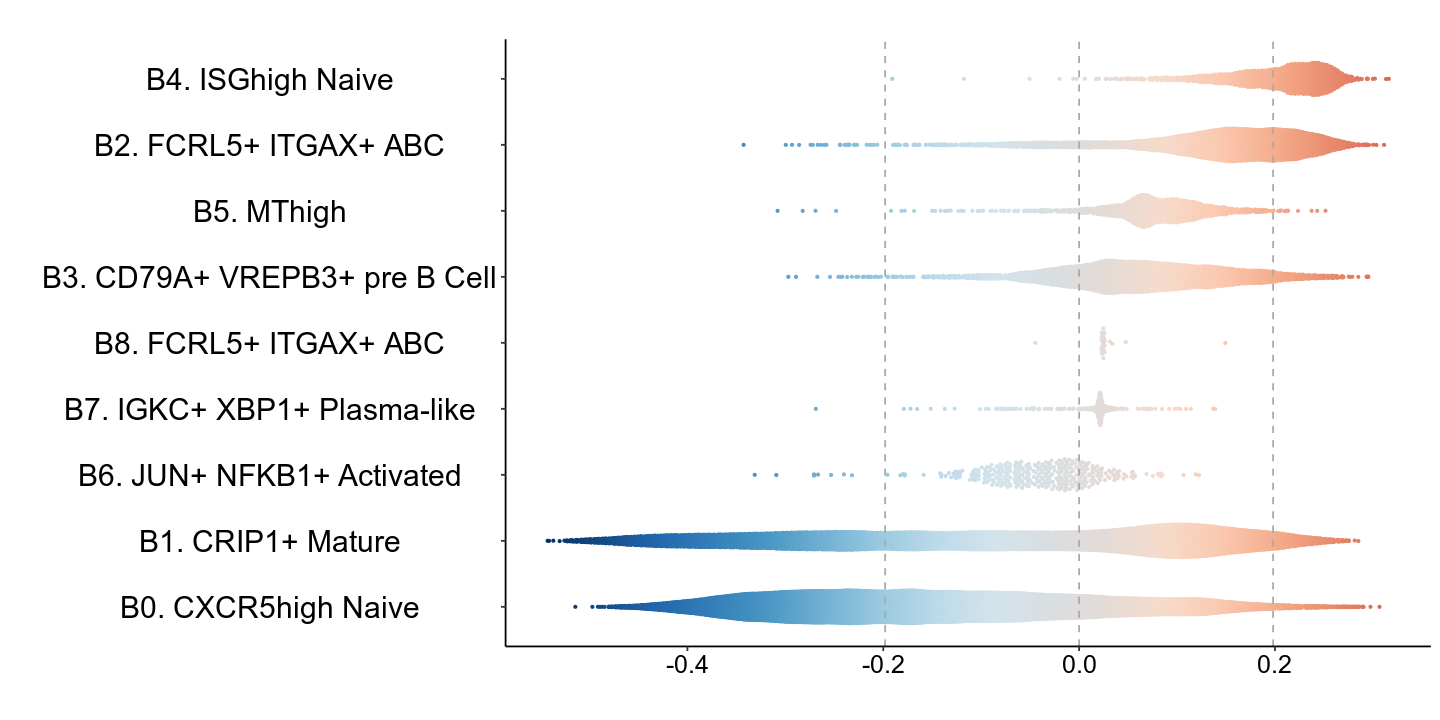

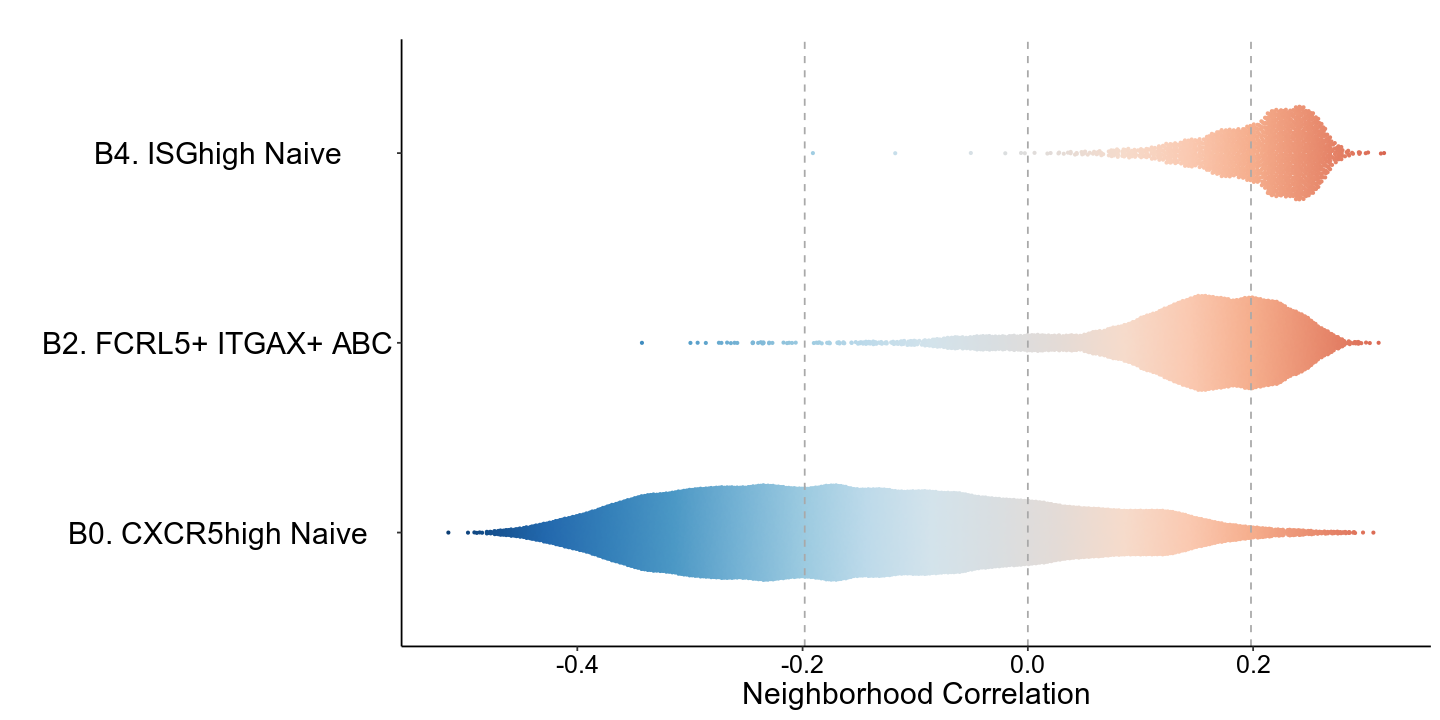

In [33]:
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)
ggplot(meta, aes(y = reorder(annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

subset <- c(0, 2, 4)

ggplot(meta %>% filter(RNA_snn_res.0.25 %in% subset), aes(y = reorder(annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [63]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/meta.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/case_control/ncorr.csv", header = FALSE)
meta$ncorr <- ncorr$V1

ci_summary <- meta %>% 
                select(RNA_snn_res.0.25, Cell, ncorr) %>% 
                group_by(RNA_snn_res.0.25) %>% 
                summarize(ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(Cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(Cell)), 3), ")"))
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/bcell_pbmc/case_control.rds') %>% 
            mutate(RNA_snn_res.0.25 = as.numeric(str_remove(cluster, "cluster")),
               OR.ci = paste0("(", round(Type.OR.95pct.ci.lower, 3), ", ", 
                              round(Type.OR.95pct.ci.upper, 3), ")")) %>% 
        select(RNA_snn_res.0.25, OR.ci)

summary <- ci_summary %>% left_join(res)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/bcell_casecontrol_corr_04192024.csv', 
          quote = FALSE, row.names = FALSE, sep = '\t')

Joining, by = "RNA_snn_res.0.25"


### DE

In [58]:
norm <- norm[, meta$Cell]

In [64]:
out <- mclapply(unique(meta$Unified_Visit), pseudobulk, meta, norm,
               mc.cores = 6)

In [66]:
b_pb <- data.frame(do.call(rbind, out))
sample_stats <- meta %>% group_by(Unified_Visit) %>% summarize(avg_count = mean(nCount_RNA), 
                                                               avg_mt = mean(percent.mt))
b_pb <- b_pb %>% left_join(sample_stats) %>% left_join(unique(meta %>% select(Unified_Visit, Type)))
colnames(b_pb)[1:36601] <- rownames(norm)

Joining, by = "Unified_Visit"
Joining, by = "Unified_Visit"


In [67]:
saveRDS(b_pb, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/bcell_pbmc_norm_pseudobulk_01042024.rds')

In [68]:
de_out <- mclapply(colnames(b_pb)[1:36601], de, b_pb, mc.cores = 20)

In [69]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [70]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/bcell_case_control_differential_expression_pbmc_010422024.rds')

In [265]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/bcell_case_control_differential_expression_pbmc_010422024.rds')

In [266]:
de_df <- de_df %>% na.omit()

In [267]:
de_df$FDR <- p.adjust(de_df$LRP, method = "BH")

In [271]:
genes <- c("COMMD6", "JCHAIN", "CALHM6", "IL4R", "MX1", "IFI44L", "NEAT1", "LY6E")

Warning message:
“Removed 21319 rows containing missing values (`geom_text_repel()`).”


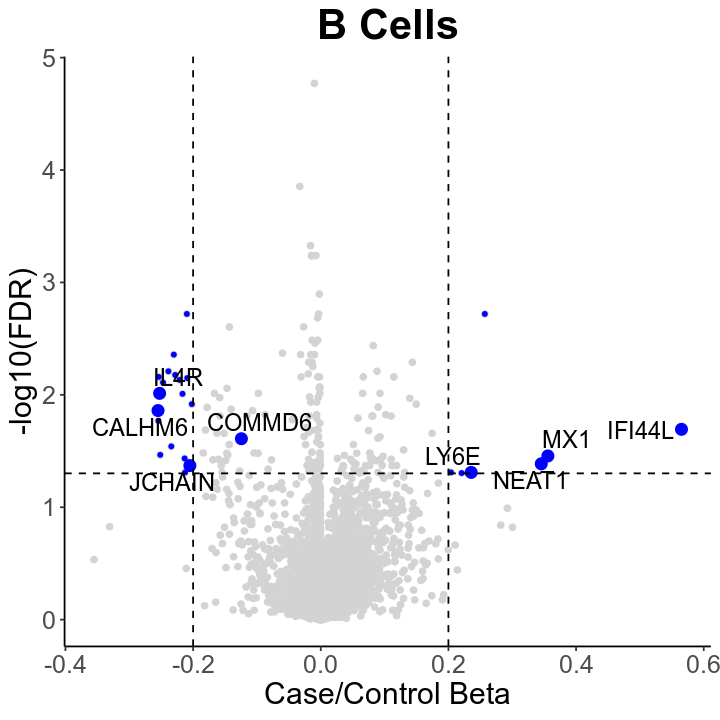

In [273]:
fig.size(6, 6)
ggplot(de_df,
                aes(x = Beta, y = -log10(FDR))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(FDR < 0.05 & abs(Beta) >= 0.2,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.2, 0.2), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(gene %in% genes, gene, NA)),
                                     aes(x = Beta, y = -log10(FDR), 
                                         size = 5, label = label), color = "black", 
                                     max.overlaps = 15) +
    scale_size_identity() + 
    labs(x = "Case/Control Beta", y = "-log10(FDR)", title = "B Cells")

## WITHIN CASES

In [162]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                        filter(str_detect(Unified_Visit, "-V0")) %>% 
                        mutate(individual = str_split(Unified_Visit, "-")) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2]) %>% data.frame() 

In [163]:
SLE_pbmc_meta <- SLE_pbmc_meta %>% filter(Donor %in% clinical_LN$AMP.Subject_ID) 

In [164]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

SLE_pbmc_meta <- SLE_pbmc_meta %>% 
                            left_join(clinical_LN) %>% 
                            left_join(first_biop_pred) %>% 
                            select(c(Cell, BARCODE, Sex, cell.type.ids, Unified_Visit, Donor,
                                     Responder.Status, Age, Race, Final_ISN, 
                                     Final_Chronicity, Final_Activity, Type, Final_Site,
                                     First_biop, Pred_use, individual, RNA_snn_res.0.25))  %>% 
                            rename(AMP.Subject_ID = Donor)

Joining, by = "individual"
Joining, by = "individual"


## RESPONSE

In [72]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/response/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/response/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/response/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## CHRONICITY

In [73]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESULTS

In [74]:
SLE_umap <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_umap.rds')

In [77]:
SLE_umap %>% colnames()

[1] "UMAP_1" "UMAP_2"

Joining, by = "Cell"


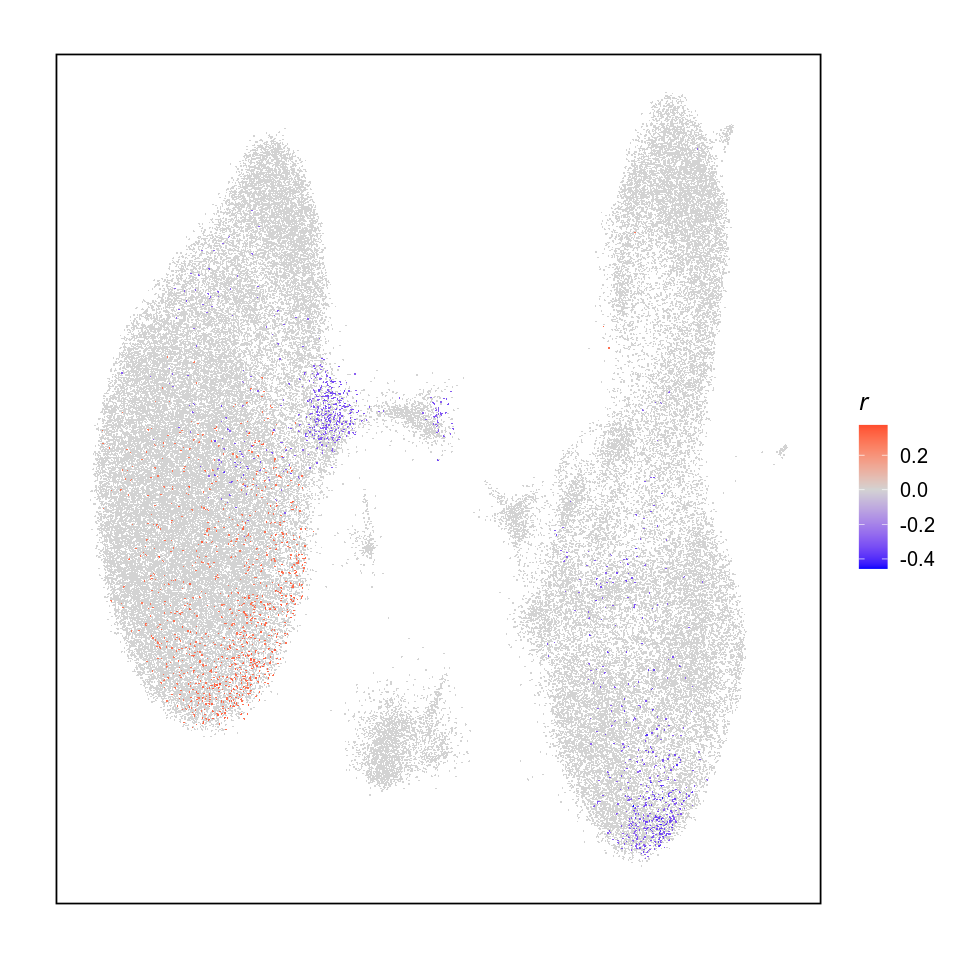

In [83]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.10) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) %>% 
                    left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.25))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)

ggplot() + 
      geom_point(data = data.frame(SLE_umap),
                aes(x = UMAP_1, y = UMAP_2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "right",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


In [47]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_metadata.rds')

In [51]:
annotations <- data.frame(RNA_snn_res.0.25 = as.character(seq(0, 8)),
                          annotation = c("B0. CXCR5high Naive",
                                         "B1. CRIP1+ Mature",
                                         "B2. FCRL5+ ITGAX+ ABC",
                                         "B3. CD79A+ VREPB3+ pre B Cell",
                                         "B4. ISGhigh Naive",
                                         "B5. MThigh",
                                         "B6. JUN+ NFKB1+ Activated",
                                         "B7. IGKC+ XBP1+ Plasma-like", 
                                         "B8. FCRL5+ ITGAX+ ABC"))

Joining, by = "Cell"
Joining, by = "RNA_snn_res.0.25"


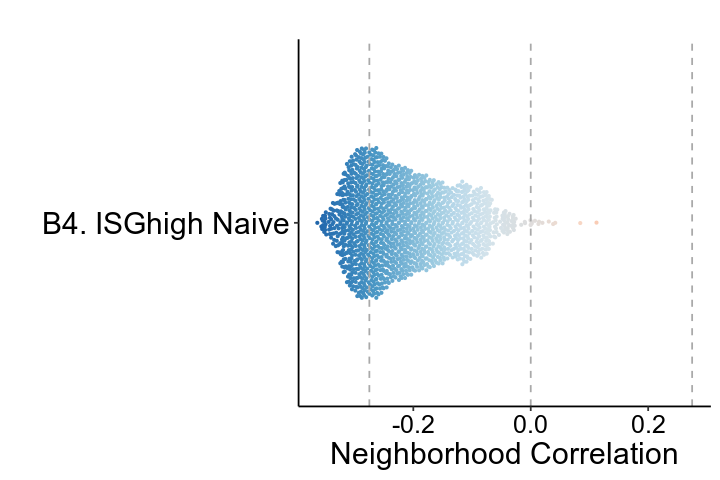

In [70]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1


meta <- meta %>% 
                left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.25)) %>% 
                 mutate(RNA_snn_res.0.25 = as.character(RNA_snn_res.0.25)) %>%
                    left_join(annotations)
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(4, 6)

ggplot(meta %>% filter(RNA_snn_res.0.25 == 4), aes(y = reorder(annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [76]:
SLE_pbmc_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/SLE_b_cell_pbmc_metadata.rds')
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/meta.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/cond_ncorr.csv", header = FALSE)
meta$ncorr <- ncorr$V1

ci_summary <- meta %>% left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.25)) %>% 
                select(RNA_snn_res.0.25, Cell, ncorr) %>% 
                group_by(RNA_snn_res.0.25) %>% 
                summarize(ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(Cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(Cell)), 3), ")"))
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/bcell_pbmc/chronicity_covariates.rds') %>% 
            mutate(RNA_snn_res.0.25 = as.factor(str_remove(cluster, "cluster")),
               OR.ci = paste0("(", round(Final_Chronicity.OR.95pct.ci.lower, 3), ", ", 
                              round(Final_Chronicity.OR.95pct.ci.upper, 3), ")")) %>% 
        select(RNA_snn_res.0.25, OR.ci)

summary <- ci_summary %>% left_join(res)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/bcell_chronicity_corr_04192024.csv', 
          quote = FALSE, row.names = FALSE, sep = '\t')

Joining, by = "Cell"
Joining, by = "RNA_snn_res.0.25"


### MASC

In [55]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/meta.csv")

model_df <- meta %>% 
                left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.25)) %>% 
                 mutate(RNA_snn_res.0.25 = as.character(RNA_snn_res.0.25))

res <- MASC.me(model_df, as.factor(model_df$RNA_snn_res.0.25),
                contrast = "Final_Chronicity",
                random_effects = c("Unified_Visit"),
                fixed_effects = c("Age", "Sex", 'First_biop', 'Responder_Status'),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Joining, by = "Cell"
Using null model: cluster ~ Age + Sex + First_biop + Responder_Status + (1|Unified_Visit)

Creating logistic mixed models for cluster0

Creating logistic mixed models for cluster1

Creating logistic mixed models for cluster2

Creating logistic mixed models for cluster3

Creating logistic mixed models for cluster4

Creating logistic mixed models for cluster5

Creating logistic mixed models for cluster6

Creating logistic mixed models for cluster7

Creating logistic mixed models for cluster8

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



In [56]:
dir.create('/data/srlab/ssg34/SLE_kidney_v2/data/masc/bcell_pbmc/')

In [58]:
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/bcell_pbmc/chronicity_covariates.rds')

In [59]:
res <- res %>% 
        rowwise() %>% 
        mutate(cluster = paste0('B', unlist(str_split(cluster, 'cluster'))[2]))

In [61]:
res

cluster size  model.pvalue Final_Chronicity.OR
1 B4       1539 0.002810345  0.8298431          
2 B1       9959 0.194041376  0.9389977          
3 B0      18823 0.296711400  1.0632180          
4 B5       1237 0.304565003  1.0250291          
5 B8         30 0.465044958  0.7473113          
6 B7        229 0.472854693  0.7335780          
7 B6        290 0.642656360  1.0270458          
8 B3       3518 0.757931660  1.0174289          
9 B2       5959 0.820081223  0.9881976          
  Final_Chronicity.OR.95pct.ci.lower Final_Chronicity.OR.95pct.ci.upper
1 0.7368816                          0.9345323                         
2 0.8542094                          1.0322021                         
3 0.9496968                          1.1903090                         
4 0.9772550                          1.0751387                         
5 0.3186558                          1.7525939                         
6 0.3134812                          1.7166478                         
7 0.9193335                          1.1473780                         
8 0.9125550                          1.1343553                         
9 0.8933223                          1.0931492                         
  bonferroni
1 0.02529311
2 1.00000000
3 1.00000000
4 1.00000000
5 1.00000000
6 1.00000000
7 1.00000000
8 1.00000000
9 1.00000000

Warning message:
“Removed 8 rows containing missing values (`geom_label_repel()`).”


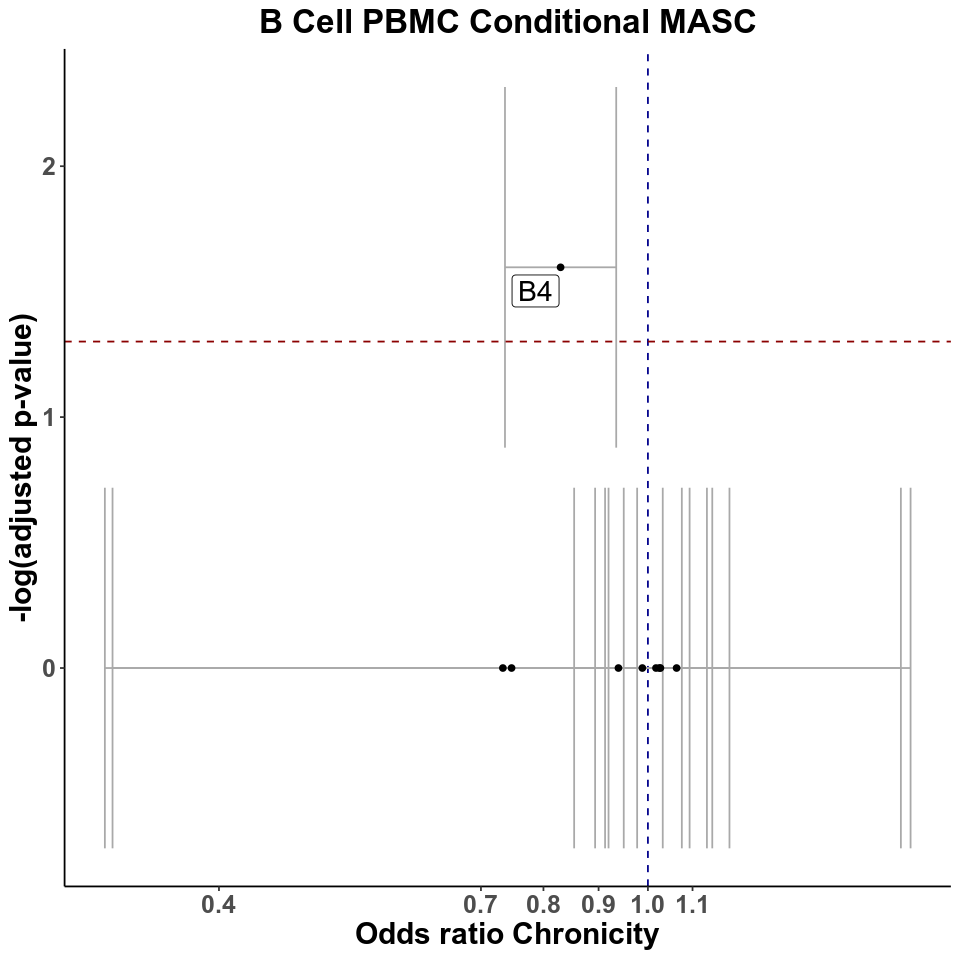

In [65]:
fig.size(8, 8)
ggplot(data = res %>% mutate(label = ifelse(-log10(model.pvalue) > -log10(0.05), cluster, NA)), 
       aes(x = Final_Chronicity.OR, y = -log10(bonferroni))) +
    theme_classic() + ylab("-log(adjusted p-value)") + xlab("Odds ratio Chronicity") + 
    labs(title = "B Cell PBMC Conditional MASC") +
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=Final_Chronicity.OR.95pct.ci.lower	, xmax=Final_Chronicity.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(.05), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.1, 0.4, 0.7, 0.8, 0.9, 1, 1.1)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(plot.title = element_text(size = 20, hjust = 0.5, face = "bold"),
          axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"))

### DE

In [186]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, Unified_Visit, 
                              Final_Chronicity, avg_count, avg_mt, Age, Sex) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.1 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Final_Chronicity, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['Final_Chronicity', 'Estimate']
        SE <- summary(m_1)$coefficients['Final_Chronicity', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [187]:
b_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/bcell_pbmc_norm_pseudobulk_01042024.rds')
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/chronicity/meta.csv")

In [188]:
b_pb <- b_pb %>% 
                filter(Unified_Visit %in% unique(meta$Unified_Visit)) %>% 
                left_join(meta %>% 
                              select(Unified_Visit, Age, Sex, Final_Chronicity) %>% 
                              unique())

Joining, by = "Unified_Visit"


In [189]:
de_out <- mclapply(colnames(b_pb)[1:36601], de, b_pb, mc.cores = 20)

In [190]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [191]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/bcell_chronicity_differential_expression_pbmc_04012024.rds')

In [192]:
de_df <- de_df %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) 

In [197]:
de_df %>% arrange(Beta)

gene       LRP         F         Beta        SE          FDR      
1     HLA-DRB5   0.24468266  1.3705154 -0.04643585 0.039665368 0.9995761
2     IFI44L     0.09031605  2.9286888 -0.04446087 0.025980132 0.9995761
3     HLA-DQA2   0.19006731  1.7421874 -0.03944570 0.029884927 0.9995761
4     ZFP36L2    0.15161326  2.0897796 -0.02902806 0.020080187 0.9995761
5     XAF1       0.12211032  2.4337338 -0.02615966 0.016768554 0.9995761
6     MX1        0.13752679  2.2435092 -0.02532819 0.016909872 0.9995761
7     XIST       0.24689849  1.3576210 -0.02516276 0.021595788 0.9995761
8     TXNIP      0.39346831  0.7349360 -0.02405686 0.028061709 0.9995761
9     EIF2AK2    0.05526914  3.7669992 -0.02345343 0.012083940 0.9995761
10    CRIP1      0.25050785  1.3369213 -0.02237936 0.019355069 0.9995761
11    CXCR4      0.35575366  0.8612944 -0.02212322 0.023838150 0.9995761
12    BTG1       0.21641993  1.5487102 -0.02087468 0.016773931 0.9995761
13    ISG20      0.16051585  2.0008411 -0.02025729 0.014321054 0.9995761
14    YBX3       0.30356983  1.0701313 -0.02010019 0.019430393 0.9995761
15    ISG15      0.25620030  1.3050170 -0.02008591 0.017582615 0.9995761
16    HERPUD1    0.28576762  1.1525336 -0.01866659 0.017387546 0.9995761
17    CALM2      0.01226628  6.5215056 -0.01797530 0.007038858 0.9665704
18    RCSD1      0.10246904  2.7194715 -0.01737934 0.010538800 0.9995761
19    IFITM1     0.01230982  6.5147578 -0.01648664 0.006459264 0.9665704
20    MTRNR2L12  0.33338777  0.9454023 -0.01645126 0.016919628 0.9995761
21    TRIM22     0.05223141  3.8657455 -0.01623138 0.008255414 0.9995761
22    SOCS1      0.02370340  5.2866816 -0.01605644 0.006983253 0.9995761
23    RNGTT      0.04902484  3.9769213 -0.01543488 0.007739800 0.9995761
24    S100A4     0.17047910  1.9078307 -0.01543220 0.011172694 0.9995761
25    GABPB1-AS1 0.19943842  1.6699097 -0.01523422 0.011788911 0.9995761
26    S100A6     0.13935593  2.2225555 -0.01517280 0.010177464 0.9995761
27    COX5A      0.01959454  5.6392534 -0.01483618 0.006247573 0.9995761
28    RPS24      0.02110338  5.5014324 -0.01463377 0.006239048 0.9995761
29    EPSTI1     0.17152200  1.8984613 -0.01451339 0.010533383 0.9995761
30    IRF7       0.10816958  2.6306308 -0.01433905 0.008840776 0.9995761
⋮     ⋮          ⋮           ⋮         ⋮           ⋮           ⋮        
21250 GAPT       0.160439804 2.0015766 0.01422400  0.010053924 0.9995761
21251 RIPOR2     0.217598072 1.5407283 0.01442975  0.011625079 0.9995761
21252 RHOB       0.151578913 2.0901343 0.01460107  0.010099446 0.9995761
21253 MEF2C      0.117705939 2.4930966 0.01474302  0.009337207 0.9995761
21254 COBLL1     0.022475839 5.3848029 0.01517264  0.006538473 0.9995761
21255 CALHM6     0.169543530 1.9162928 0.01518309  0.010968047 0.9995761
21256 LINC00926  0.143275008 2.1786967 0.01537077  0.010413513 0.9995761
21257 RPS10      0.202392205 1.6479604 0.01557008  0.012128787 0.9995761
21258 ITGA4      0.079772913 3.1370577 0.01557148  0.008791614 0.9995761
21259 ID3        0.018728825 5.7234688 0.01587557  0.006635896 0.9995761
21260 KLF2       0.254538700 1.3142378 0.01617360  0.014108135 0.9995761
21261 KIAA0040   0.092940990 2.8809647 0.01619495  0.009541369 0.9995761
21262 PNRC1      0.052092712 3.8704007 0.01637488  0.008323388 0.9995761
21263 TRBC2      0.005675541 8.0144593 0.01660935  0.005866993 0.8943198
21264 SMDT1      0.142302046 2.1894564 0.01724915  0.011657341 0.9995761
21265 PPP1R15A   0.052093067 3.8703888 0.01755534  0.008923433 0.9995761
21266 FCER2      0.040064274 4.3345228 0.01834566  0.008811760 0.9995761
21267 HIST1H1C   0.021692069 5.4504551 0.01912512  0.008191960 0.9995761
21268 HIST1H1D   0.043035788 4.2071824 0.01999414  0.009747811 0.9995761
21269 HLA-DQA1   0.092435147 2.8900448 0.02052272  0.012072093 0.9995761
21270 IER2       0.140124709 2.2138421 0.02220100  0.014921041 0.9995761
21271 HLA-DRB1   0.265472399 1.2549015 0.02221871  0.019834169 0.9995761
21272 BTG2       0.030050670 4.8524831 0.02244209  0.010187821 0

## ACTIVITY

In [74]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/activity/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/activity/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/activity/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## ISN

In [75]:
meta <- SLE_pbmc_meta

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- SLE_harmony[meta$Cell, 1:20]
umap <- SLE_umap[meta$Cell, 1:2]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/isn/meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/isn/harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/isn/umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESULTS

In [ ]:
meta <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/isn/meta.csv")
umap <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/isn/umap.csv")
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/isn/class_5_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/b_cell/isn/class_5_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.11) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) %>% 
                    left_join(SLE_pbmc_meta %>% select(Cell, RNA_snn_res.0.5))
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(
      data = tmp_meta %>% rename(correlation = ncorr), 
          aes(x = UMAP_1, y = UMAP_2, color = correlation),
        size = 0.75, stroke = 0.00001) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Mono/DC ISN Class 5") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

# COMPILED BLOOD CNA FIGURE

In [125]:
full_results <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/pbmc/full_res_cna_four_var.csv')

In [126]:
plot_df <- full_results 

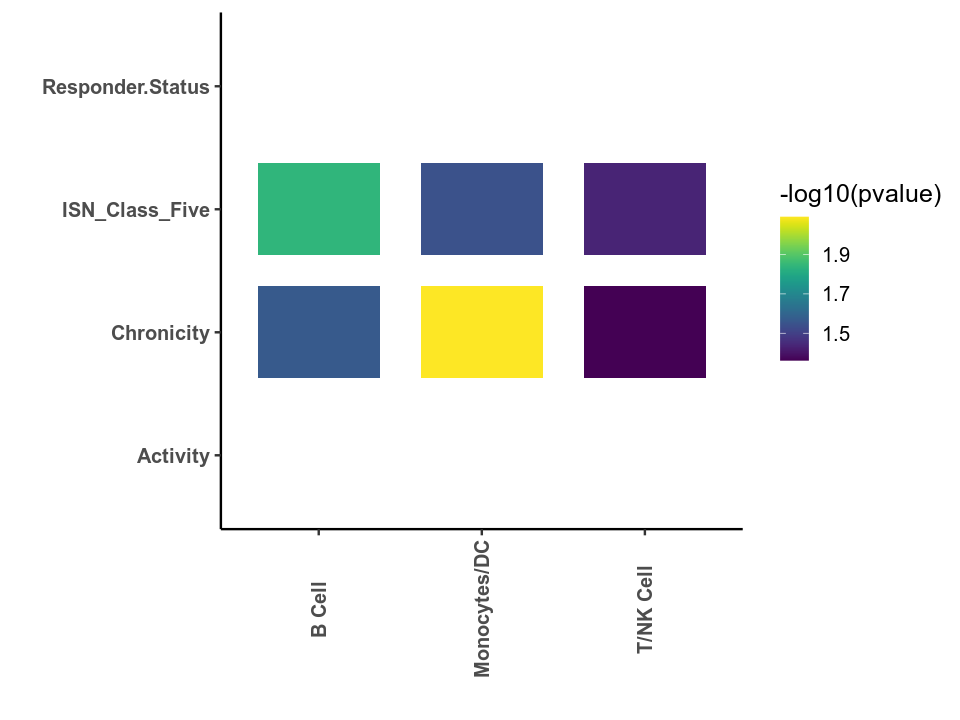

In [98]:
fig.size(6, 8)
ggplot(plot_df %>% mutate(Univariate = ifelse(Univariate < 0.05, Univariate, NA)), 
       aes(x = Cell.Type, y = variable, fill = -log10(Univariate))) + 
    geom_tile(width = 0.75, height = 0.75) + 
    scale_fill_viridis(na.value = "white",
                       name = "-log10(pvalue)") + 
    theme_classic(base_size = 15) + 
    labs(x = "", y = "") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5),
          axis.text = element_text(face = "bold")) 

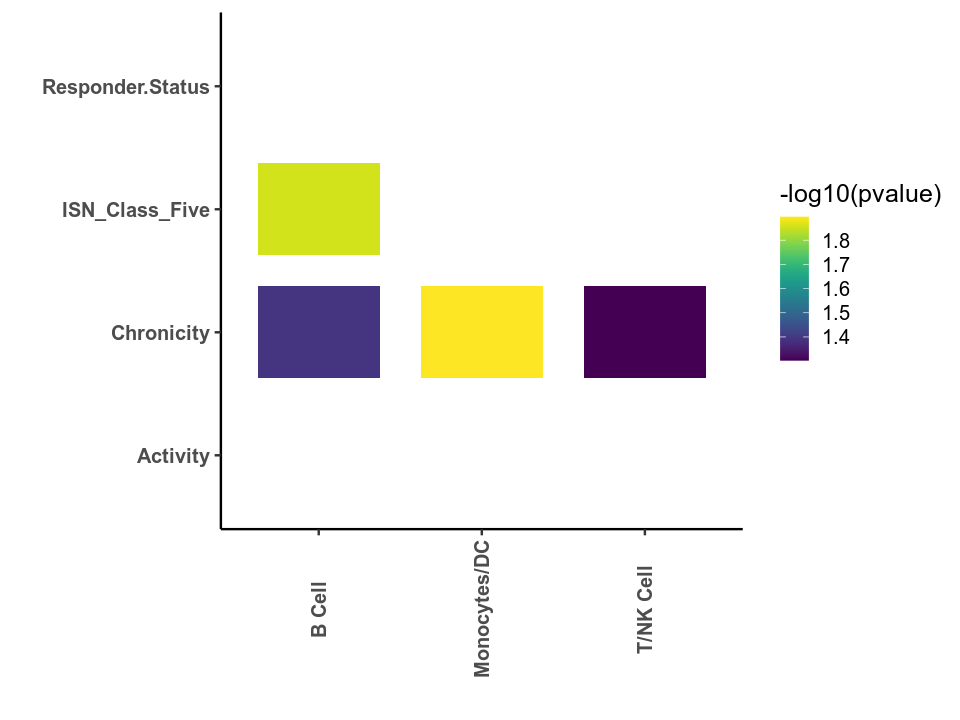

In [129]:
fig.size(6, 8)
ggplot() + 
    geom_tile(plot_df %>% 
              mutate(Conditional = ifelse(Conditional < 0.05, Conditional, NA)), 
              mapping = aes(x = Cell.Type, y = variable, fill = -log10(Conditional)),
              width = 0.75, height = 0.75) + 
    scale_fill_viridis(na.value = "white",
                       name = "-log10(pvalue)") + 
    theme_classic(base_size = 15) + 
    labs(x = "", y = "") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5),
          axis.text = element_text(face = "bold"))

In [128]:
plot_df

Univariate Conditional Cell.Type    variable        
1  0.65993401         NA  B Cell       Responder.Status
2  0.02729727 0.04039596  B Cell       Chronicity      
3  0.86501350         NA  B Cell       Activity        
4  0.01449855 0.01389861  B Cell       ISN_Class_Five  
5  0.55654435         NA  T/NK Cell    Responder.Status
6  0.04349565 0.04979502  T/NK Cell    Chronicity      
7  0.09519048         NA  T/NK Cell    Activity        
8  0.03689631 0.09279072  T/NK Cell    ISN_Class_Five  
9  0.71782822         NA  Monocytes/DC Responder.Status
10 0.00809919 0.01269873  Monocytes/DC Chronicity      
11 0.45755424         NA  Monocytes/DC Activity        
12 0.02859714 0.05829417  Monocytes/DC ISN_Class_Five

In [78]:
plot_df %>% mutate(Univariate = ifelse(Univariate < 0.05, Univariate, NA))

Univariate Conditional Cell.Type    variable        
1          NA         NA  B Cell       Responder.Status
2  0.02729727 0.04039596  B Cell       Chronicity      
3          NA         NA  B Cell       Activity        
4  0.01449855 0.01389861  B Cell       ISN_Class_Five  
5          NA         NA  T/NK Cell    Responder.Status
6  0.04349565 0.04979502  T/NK Cell    Chronicity      
7          NA         NA  T/NK Cell    Activity        
8  0.03689631 0.09279072  T/NK Cell    ISN_Class_Five  
9          NA         NA  Monocytes/DC Responder.Status
10 0.00809919 0.01269873  Monocytes/DC Chronicity      
11         NA         NA  Monocytes/DC Activity        
12 0.02859714 0.05829417  Monocytes/DC ISN_Class_Five